# Calculate the rs-fMRI functional connectivity (FC) matrix for each GSP subject 
## Schaefer 400, 7 network parcellation

# TO EDIT (write a little overall description of the code below (can say here that using nilearn): This is done for each scan session (day1 LR, day1 RL, day2 LR, day2 RL) by subject, then calculates the mean FC matrix from the 4 session matrices for each subject and saves it

Nilearn method to extract signals from a brain parcellation https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
from XYZ timeseries nii.gz file to functional connectivtiy matrices

Decided to include only session 1 because it's consistent across subjects (some of them do not have a session 2, but no indication that session 2 are run when session 1 has a problem (https://www.nature.com/articles/sdata201531)) so here we're not averageing across sessions as done in HCP

## Load packages

In [1]:
# General
import numpy as np
from numpy import inf
import pandas as pd
import os
import csv  # read csv and txt files

# Computing
import scipy.io  # loadmat
import mat73  # loadmat
import sklearn 

# Neuroimaging
import nibabel as nib
import hcp_utils as hcp
from nilearn import datasets  # fetch_atlas_schaefer_2018 
from nilearn.maskers import NiftiLabelsMasker  # to create a masker based on atlas
from nilearn.connectome import ConnectivityMeasure  # compute connectivity matrix from timeseries 

# Plotting
from nilearn import plotting

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [117]:
mat = mat73.loadmat('/data/p_02667/sex_diff_gradients/data/GSP/sub-0001/ses-01/Confounds_sub-0001_ses-01.mat')

In [125]:
mat.keys()

dict_keys(['DSE_Stat', 'DVARS', 'DVARS_Stat', 'FD', 'FD_Stat', 'FDts', 'RMS', 'TR', 'V', 'badTP', 'drp', 'gx', 'gx2', 'reg', 'regnames', 'rp'])

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/GSP/'

dataout = '/data/p_02667/sex_diff_gradients/data/fc_matrices/GSP/schaefer_output/'

In [3]:
path_list = os.listdir(datadir)
path_list.sort()

## Explore data

In [4]:
path_example_sub = datadir + 'sub-0001/ses-01/wsub-0001_ses-01.nii.gz'

In [5]:
# load image
img = nib.load(path_example_sub)

# get data from image
img_data = img.get_fdata()

img_data.shape

(91, 109, 91, 120)

The data from image is 4D, i.e.,  X, Y, Z_slice, time (XYZ * time) -> 91 x 109 x 91 x 120

**We need the data from the image to be 2D (voxel * time) in order to calculate the FC matrix**

Both of the above are timeseries; we need voxel format because XYZ gives the full grid but the brain takes up only a proportion of it - hence XYZ format contains many "empty locations" (zeros) which we do not want to use for the calculation of our FC matrices (we only want the brain voxels (non-zeros)

*Orignal explanation of structure of XYZ matrix vs voxel matrix: https://ohba-analysis.github.io/osl-docs/matlab/osl_example_parcellation.html*

## Retrieve Schaefer atlas

In [6]:
# fetch_atlas_schaefer_2018 function automatically saves in directory: 
  # a) the schaefer atlas labels (at location of atlas_filename below)
  # b) a txt file containing the labels and location on X,Y,Z plane (in the same folder)
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=1)

schaefer400_atlas_filename = dataset.maps
schaefer400_labels = dataset.labels  # len = 400

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      schaefer400_atlas_filename)  

Atlas ROIs are located in nifti image (4D) at: /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


*Checking the format (size) of the atlas is indeed 4D (we need the XYZ coordinates in order to detect on our 4D brain image which locations of the grid are part of the brain (and not zeros))*

In [7]:
# path of txt file including Schaefer atlas labels and location on X,Y,Z plane (fourth number (i.e., always 0) is a placeholder for timeseries? Not sure about this
with open('/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order.txt', newline = '\n') as networks:                                                                                          
    networks_reader = csv.reader(networks, delimiter='\t')
    for network in networks_reader:
        print(network)

['1', '7Networks_LH_Vis_1', '120', '17', '128', '0']
['2', '7Networks_LH_Vis_2', '120', '17', '129', '0']
['3', '7Networks_LH_Vis_3', '120', '17', '130', '0']
['4', '7Networks_LH_Vis_4', '120', '17', '131', '0']
['5', '7Networks_LH_Vis_5', '120', '17', '132', '0']
['6', '7Networks_LH_Vis_6', '120', '17', '133', '0']
['7', '7Networks_LH_Vis_7', '120', '17', '134', '0']
['8', '7Networks_LH_Vis_8', '120', '18', '127', '0']
['9', '7Networks_LH_Vis_9', '120', '18', '128', '0']
['10', '7Networks_LH_Vis_10', '120', '18', '129', '0']
['11', '7Networks_LH_Vis_11', '120', '18', '130', '0']
['12', '7Networks_LH_Vis_12', '120', '18', '131', '0']
['13', '7Networks_LH_Vis_13', '120', '18', '132', '0']
['14', '7Networks_LH_Vis_14', '120', '18', '133', '0']
['15', '7Networks_LH_Vis_15', '120', '18', '135', '0']
['16', '7Networks_LH_Vis_16', '120', '18', '136', '0']
['17', '7Networks_LH_Vis_17', '120', '18', '137', '0']
['18', '7Networks_LH_Vis_18', '120', '18', '138', '0']
['19', '7Networks_LH_Vis_19'

## Extract signal on Schaefer parcellation, compute connectivity matrix from timeseries, z-transform connectivity matrix, save connectivitiy matrix (loop over subjects)

In [8]:
# make a masker based on the retrieved Schaefer atlas
masker = NiftiLabelsMasker(labels_img=schaefer400_atlas_filename, standardize=True, memory='nilearn_cache', verbose=5)

for dir in path_list:
    path_current_sub = datadir + dir + '/ses-01/w' + dir + '_ses-01.nii.gz'
    
    if os.path.exists(path_current_sub):
        print('---------------- executing subject: ' + dir + ' ----------------')
        
        # Extract signals Schaefer parcellation defined by labels - here we go from nifti files to the signal time series in a numpy array (shape: 120 time, 400 parcels)
        time_series = masker.fit_transform(path_current_sub) 
                                            #, confounds=reduced_confounds)  # Note how we give confounds to be regressed out during signal extraction
        
        # compute connectivity matrix from timeseries (fit transforming timeseries data (time*parcels) with connectivity measure (correlation))
        corr_measure = ConnectivityMeasure(kind='correlation')
        corr_matrix = corr_measure.fit_transform([time_series])[0]
        
        # Fisher r to z transform
        corr_matrix_z = np.arctanh(corr_matrix) 
        corr_matrix_z[corr_matrix_z == inf] = 0
        
        # save
        fname_corr_matrix = dataout + dir +'.csv'
        np.savetxt(fname_corr_matrix, corr_matrix_z, delimiter = ',')
        print('---------------- finished subject: '+dir+' ----------------')
    
    else:
        fname_corr_matrix_failed = dataout + 'file_failed.txt'
        fail_file = open(fname_corr_matrix_failed, 'a')
        fail_file.write(dir+'\n')
        fail_file.close()
        print('---------------- subject ' + dir + ' file does not exist ----------------')
        

---------------- subject .datalad file does not exist ----------------
---------------- subject .git file does not exist ----------------
---------------- subject .gitattributes file does not exist ----------------
---------------- executing subject: sub-0001 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0001 ----------------
---------------- executing subject: sub-0002 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]4.1s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0002 ----------------
---------------- executing subject: sub-0003 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]6.9s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0003 ----------------
---------------- executing subject: sub-0004 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]9.4s, 0.2min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0004 ----------------
---------------- executing subject: sub-0005 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]12.2s, 0.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0005 ----------------
---------------- executing subject: sub-0006 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]16.0s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0006 ----------------
---------------- executing subject: sub-0007 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]18.8s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0007 ----------------
---------------- executing subject: sub-0009 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]22.3s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0009 ----------------
---------------- executing subject: sub-0010 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]25.2s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0010 ----------------
---------------- executing subject: sub-0011 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]28.1s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0011 ----------------
---------------- executing subject: sub-0012 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]30.9s, 0.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0012 ----------------
---------------- executing subject: sub-0013 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]33.3s, 0.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0013 ----------------
---------------- executing subject: sub-0014 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]35.9s, 0.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0014 ----------------
---------------- executing subject: sub-0015 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]38.7s, 0.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0015 ----------------
---------------- executing subject: sub-0016 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]41.8s, 0.7min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0016 ----------------
---------------- executing subject: sub-0017 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]44.5s, 0.7min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0017 ----------------
---------------- executing subject: sub-0018 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]47.0s, 0.8min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0018 ----------------
---------------- executing subject: sub-0019 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]49.4s, 0.8min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0019 ----------------
---------------- executing subject: sub-0020 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]52.0s, 0.9min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0020 ----------------
---------------- executing subject: sub-0021 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]54.4s, 0.9min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0021 ----------------
---------------- executing subject: sub-0022 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]56.8s, 0.9min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0022 ----------------
---------------- executing subject: sub-0023 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]59.6s, 1.0min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0023 ----------------
---------------- executing subject: sub-0024 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]62.5s, 1.0min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0024 ----------------
---------------- executing subject: sub-0025 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]65.0s, 1.1min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0025 ----------------
---------------- executing subject: sub-0026 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]67.5s, 1.1min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0026 ----------------
---------------- executing subject: sub-0027 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]69.9s, 1.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0027 ----------------
---------------- executing subject: sub-0028 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]72.4s, 1.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0028 ----------------
---------------- executing subject: sub-0029 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]74.9s, 1.2min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0029 ----------------
---------------- executing subject: sub-0030 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]77.4s, 1.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0030 ----------------
---------------- executing subject: sub-0031 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]80.3s, 1.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0031 ----------------
---------------- executing subject: sub-0032 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]83.4s, 1.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0032 ----------------
---------------- executing subject: sub-0033 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]85.9s, 1.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0033 ----------------
---------------- executing subject: sub-0034 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]88.8s, 1.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0034 ----------------
---------------- executing subject: sub-0035 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]92.9s, 1.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0035 ----------------
---------------- executing subject: sub-0036 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]95.9s, 1.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0036 ----------------
---------------- executing subject: sub-0037 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]98.5s, 1.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0037 ----------------
---------------- executing subject: sub-0038 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]101.7s, 1.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0038 ----------------
---------------- executing subject: sub-0039 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]104.5s, 1.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0039 ----------------
---------------- executing subject: sub-0040 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]108.7s, 1.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0040 ----------------
---------------- executing subject: sub-0041 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]112.1s, 1.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0041 ----------------
---------------- executing subject: sub-0042 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]115.2s, 1.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0042 ----------------
---------------- executing subject: sub-0043 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]118.7s, 2.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0043 ----------------
---------------- executing subject: sub-0044 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]121.8s, 2.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0044 ----------------
---------------- executing subject: sub-0045 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]124.5s, 2.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0045 ----------------
---------------- executing subject: sub-0046 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]127.5s, 2.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0046 ----------------
---------------- executing subject: sub-0047 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]130.1s, 2.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0047 ----------------
---------------- executing subject: sub-0048 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]132.7s, 2.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0048 ----------------
---------------- executing subject: sub-0049 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]135.1s, 2.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0049 ----------------
---------------- executing subject: sub-0050 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]138.0s, 2.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0050 ----------------
---------------- executing subject: sub-0051 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]140.5s, 2.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0051 ----------------
---------------- executing subject: sub-0052 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]143.1s, 2.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0052 ----------------
---------------- executing subject: sub-0053 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]145.6s, 2.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0053 ----------------
---------------- executing subject: sub-0054 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]148.0s, 2.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0054 ----------------
---------------- executing subject: sub-0055 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]150.4s, 2.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0055 ----------------
---------------- executing subject: sub-0056 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]152.7s, 2.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0056 ----------------
---------------- executing subject: sub-0057 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]155.1s, 2.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0057 ----------------
---------------- executing subject: sub-0058 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]157.5s, 2.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0058 ----------------
---------------- executing subject: sub-0059 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]159.8s, 2.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0059 ----------------
---------------- executing subject: sub-0060 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]162.3s, 2.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0060 ----------------
---------------- executing subject: sub-0061 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]164.7s, 2.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0061 ----------------
---------------- executing subject: sub-0062 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]167.1s, 2.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0062 ----------------
---------------- executing subject: sub-0063 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]169.5s, 2.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0063 ----------------
---------------- executing subject: sub-0064 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]172.0s, 2.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0064 ----------------
---------------- executing subject: sub-0065 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]174.5s, 2.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0065 ----------------
---------------- executing subject: sub-0066 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]176.9s, 2.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0066 ----------------
---------------- executing subject: sub-0067 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]179.4s, 3.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0067 ----------------
---------------- executing subject: sub-0068 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]181.8s, 3.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0068 ----------------
---------------- executing subject: sub-0069 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]184.2s, 3.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0069 ----------------
---------------- executing subject: sub-0070 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]186.7s, 3.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0070 ----------------
---------------- executing subject: sub-0071 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]190.0s, 3.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0071 ----------------
---------------- executing subject: sub-0072 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]192.6s, 3.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0072 ----------------
---------------- executing subject: sub-0073 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]195.1s, 3.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0073 ----------------
---------------- executing subject: sub-0074 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]197.6s, 3.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0074 ----------------
---------------- executing subject: sub-0075 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]200.1s, 3.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0075 ----------------
---------------- executing subject: sub-0076 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]202.9s, 3.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0076 ----------------
---------------- executing subject: sub-0077 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]205.4s, 3.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0077 ----------------
---------------- executing subject: sub-0078 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]207.8s, 3.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0078 ----------------
---------------- executing subject: sub-0079 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]210.5s, 3.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0079 ----------------
---------------- executing subject: sub-0080 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]213.1s, 3.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0080 ----------------
---------------- executing subject: sub-0081 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]215.5s, 3.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0081 ----------------
---------------- executing subject: sub-0082 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]218.1s, 3.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0082 ----------------
---------------- executing subject: sub-0083 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]220.6s, 3.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0083 ----------------
---------------- executing subject: sub-0084 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]223.1s, 3.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0084 ----------------
---------------- executing subject: sub-0085 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]225.7s, 3.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0085 ----------------
---------------- executing subject: sub-0086 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]228.1s, 3.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0086 ----------------
---------------- executing subject: sub-0087 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]230.8s, 3.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0087 ----------------
---------------- executing subject: sub-0088 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]233.2s, 3.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0088 ----------------
---------------- executing subject: sub-0089 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]235.6s, 3.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0089 ----------------
---------------- executing subject: sub-0090 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]238.1s, 4.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0090 ----------------
---------------- executing subject: sub-0091 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]240.6s, 4.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0091 ----------------
---------------- executing subject: sub-0092 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]243.1s, 4.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0092 ----------------
---------------- executing subject: sub-0093 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]245.5s, 4.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0093 ----------------
---------------- executing subject: sub-0094 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]248.0s, 4.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0094 ----------------
---------------- executing subject: sub-0095 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]250.4s, 4.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0095 ----------------
---------------- executing subject: sub-0096 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]252.8s, 4.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0096 ----------------
---------------- executing subject: sub-0097 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]255.5s, 4.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0097 ----------------
---------------- executing subject: sub-0098 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]258.0s, 4.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0098 ----------------
---------------- executing subject: sub-0099 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]260.4s, 4.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0099 ----------------
---------------- executing subject: sub-0100 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]263.7s, 4.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0100 ----------------
---------------- executing subject: sub-0101 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]266.1s, 4.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0101 ----------------
---------------- executing subject: sub-0102 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]268.7s, 4.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0102 ----------------
---------------- executing subject: sub-0103 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]271.2s, 4.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0103 ----------------
---------------- executing subject: sub-0104 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]273.7s, 4.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0104 ----------------
---------------- executing subject: sub-0105 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]276.2s, 4.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0105 ----------------
---------------- executing subject: sub-0106 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]278.7s, 4.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0106 ----------------
---------------- executing subject: sub-0107 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]281.1s, 4.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0107 ----------------
---------------- executing subject: sub-0108 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]283.6s, 4.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0108 ----------------
---------------- executing subject: sub-0109 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]285.5s, 4.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0109 ----------------
---------------- executing subject: sub-0110 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]287.9s, 4.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0110 ----------------
---------------- executing subject: sub-0111 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]290.4s, 4.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0111 ----------------
---------------- executing subject: sub-0112 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]292.8s, 4.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0112 ----------------
---------------- executing subject: sub-0113 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]295.2s, 4.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0113 ----------------
---------------- executing subject: sub-0114 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]297.8s, 5.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0114 ----------------
---------------- executing subject: sub-0115 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]300.1s, 5.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0115 ----------------
---------------- executing subject: sub-0116 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]302.6s, 5.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0116 ----------------
---------------- executing subject: sub-0117 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]305.0s, 5.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0117 ----------------
---------------- executing subject: sub-0118 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]307.6s, 5.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0118 ----------------
---------------- executing subject: sub-0119 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]310.1s, 5.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0119 ----------------
---------------- executing subject: sub-0120 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]312.7s, 5.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0120 ----------------
---------------- executing subject: sub-0121 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]315.1s, 5.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0121 ----------------
---------------- executing subject: sub-0122 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]317.7s, 5.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0122 ----------------
---------------- executing subject: sub-0123 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]320.5s, 5.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0123 ----------------
---------------- executing subject: sub-0124 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]323.1s, 5.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0124 ----------------
---------------- executing subject: sub-0125 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]325.6s, 5.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0125 ----------------
---------------- executing subject: sub-0126 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]328.4s, 5.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0126 ----------------
---------------- executing subject: sub-0127 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]330.9s, 5.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0127 ----------------
---------------- executing subject: sub-0128 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]333.6s, 5.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0128 ----------------
---------------- executing subject: sub-0129 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]336.0s, 5.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0129 ----------------
---------------- executing subject: sub-0130 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]338.6s, 5.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0130 ----------------
---------------- executing subject: sub-0131 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]341.1s, 5.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0131 ----------------
---------------- executing subject: sub-0132 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]344.5s, 5.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0132 ----------------
---------------- executing subject: sub-0133 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]346.9s, 5.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0133 ----------------
---------------- executing subject: sub-0134 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]349.3s, 5.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0134 ----------------
---------------- executing subject: sub-0135 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]351.7s, 5.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0135 ----------------
---------------- executing subject: sub-0136 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]354.2s, 5.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0136 ----------------
---------------- executing subject: sub-0137 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]356.6s, 5.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0137 ----------------
---------------- executing subject: sub-0138 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]359.0s, 6.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0138 ----------------
---------------- executing subject: sub-0139 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]361.3s, 6.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0139 ----------------
---------------- executing subject: sub-0140 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]363.9s, 6.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0140 ----------------
---------------- executing subject: sub-0141 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]366.4s, 6.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0141 ----------------
---------------- executing subject: sub-0142 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]369.2s, 6.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0142 ----------------
---------------- executing subject: sub-0143 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]371.7s, 6.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0143 ----------------
---------------- executing subject: sub-0144 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]374.6s, 6.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0144 ----------------
---------------- executing subject: sub-0145 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]377.1s, 6.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0145 ----------------
---------------- executing subject: sub-0146 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]379.6s, 6.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0146 ----------------
---------------- executing subject: sub-0147 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]382.0s, 6.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0147 ----------------
---------------- executing subject: sub-0148 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]384.4s, 6.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0148 ----------------
---------------- executing subject: sub-0149 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]386.9s, 6.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0149 ----------------
---------------- executing subject: sub-0150 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]389.7s, 6.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0150 ----------------
---------------- executing subject: sub-0151 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]392.2s, 6.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0151 ----------------
---------------- executing subject: sub-0152 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]394.7s, 6.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0152 ----------------
---------------- executing subject: sub-0153 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]397.1s, 6.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0153 ----------------
---------------- executing subject: sub-0154 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]399.5s, 6.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0154 ----------------
---------------- executing subject: sub-0155 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]402.0s, 6.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.4s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0155 ----------------
---------------- executing subject: sub-0156 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]404.9s, 6.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0156 ----------------
---------------- executing subject: sub-0157 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]407.4s, 6.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0157 ----------------
---------------- executing subject: sub-0158 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]410.0s, 6.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0158 ----------------
---------------- executing subject: sub-0159 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]412.7s, 6.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0159 ----------------
---------------- executing subject: sub-0160 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]415.0s, 6.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0160 ----------------
---------------- executing subject: sub-0161 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]417.3s, 7.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0161 ----------------
---------------- executing subject: sub-0162 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]419.6s, 7.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0162 ----------------
---------------- executing subject: sub-0163 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]422.4s, 7.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0163 ----------------
---------------- executing subject: sub-0164 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]425.0s, 7.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0164 ----------------
---------------- executing subject: sub-0165 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]427.4s, 7.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0165 ----------------
---------------- executing subject: sub-0166 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]429.8s, 7.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0166 ----------------
---------------- executing subject: sub-0167 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]432.4s, 7.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0167 ----------------
---------------- executing subject: sub-0168 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]434.8s, 7.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0168 ----------------
---------------- executing subject: sub-0169 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]437.4s, 7.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0169 ----------------
---------------- executing subject: sub-0170 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]439.9s, 7.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0170 ----------------
---------------- executing subject: sub-0171 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]442.3s, 7.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0171 ----------------
---------------- executing subject: sub-0172 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]444.7s, 7.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0172 ----------------
---------------- executing subject: sub-0173 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]447.1s, 7.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0173 ----------------
---------------- executing subject: sub-0174 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]449.6s, 7.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0174 ----------------
---------------- executing subject: sub-0175 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]452.1s, 7.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0175 ----------------
---------------- executing subject: sub-0176 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]454.6s, 7.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0176 ----------------
---------------- executing subject: sub-0177 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]457.0s, 7.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0177 ----------------
---------------- executing subject: sub-0178 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]459.4s, 7.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0178 ----------------
---------------- executing subject: sub-0179 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]461.9s, 7.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0179 ----------------
---------------- executing subject: sub-0180 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]464.5s, 7.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0180 ----------------
---------------- executing subject: sub-0181 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]467.0s, 7.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0181 ----------------
---------------- executing subject: sub-0182 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]469.5s, 7.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0182 ----------------
---------------- executing subject: sub-0183 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]471.9s, 7.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0183 ----------------
---------------- executing subject: sub-0184 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]474.5s, 7.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0184 ----------------
---------------- executing subject: sub-0185 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]476.5s, 7.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0185 ----------------
---------------- executing subject: sub-0186 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]479.0s, 8.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0186 ----------------
---------------- executing subject: sub-0187 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]482.4s, 8.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0187 ----------------
---------------- executing subject: sub-0188 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]484.8s, 8.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0188 ----------------
---------------- executing subject: sub-0189 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]487.2s, 8.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0189 ----------------
---------------- executing subject: sub-0190 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]489.8s, 8.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0190 ----------------
---------------- executing subject: sub-0191 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]492.3s, 8.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0191 ----------------
---------------- executing subject: sub-0192 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]494.8s, 8.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0192 ----------------
---------------- executing subject: sub-0193 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]497.3s, 8.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0193 ----------------
---------------- executing subject: sub-0194 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]499.8s, 8.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0194 ----------------
---------------- executing subject: sub-0195 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]502.3s, 8.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0195 ----------------
---------------- executing subject: sub-0196 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]504.8s, 8.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0196 ----------------
---------------- executing subject: sub-0197 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]507.6s, 8.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0197 ----------------
---------------- executing subject: sub-0198 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]509.9s, 8.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0198 ----------------
---------------- executing subject: sub-0199 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]512.5s, 8.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0199 ----------------
---------------- executing subject: sub-0200 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]515.1s, 8.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0200 ----------------
---------------- executing subject: sub-0201 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]517.5s, 8.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0201 ----------------
---------------- executing subject: sub-0202 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]519.9s, 8.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0202 ----------------
---------------- executing subject: sub-0203 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]522.2s, 8.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0203 ----------------
---------------- executing subject: sub-0204 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]524.6s, 8.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0204 ----------------
---------------- executing subject: sub-0205 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]527.0s, 8.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0205 ----------------
---------------- executing subject: sub-0206 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]529.5s, 8.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0206 ----------------
---------------- executing subject: sub-0207 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]531.9s, 8.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0207 ----------------
---------------- executing subject: sub-0208 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]534.5s, 8.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0208 ----------------
---------------- executing subject: sub-0209 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]537.0s, 8.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0209 ----------------
---------------- executing subject: sub-0210 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]540.4s, 9.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0210 ----------------
---------------- executing subject: sub-0211 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]542.9s, 9.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0211 ----------------
---------------- executing subject: sub-0212 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]545.5s, 9.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0212 ----------------
---------------- executing subject: sub-0213 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]548.0s, 9.1min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0213 ----------------
---------------- executing subject: sub-0214 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]550.6s, 9.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0214 ----------------
---------------- executing subject: sub-0215 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]553.1s, 9.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0215 ----------------
---------------- executing subject: sub-0216 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]555.5s, 9.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0216 ----------------
---------------- executing subject: sub-0217 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]557.7s, 9.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0217 ----------------
---------------- executing subject: sub-0218 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]560.3s, 9.3min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0218 ----------------
---------------- executing subject: sub-0219 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]562.8s, 9.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0219 ----------------
---------------- executing subject: sub-0220 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]565.1s, 9.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0220 ----------------
---------------- executing subject: sub-0221 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]567.6s, 9.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0221 ----------------
---------------- executing subject: sub-0222 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]570.0s, 9.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0222 ----------------
---------------- executing subject: sub-0223 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]572.5s, 9.5min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0223 ----------------
---------------- executing subject: sub-0224 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]574.9s, 9.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0224 ----------------
---------------- executing subject: sub-0225 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]577.2s, 9.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0225 ----------------
---------------- executing subject: sub-0226 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]579.7s, 9.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0226 ----------------
---------------- executing subject: sub-0227 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]582.0s, 9.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0227 ----------------
---------------- executing subject: sub-0228 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]584.4s, 9.7min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0228 ----------------
---------------- executing subject: sub-0229 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]586.9s, 9.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0229 ----------------
---------------- executing subject: sub-0230 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]589.3s, 9.8min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0230 ----------------
---------------- executing subject: sub-0231 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]591.7s, 9.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0231 ----------------
---------------- executing subject: sub-0232 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]594.4s, 9.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0232 ----------------
---------------- executing subject: sub-0233 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]596.8s, 9.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0233 ----------------
---------------- executing subject: sub-0234 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]599.2s, 10.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0234 ----------------
---------------- executing subject: sub-0235 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]601.6s, 10.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0235 ----------------
---------------- executing subject: sub-0236 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]604.0s, 10.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0236 ----------------
---------------- executing subject: sub-0237 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]606.4s, 10.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0237 ----------------
---------------- executing subject: sub-0238 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]608.9s, 10.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0238 ----------------
---------------- executing subject: sub-0239 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]611.3s, 10.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0239 ----------------
---------------- executing subject: sub-0240 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]613.8s, 10.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0240 ----------------
---------------- executing subject: sub-0241 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]616.2s, 10.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0241 ----------------
---------------- executing subject: sub-0242 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]618.6s, 10.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0242 ----------------
---------------- executing subject: sub-0243 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]621.1s, 10.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0243 ----------------
---------------- executing subject: sub-0244 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]623.6s, 10.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0244 ----------------
---------------- executing subject: sub-0245 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]626.1s, 10.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0245 ----------------
---------------- executing subject: sub-0246 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]628.6s, 10.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0246 ----------------
---------------- executing subject: sub-0247 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]631.0s, 10.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0247 ----------------
---------------- executing subject: sub-0248 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]633.4s, 10.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0248 ----------------
---------------- executing subject: sub-0249 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]635.8s, 10.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0249 ----------------
---------------- executing subject: sub-0250 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]638.3s, 10.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0250 ----------------
---------------- executing subject: sub-0251 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]640.7s, 10.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0251 ----------------
---------------- executing subject: sub-0252 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]643.2s, 10.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0252 ----------------
---------------- executing subject: sub-0253 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]645.7s, 10.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0253 ----------------
---------------- executing subject: sub-0254 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]648.0s, 10.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0254 ----------------
---------------- executing subject: sub-0255 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]650.5s, 10.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0255 ----------------
---------------- executing subject: sub-0256 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]652.9s, 10.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0256 ----------------
---------------- executing subject: sub-0257 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]655.5s, 10.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0257 ----------------
---------------- executing subject: sub-0258 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]657.8s, 11.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0258 ----------------
---------------- executing subject: sub-0259 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]660.3s, 11.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0259 ----------------
---------------- executing subject: sub-0260 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]662.7s, 11.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0260 ----------------
---------------- executing subject: sub-0261 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]665.1s, 11.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0261 ----------------
---------------- executing subject: sub-0262 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]667.7s, 11.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0262 ----------------
---------------- executing subject: sub-0263 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]669.9s, 11.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0263 ----------------
---------------- executing subject: sub-0264 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]672.5s, 11.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0264 ----------------
---------------- executing subject: sub-0265 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]675.0s, 11.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0265 ----------------
---------------- executing subject: sub-0266 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]677.4s, 11.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0266 ----------------
---------------- executing subject: sub-0267 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]679.8s, 11.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0267 ----------------
---------------- executing subject: sub-0268 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]682.6s, 11.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0268 ----------------
---------------- executing subject: sub-0269 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]685.0s, 11.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0269 ----------------
---------------- executing subject: sub-0270 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]687.5s, 11.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0270 ----------------
---------------- executing subject: sub-0271 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]689.9s, 11.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0271 ----------------
---------------- executing subject: sub-0272 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]692.4s, 11.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0272 ----------------
---------------- executing subject: sub-0273 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]694.8s, 11.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0273 ----------------
---------------- executing subject: sub-0274 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]697.3s, 11.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0274 ----------------
---------------- executing subject: sub-0275 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]699.7s, 11.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0275 ----------------
---------------- executing subject: sub-0276 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]702.2s, 11.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0276 ----------------
---------------- executing subject: sub-0277 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]704.7s, 11.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0277 ----------------
---------------- executing subject: sub-0278 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]707.1s, 11.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0278 ----------------
---------------- executing subject: sub-0279 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]709.6s, 11.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0279 ----------------
---------------- executing subject: sub-0280 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]712.1s, 11.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0280 ----------------
---------------- executing subject: sub-0281 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]714.6s, 11.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0281 ----------------
---------------- executing subject: sub-0282 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]717.1s, 12.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0282 ----------------
---------------- executing subject: sub-0283 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]719.6s, 12.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0283 ----------------
---------------- executing subject: sub-0284 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]722.0s, 12.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0284 ----------------
---------------- executing subject: sub-0285 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]724.5s, 12.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0285 ----------------
---------------- executing subject: sub-0286 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]726.8s, 12.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0286 ----------------
---------------- executing subject: sub-0287 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]729.2s, 12.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0287 ----------------
---------------- executing subject: sub-0288 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]731.6s, 12.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0288 ----------------
---------------- executing subject: sub-0289 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]734.2s, 12.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0289 ----------------
---------------- executing subject: sub-0290 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]736.6s, 12.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0290 ----------------
---------------- executing subject: sub-0291 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]739.3s, 12.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0291 ----------------
---------------- executing subject: sub-0292 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]741.6s, 12.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0292 ----------------
---------------- executing subject: sub-0293 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]745.0s, 12.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0293 ----------------
---------------- executing subject: sub-0294 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]747.5s, 12.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0294 ----------------
---------------- executing subject: sub-0295 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]750.0s, 12.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0295 ----------------
---------------- executing subject: sub-0296 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]752.7s, 12.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0296 ----------------
---------------- executing subject: sub-0297 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]755.2s, 12.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0297 ----------------
---------------- executing subject: sub-0298 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]757.6s, 12.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0298 ----------------
---------------- executing subject: sub-0299 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]760.0s, 12.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0299 ----------------
---------------- executing subject: sub-0300 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]762.4s, 12.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0300 ----------------
---------------- executing subject: sub-0301 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]764.8s, 12.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0301 ----------------
---------------- executing subject: sub-0302 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]767.2s, 12.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0302 ----------------
---------------- executing subject: sub-0303 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]769.7s, 12.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0303 ----------------
---------------- executing subject: sub-0304 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]772.0s, 12.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0304 ----------------
---------------- executing subject: sub-0305 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]774.6s, 12.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0305 ----------------
---------------- executing subject: sub-0306 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]777.0s, 13.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0306 ----------------
---------------- executing subject: sub-0307 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]779.6s, 13.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0307 ----------------
---------------- executing subject: sub-0308 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]781.9s, 13.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0308 ----------------
---------------- executing subject: sub-0309 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]784.5s, 13.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0309 ----------------
---------------- executing subject: sub-0310 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]786.9s, 13.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0310 ----------------
---------------- executing subject: sub-0311 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]789.4s, 13.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0311 ----------------
---------------- executing subject: sub-0312 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]791.9s, 13.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0312 ----------------
---------------- executing subject: sub-0313 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]794.3s, 13.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0313 ----------------
---------------- executing subject: sub-0314 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]796.8s, 13.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0314 ----------------
---------------- executing subject: sub-0315 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]799.3s, 13.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0315 ----------------
---------------- executing subject: sub-0316 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]801.8s, 13.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0316 ----------------
---------------- executing subject: sub-0317 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]804.3s, 13.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0317 ----------------
---------------- executing subject: sub-0318 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]807.0s, 13.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0318 ----------------
---------------- executing subject: sub-0319 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]809.5s, 13.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0319 ----------------
---------------- executing subject: sub-0320 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]812.2s, 13.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0320 ----------------
---------------- executing subject: sub-0321 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]814.7s, 13.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0321 ----------------
---------------- executing subject: sub-0322 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]817.2s, 13.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0322 ----------------
---------------- executing subject: sub-0323 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]819.6s, 13.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0323 ----------------
---------------- executing subject: sub-0324 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]822.1s, 13.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0324 ----------------
---------------- executing subject: sub-0325 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]824.7s, 13.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0325 ----------------
---------------- executing subject: sub-0326 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]827.1s, 13.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0326 ----------------
---------------- executing subject: sub-0327 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]829.6s, 13.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0327 ----------------
---------------- executing subject: sub-0328 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]832.1s, 13.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0328 ----------------
---------------- executing subject: sub-0329 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]834.6s, 13.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0329 ----------------
---------------- executing subject: sub-0330 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]837.0s, 14.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0330 ----------------
---------------- executing subject: sub-0331 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]839.5s, 14.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0331 ----------------
---------------- executing subject: sub-0332 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]842.0s, 14.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0332 ----------------
---------------- executing subject: sub-0333 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]844.4s, 14.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0333 ----------------
---------------- executing subject: sub-0334 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]847.0s, 14.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0334 ----------------
---------------- executing subject: sub-0335 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]849.5s, 14.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0335 ----------------
---------------- executing subject: sub-0336 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]852.0s, 14.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0336 ----------------
---------------- executing subject: sub-0337 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]854.4s, 14.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0337 ----------------
---------------- executing subject: sub-0338 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]857.2s, 14.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0338 ----------------
---------------- executing subject: sub-0339 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]859.6s, 14.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0339 ----------------
---------------- executing subject: sub-0340 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]862.1s, 14.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0340 ----------------
---------------- executing subject: sub-0341 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]864.5s, 14.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0341 ----------------
---------------- executing subject: sub-0342 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]866.9s, 14.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0342 ----------------
---------------- executing subject: sub-0343 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]869.4s, 14.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0343 ----------------
---------------- executing subject: sub-0344 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]871.8s, 14.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0344 ----------------
---------------- executing subject: sub-0345 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]874.3s, 14.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0345 ----------------
---------------- executing subject: sub-0346 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]876.8s, 14.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0346 ----------------
---------------- executing subject: sub-0347 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]879.3s, 14.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0347 ----------------
---------------- executing subject: sub-0348 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]881.8s, 14.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0348 ----------------
---------------- executing subject: sub-0349 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]884.3s, 14.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0349 ----------------
---------------- executing subject: sub-0350 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]886.9s, 14.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0350 ----------------
---------------- executing subject: sub-0351 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]889.3s, 14.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0351 ----------------
---------------- executing subject: sub-0352 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]891.9s, 14.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0352 ----------------
---------------- executing subject: sub-0353 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]894.5s, 14.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0353 ----------------
---------------- executing subject: sub-0354 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]896.9s, 14.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0354 ----------------
---------------- executing subject: sub-0355 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]899.3s, 15.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0355 ----------------
---------------- executing subject: sub-0356 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]901.7s, 15.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0356 ----------------
---------------- executing subject: sub-0357 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]904.1s, 15.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0357 ----------------
---------------- executing subject: sub-0358 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]906.5s, 15.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0358 ----------------
---------------- executing subject: sub-0359 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]909.0s, 15.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0359 ----------------
---------------- executing subject: sub-0360 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]911.4s, 15.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0360 ----------------
---------------- executing subject: sub-0361 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]913.8s, 15.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0361 ----------------
---------------- executing subject: sub-0362 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]916.2s, 15.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0362 ----------------
---------------- executing subject: sub-0363 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]918.7s, 15.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0363 ----------------
---------------- executing subject: sub-0364 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]921.3s, 15.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0364 ----------------
---------------- executing subject: sub-0365 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]923.6s, 15.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0365 ----------------
---------------- executing subject: sub-0366 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]926.0s, 15.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0366 ----------------
---------------- executing subject: sub-0367 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]928.6s, 15.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0367 ----------------
---------------- executing subject: sub-0368 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]931.1s, 15.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0368 ----------------
---------------- executing subject: sub-0369 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]932.9s, 15.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0369 ----------------
---------------- executing subject: sub-0370 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]935.3s, 15.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0370 ----------------
---------------- executing subject: sub-0371 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]937.7s, 15.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0371 ----------------
---------------- executing subject: sub-0372 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]940.2s, 15.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0372 ----------------
---------------- executing subject: sub-0373 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]942.6s, 15.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0373 ----------------
---------------- executing subject: sub-0374 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]945.0s, 15.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0374 ----------------
---------------- executing subject: sub-0375 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]947.3s, 15.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0375 ----------------
---------------- executing subject: sub-0376 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]949.7s, 15.8min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0376 ----------------
---------------- executing subject: sub-0377 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]952.1s, 15.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0377 ----------------
---------------- executing subject: sub-0378 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]954.5s, 15.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0378 ----------------
---------------- executing subject: sub-0379 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]956.8s, 15.9min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0379 ----------------
---------------- executing subject: sub-0380 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]959.1s, 16.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0380 ----------------
---------------- executing subject: sub-0381 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]961.4s, 16.0min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0381 ----------------
---------------- executing subject: sub-0382 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]964.0s, 16.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0382 ----------------
---------------- executing subject: sub-0383 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]966.4s, 16.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0383 ----------------
---------------- executing subject: sub-0384 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]968.2s, 16.1min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0384 ----------------
---------------- executing subject: sub-0385 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]970.6s, 16.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0385 ----------------
---------------- executing subject: sub-0386 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]972.9s, 16.2min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0386 ----------------
---------------- executing subject: sub-0387 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]975.4s, 16.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0387 ----------------
---------------- executing subject: sub-0388 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]977.7s, 16.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0388 ----------------
---------------- executing subject: sub-0389 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]980.1s, 16.3min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0389 ----------------
---------------- executing subject: sub-0390 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]982.6s, 16.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0390 ----------------
---------------- executing subject: sub-0391 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]985.0s, 16.4min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0391 ----------------
---------------- executing subject: sub-0392 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]987.4s, 16.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0392 ----------------
---------------- executing subject: sub-0393 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]989.7s, 16.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0393 ----------------
---------------- executing subject: sub-0394 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]992.2s, 16.5min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0394 ----------------
---------------- executing subject: sub-0395 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]994.7s, 16.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0395 ----------------
---------------- executing subject: sub-0396 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]997.1s, 16.6min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0396 ----------------
---------------- executing subject: sub-0397 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]999.4s, 16.7min : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0397 ----------------
---------------- executing subject: sub-0398 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1001.8s, 16.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0398 ----------------
---------------- executing subject: sub-0399 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1004.2s, 16.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0399 ----------------
---------------- executing subject: sub-0400 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1006.6s, 16.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0400 ----------------
---------------- executing subject: sub-0401 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1009.3s, 16.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0401 ----------------
---------------- executing subject: sub-0402 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1012.7s, 16.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0402 ----------------
---------------- executing subject: sub-0403 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1015.2s, 16.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0403 ----------------
---------------- executing subject: sub-0404 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1017.8s, 17.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0404 ----------------
---------------- executing subject: sub-0405 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1020.3s, 17.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0405 ----------------
---------------- executing subject: sub-0406 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1022.8s, 17.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0406 ----------------
---------------- executing subject: sub-0407 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1025.2s, 17.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0407 ----------------
---------------- executing subject: sub-0408 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1027.8s, 17.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0408 ----------------
---------------- executing subject: sub-0409 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1030.3s, 17.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0409 ----------------
---------------- executing subject: sub-0410 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1032.7s, 17.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0410 ----------------
---------------- executing subject: sub-0411 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1035.2s, 17.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0411 ----------------
---------------- executing subject: sub-0412 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1037.6s, 17.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0412 ----------------
---------------- executing subject: sub-0413 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1039.9s, 17.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0413 ----------------
---------------- executing subject: sub-0414 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1042.4s, 17.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0414 ----------------
---------------- executing subject: sub-0415 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1044.9s, 17.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0415 ----------------
---------------- executing subject: sub-0416 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1047.3s, 17.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0416 ----------------
---------------- executing subject: sub-0417 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1049.8s, 17.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0417 ----------------
---------------- executing subject: sub-0418 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1052.4s, 17.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0418 ----------------
---------------- executing subject: sub-0419 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1054.8s, 17.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0419 ----------------
---------------- executing subject: sub-0420 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1057.4s, 17.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0420 ----------------
---------------- executing subject: sub-0421 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1059.8s, 17.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0421 ----------------
---------------- executing subject: sub-0422 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1062.2s, 17.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0422 ----------------
---------------- executing subject: sub-0423 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1064.6s, 17.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0423 ----------------
---------------- executing subject: sub-0424 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1067.0s, 17.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0424 ----------------
---------------- executing subject: sub-0425 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1069.5s, 17.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0425 ----------------
---------------- executing subject: sub-0426 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1071.9s, 17.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0426 ----------------
---------------- executing subject: sub-0427 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1074.4s, 17.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0427 ----------------
---------------- executing subject: sub-0428 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1077.2s, 18.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0428 ----------------
---------------- executing subject: sub-0429 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1079.8s, 18.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0429 ----------------
---------------- executing subject: sub-0430 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1082.5s, 18.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0430 ----------------
---------------- executing subject: sub-0431 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1085.8s, 18.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0431 ----------------
---------------- executing subject: sub-0432 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1088.4s, 18.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0432 ----------------
---------------- executing subject: sub-0433 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1091.2s, 18.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0433 ----------------
---------------- executing subject: sub-0434 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1093.8s, 18.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0434 ----------------
---------------- executing subject: sub-0435 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1096.3s, 18.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0435 ----------------
---------------- executing subject: sub-0436 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1098.8s, 18.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0436 ----------------
---------------- executing subject: sub-0437 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1101.4s, 18.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0437 ----------------
---------------- executing subject: sub-0438 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1103.7s, 18.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0438 ----------------
---------------- executing subject: sub-0439 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1106.3s, 18.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0439 ----------------
---------------- executing subject: sub-0440 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1108.7s, 18.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0440 ----------------
---------------- executing subject: sub-0441 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1111.3s, 18.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0441 ----------------
---------------- executing subject: sub-0442 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1113.7s, 18.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0442 ----------------
---------------- executing subject: sub-0443 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1116.1s, 18.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0443 ----------------
---------------- executing subject: sub-0444 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1118.5s, 18.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0444 ----------------
---------------- executing subject: sub-0445 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1120.9s, 18.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0445 ----------------
---------------- executing subject: sub-0446 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1123.4s, 18.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0446 ----------------
---------------- executing subject: sub-0447 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1125.8s, 18.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0447 ----------------
---------------- executing subject: sub-0448 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1128.3s, 18.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0448 ----------------
---------------- executing subject: sub-0449 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1130.7s, 18.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0449 ----------------
---------------- executing subject: sub-0450 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1133.2s, 18.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0450 ----------------
---------------- executing subject: sub-0451 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1135.7s, 18.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0451 ----------------
---------------- executing subject: sub-0452 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1138.1s, 19.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0452 ----------------
---------------- executing subject: sub-0453 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1140.5s, 19.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0453 ----------------
---------------- executing subject: sub-0454 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1142.9s, 19.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0454 ----------------
---------------- executing subject: sub-0455 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1145.3s, 19.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0455 ----------------
---------------- executing subject: sub-0456 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1147.9s, 19.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0456 ----------------
---------------- executing subject: sub-0457 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1150.4s, 19.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0457 ----------------
---------------- executing subject: sub-0458 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1153.6s, 19.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0458 ----------------
---------------- executing subject: sub-0459 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1156.0s, 19.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0459 ----------------
---------------- executing subject: sub-0460 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1158.5s, 19.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0460 ----------------
---------------- executing subject: sub-0461 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1161.0s, 19.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0461 ----------------
---------------- executing subject: sub-0462 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1163.2s, 19.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0462 ----------------
---------------- executing subject: sub-0463 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1165.7s, 19.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0463 ----------------
---------------- executing subject: sub-0464 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1168.2s, 19.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0464 ----------------
---------------- executing subject: sub-0465 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1170.7s, 19.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0465 ----------------
---------------- executing subject: sub-0466 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1173.1s, 19.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0466 ----------------
---------------- executing subject: sub-0467 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1175.5s, 19.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0467 ----------------
---------------- executing subject: sub-0468 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1178.1s, 19.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0468 ----------------
---------------- executing subject: sub-0469 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1180.4s, 19.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0469 ----------------
---------------- executing subject: sub-0470 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1182.9s, 19.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0470 ----------------
---------------- executing subject: sub-0471 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1185.3s, 19.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0471 ----------------
---------------- executing subject: sub-0472 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1187.6s, 19.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0472 ----------------
---------------- executing subject: sub-0473 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1190.3s, 19.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0473 ----------------
---------------- executing subject: sub-0474 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1192.6s, 19.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0474 ----------------
---------------- executing subject: sub-0475 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1195.1s, 19.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0475 ----------------
---------------- executing subject: sub-0476 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1197.4s, 20.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0476 ----------------
---------------- executing subject: sub-0477 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1199.9s, 20.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0477 ----------------
---------------- executing subject: sub-0478 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1202.2s, 20.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0478 ----------------
---------------- executing subject: sub-0479 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1204.6s, 20.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0479 ----------------
---------------- executing subject: sub-0480 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1207.0s, 20.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0480 ----------------
---------------- executing subject: sub-0481 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1209.5s, 20.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0481 ----------------
---------------- executing subject: sub-0482 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1211.9s, 20.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0482 ----------------
---------------- executing subject: sub-0483 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1214.4s, 20.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0483 ----------------
---------------- executing subject: sub-0484 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1216.7s, 20.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0484 ----------------
---------------- executing subject: sub-0485 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1219.2s, 20.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0485 ----------------
---------------- executing subject: sub-0486 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1221.7s, 20.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0486 ----------------
---------------- executing subject: sub-0487 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1224.3s, 20.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0487 ----------------
---------------- executing subject: sub-0488 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1226.6s, 20.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0488 ----------------
---------------- executing subject: sub-0489 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1229.1s, 20.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0489 ----------------
---------------- executing subject: sub-0490 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1231.5s, 20.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0490 ----------------
---------------- executing subject: sub-0491 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1233.9s, 20.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0491 ----------------
---------------- executing subject: sub-0492 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1236.2s, 20.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0492 ----------------
---------------- executing subject: sub-0493 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1238.6s, 20.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0493 ----------------
---------------- executing subject: sub-0494 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1241.0s, 20.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0494 ----------------
---------------- executing subject: sub-0495 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1243.4s, 20.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0495 ----------------
---------------- executing subject: sub-0496 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1245.8s, 20.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0496 ----------------
---------------- executing subject: sub-0497 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1248.2s, 20.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0497 ----------------
---------------- executing subject: sub-0498 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1250.6s, 20.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0498 ----------------
---------------- executing subject: sub-0499 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1252.9s, 20.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0499 ----------------
---------------- executing subject: sub-0500 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1255.3s, 20.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0500 ----------------
---------------- executing subject: sub-0501 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1257.7s, 21.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0501 ----------------
---------------- executing subject: sub-0502 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1260.0s, 21.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0502 ----------------
---------------- executing subject: sub-0503 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1262.4s, 21.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0503 ----------------
---------------- executing subject: sub-0504 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1265.0s, 21.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0504 ----------------
---------------- executing subject: sub-0505 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1267.4s, 21.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0505 ----------------
---------------- executing subject: sub-0506 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1270.0s, 21.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0506 ----------------
---------------- executing subject: sub-0507 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1272.5s, 21.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0507 ----------------
---------------- executing subject: sub-0508 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1274.9s, 21.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0508 ----------------
---------------- executing subject: sub-0509 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1277.4s, 21.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0509 ----------------
---------------- executing subject: sub-0510 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1279.8s, 21.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0510 ----------------
---------------- executing subject: sub-0511 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1282.2s, 21.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0511 ----------------
---------------- executing subject: sub-0512 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1284.6s, 21.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0512 ----------------
---------------- executing subject: sub-0513 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1286.9s, 21.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0513 ----------------
---------------- executing subject: sub-0514 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1289.4s, 21.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0514 ----------------
---------------- executing subject: sub-0515 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1291.7s, 21.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0515 ----------------
---------------- executing subject: sub-0516 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1294.2s, 21.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0516 ----------------
---------------- executing subject: sub-0517 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1296.7s, 21.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0517 ----------------
---------------- executing subject: sub-0518 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1299.2s, 21.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0518 ----------------
---------------- executing subject: sub-0519 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1301.7s, 21.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0519 ----------------
---------------- executing subject: sub-0520 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1304.1s, 21.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0520 ----------------
---------------- executing subject: sub-0521 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1307.2s, 21.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0521 ----------------
---------------- executing subject: sub-0522 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1309.7s, 21.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0522 ----------------
---------------- executing subject: sub-0523 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1312.5s, 21.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0523 ----------------
---------------- executing subject: sub-0524 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1314.9s, 21.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0524 ----------------
---------------- executing subject: sub-0525 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1317.3s, 22.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0525 ----------------
---------------- executing subject: sub-0526 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1319.8s, 22.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0526 ----------------
---------------- executing subject: sub-0527 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1322.2s, 22.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0527 ----------------
---------------- executing subject: sub-0528 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1324.8s, 22.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0528 ----------------
---------------- executing subject: sub-0529 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1327.3s, 22.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0529 ----------------
---------------- executing subject: sub-0530 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1329.6s, 22.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0530 ----------------
---------------- executing subject: sub-0531 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1332.0s, 22.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0531 ----------------
---------------- executing subject: sub-0532 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1334.4s, 22.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0532 ----------------
---------------- executing subject: sub-0533 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1337.1s, 22.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0533 ----------------
---------------- executing subject: sub-0534 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1339.5s, 22.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0534 ----------------
---------------- executing subject: sub-0535 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1342.0s, 22.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0535 ----------------
---------------- executing subject: sub-0536 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1344.3s, 22.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0536 ----------------
---------------- executing subject: sub-0537 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1346.8s, 22.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0537 ----------------
---------------- executing subject: sub-0538 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1349.3s, 22.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0538 ----------------
---------------- executing subject: sub-0539 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1351.8s, 22.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0539 ----------------
---------------- executing subject: sub-0540 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1354.1s, 22.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0540 ----------------
---------------- executing subject: sub-0541 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1357.0s, 22.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0541 ----------------
---------------- executing subject: sub-0542 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1359.4s, 22.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0542 ----------------
---------------- executing subject: sub-0543 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1361.7s, 22.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0543 ----------------
---------------- executing subject: sub-0544 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1364.1s, 22.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0544 ----------------
---------------- executing subject: sub-0545 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1366.4s, 22.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0545 ----------------
---------------- executing subject: sub-0546 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1368.9s, 22.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0546 ----------------
---------------- executing subject: sub-0547 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1371.7s, 22.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0547 ----------------
---------------- executing subject: sub-0548 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1374.6s, 22.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0548 ----------------
---------------- executing subject: sub-0549 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1377.1s, 23.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0549 ----------------
---------------- executing subject: sub-0550 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1379.6s, 23.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0550 ----------------
---------------- executing subject: sub-0551 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1382.0s, 23.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0551 ----------------
---------------- executing subject: sub-0552 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1384.8s, 23.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0552 ----------------
---------------- executing subject: sub-0553 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1387.2s, 23.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0553 ----------------
---------------- executing subject: sub-0554 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1389.8s, 23.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0554 ----------------
---------------- executing subject: sub-0555 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1392.3s, 23.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0555 ----------------
---------------- executing subject: sub-0556 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1394.8s, 23.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0556 ----------------
---------------- executing subject: sub-0557 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1397.3s, 23.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0557 ----------------
---------------- executing subject: sub-0558 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1399.9s, 23.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0558 ----------------
---------------- executing subject: sub-0559 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1402.4s, 23.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0559 ----------------
---------------- executing subject: sub-0560 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1404.8s, 23.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0560 ----------------
---------------- executing subject: sub-0561 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1407.2s, 23.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0561 ----------------
---------------- executing subject: sub-0562 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1409.6s, 23.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0562 ----------------
---------------- executing subject: sub-0563 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1412.2s, 23.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0563 ----------------
---------------- executing subject: sub-0564 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1414.6s, 23.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0564 ----------------
---------------- executing subject: sub-0565 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1417.1s, 23.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0565 ----------------
---------------- executing subject: sub-0566 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1419.6s, 23.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0566 ----------------
---------------- executing subject: sub-0567 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1422.1s, 23.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0567 ----------------
---------------- executing subject: sub-0568 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1424.9s, 23.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0568 ----------------
---------------- executing subject: sub-0569 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1427.3s, 23.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0569 ----------------
---------------- executing subject: sub-0570 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1429.7s, 23.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0570 ----------------
---------------- executing subject: sub-0571 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1432.1s, 23.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0571 ----------------
---------------- executing subject: sub-0572 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1434.5s, 23.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0572 ----------------
---------------- executing subject: sub-0573 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1436.9s, 23.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0573 ----------------
---------------- executing subject: sub-0574 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1439.3s, 24.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0574 ----------------
---------------- executing subject: sub-0575 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1441.9s, 24.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0575 ----------------
---------------- executing subject: sub-0576 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1444.3s, 24.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0576 ----------------
---------------- executing subject: sub-0577 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1446.9s, 24.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0577 ----------------
---------------- executing subject: sub-0578 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1449.3s, 24.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0578 ----------------
---------------- executing subject: sub-0579 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1451.7s, 24.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0579 ----------------
---------------- executing subject: sub-0580 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1454.1s, 24.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0580 ----------------
---------------- executing subject: sub-0581 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1456.5s, 24.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0581 ----------------
---------------- executing subject: sub-0582 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1458.9s, 24.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0582 ----------------
---------------- executing subject: sub-0583 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1461.6s, 24.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0583 ----------------
---------------- executing subject: sub-0584 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1464.1s, 24.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0584 ----------------
---------------- executing subject: sub-0585 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1466.5s, 24.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0585 ----------------
---------------- executing subject: sub-0586 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1469.0s, 24.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0586 ----------------
---------------- executing subject: sub-0587 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1471.6s, 24.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0587 ----------------
---------------- executing subject: sub-0588 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1474.0s, 24.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0588 ----------------
---------------- executing subject: sub-0589 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1476.3s, 24.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0589 ----------------
---------------- executing subject: sub-0590 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1478.7s, 24.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0590 ----------------
---------------- executing subject: sub-0591 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1481.2s, 24.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0591 ----------------
---------------- executing subject: sub-0592 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1483.6s, 24.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0592 ----------------
---------------- executing subject: sub-0593 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1485.9s, 24.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0593 ----------------
---------------- executing subject: sub-0594 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1488.4s, 24.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0594 ----------------
---------------- executing subject: sub-0595 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1490.8s, 24.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0595 ----------------
---------------- executing subject: sub-0596 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1493.2s, 24.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0596 ----------------
---------------- executing subject: sub-0597 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1495.8s, 24.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0597 ----------------
---------------- executing subject: sub-0598 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1498.3s, 25.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0598 ----------------
---------------- executing subject: sub-0599 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1500.8s, 25.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0599 ----------------
---------------- executing subject: sub-0600 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1503.2s, 25.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0600 ----------------
---------------- executing subject: sub-0601 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1505.6s, 25.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0601 ----------------
---------------- executing subject: sub-0602 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1508.4s, 25.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0602 ----------------
---------------- executing subject: sub-0603 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1510.8s, 25.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0603 ----------------
---------------- executing subject: sub-0604 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1513.3s, 25.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0604 ----------------
---------------- executing subject: sub-0605 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1515.8s, 25.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0605 ----------------
---------------- executing subject: sub-0606 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1519.2s, 25.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0606 ----------------
---------------- executing subject: sub-0607 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1521.7s, 25.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0607 ----------------
---------------- executing subject: sub-0608 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1524.2s, 25.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0608 ----------------
---------------- executing subject: sub-0609 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1526.7s, 25.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0609 ----------------
---------------- executing subject: sub-0610 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1529.1s, 25.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0610 ----------------
---------------- executing subject: sub-0611 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1532.1s, 25.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0611 ----------------
---------------- executing subject: sub-0612 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1534.6s, 25.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0612 ----------------
---------------- executing subject: sub-0613 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1537.0s, 25.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0613 ----------------
---------------- executing subject: sub-0614 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1539.5s, 25.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0614 ----------------
---------------- executing subject: sub-0615 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1541.9s, 25.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0615 ----------------
---------------- executing subject: sub-0616 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1544.4s, 25.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0616 ----------------
---------------- executing subject: sub-0617 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1547.0s, 25.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0617 ----------------
---------------- executing subject: sub-0618 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1549.5s, 25.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0618 ----------------
---------------- executing subject: sub-0619 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1552.0s, 25.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0619 ----------------
---------------- executing subject: sub-0620 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1554.4s, 25.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0620 ----------------
---------------- executing subject: sub-0621 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1556.9s, 25.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0621 ----------------
---------------- executing subject: sub-0622 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1559.4s, 26.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0622 ----------------
---------------- executing subject: sub-0623 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1561.9s, 26.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0623 ----------------
---------------- executing subject: sub-0624 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1564.7s, 26.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0624 ----------------
---------------- executing subject: sub-0625 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1567.2s, 26.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0625 ----------------
---------------- executing subject: sub-0626 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1569.6s, 26.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0626 ----------------
---------------- executing subject: sub-0627 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1572.1s, 26.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0627 ----------------
---------------- executing subject: sub-0628 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1574.5s, 26.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0628 ----------------
---------------- executing subject: sub-0629 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1577.0s, 26.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0629 ----------------
---------------- executing subject: sub-0630 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1579.4s, 26.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0630 ----------------
---------------- executing subject: sub-0631 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1581.8s, 26.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0631 ----------------
---------------- executing subject: sub-0632 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1584.2s, 26.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0632 ----------------
---------------- executing subject: sub-0633 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1586.8s, 26.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0633 ----------------
---------------- executing subject: sub-0634 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1589.2s, 26.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0634 ----------------
---------------- executing subject: sub-0635 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1591.6s, 26.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0635 ----------------
---------------- executing subject: sub-0636 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1594.3s, 26.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0636 ----------------
---------------- executing subject: sub-0637 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1596.6s, 26.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0637 ----------------
---------------- executing subject: sub-0638 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1599.1s, 26.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0638 ----------------
---------------- executing subject: sub-0639 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1601.6s, 26.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0639 ----------------
---------------- executing subject: sub-0640 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1604.1s, 26.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0640 ----------------
---------------- executing subject: sub-0641 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1606.4s, 26.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0641 ----------------
---------------- executing subject: sub-0642 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1608.9s, 26.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0642 ----------------
---------------- executing subject: sub-0643 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1611.6s, 26.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0643 ----------------
---------------- executing subject: sub-0644 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1614.0s, 26.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0644 ----------------
---------------- executing subject: sub-0645 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1616.5s, 26.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0645 ----------------
---------------- executing subject: sub-0646 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1619.1s, 27.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0646 ----------------
---------------- executing subject: sub-0647 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1621.5s, 27.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0647 ----------------
---------------- executing subject: sub-0648 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1623.9s, 27.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0648 ----------------
---------------- executing subject: sub-0649 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1626.5s, 27.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0649 ----------------
---------------- executing subject: sub-0650 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1629.0s, 27.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0650 ----------------
---------------- executing subject: sub-0651 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1631.3s, 27.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0651 ----------------
---------------- executing subject: sub-0652 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1633.9s, 27.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0652 ----------------
---------------- executing subject: sub-0653 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1636.3s, 27.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0653 ----------------
---------------- executing subject: sub-0654 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1638.8s, 27.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0654 ----------------
---------------- executing subject: sub-0655 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1641.1s, 27.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0655 ----------------
---------------- executing subject: sub-0656 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1643.6s, 27.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0656 ----------------
---------------- executing subject: sub-0657 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1646.1s, 27.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0657 ----------------
---------------- executing subject: sub-0658 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1648.5s, 27.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0658 ----------------
---------------- executing subject: sub-0659 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1650.9s, 27.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0659 ----------------
---------------- executing subject: sub-0660 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1653.4s, 27.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0660 ----------------
---------------- executing subject: sub-0661 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1655.8s, 27.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0661 ----------------
---------------- executing subject: sub-0662 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1658.3s, 27.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0662 ----------------
---------------- executing subject: sub-0663 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1660.8s, 27.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0663 ----------------
---------------- executing subject: sub-0664 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1663.3s, 27.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0664 ----------------
---------------- executing subject: sub-0665 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1665.8s, 27.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0665 ----------------
---------------- executing subject: sub-0666 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1668.3s, 27.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0666 ----------------
---------------- executing subject: sub-0667 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1671.6s, 27.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0667 ----------------
---------------- executing subject: sub-0668 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1674.1s, 27.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0668 ----------------
---------------- executing subject: sub-0669 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1676.6s, 27.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0669 ----------------
---------------- executing subject: sub-0670 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1679.2s, 28.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0670 ----------------
---------------- executing subject: sub-0671 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1681.7s, 28.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0671 ----------------
---------------- executing subject: sub-0672 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1684.1s, 28.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0672 ----------------
---------------- executing subject: sub-0673 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1686.9s, 28.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0673 ----------------
---------------- executing subject: sub-0674 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1689.3s, 28.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0674 ----------------
---------------- executing subject: sub-0675 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1691.7s, 28.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0675 ----------------
---------------- executing subject: sub-0676 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1694.1s, 28.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0676 ----------------
---------------- executing subject: sub-0677 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1696.6s, 28.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0677 ----------------
---------------- executing subject: sub-0678 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1699.1s, 28.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0678 ----------------
---------------- executing subject: sub-0679 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1701.6s, 28.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0679 ----------------
---------------- executing subject: sub-0680 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1704.1s, 28.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0680 ----------------
---------------- executing subject: sub-0681 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1706.7s, 28.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0681 ----------------
---------------- executing subject: sub-0682 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1709.2s, 28.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0682 ----------------
---------------- executing subject: sub-0683 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1711.6s, 28.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0683 ----------------
---------------- executing subject: sub-0684 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1714.2s, 28.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0684 ----------------
---------------- executing subject: sub-0685 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1716.7s, 28.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0685 ----------------
---------------- executing subject: sub-0686 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1719.1s, 28.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0686 ----------------
---------------- executing subject: sub-0687 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1721.5s, 28.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0687 ----------------
---------------- executing subject: sub-0688 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1723.9s, 28.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0688 ----------------
---------------- executing subject: sub-0689 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1726.4s, 28.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0689 ----------------
---------------- executing subject: sub-0690 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1728.9s, 28.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0690 ----------------
---------------- executing subject: sub-0691 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1731.4s, 28.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0691 ----------------
---------------- executing subject: sub-0692 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1733.9s, 28.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0692 ----------------
---------------- executing subject: sub-0693 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1736.4s, 28.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0693 ----------------
---------------- executing subject: sub-0694 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1738.9s, 29.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0694 ----------------
---------------- executing subject: sub-0695 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1741.8s, 29.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0695 ----------------
---------------- executing subject: sub-0696 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1744.9s, 29.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0696 ----------------
---------------- executing subject: sub-0697 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1747.3s, 29.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0697 ----------------
---------------- executing subject: sub-0698 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1749.8s, 29.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0698 ----------------
---------------- executing subject: sub-0699 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1752.5s, 29.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0699 ----------------
---------------- executing subject: sub-0700 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1754.9s, 29.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0700 ----------------
---------------- executing subject: sub-0701 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1757.3s, 29.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0701 ----------------
---------------- executing subject: sub-0702 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1759.8s, 29.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0702 ----------------
---------------- executing subject: sub-0703 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1762.3s, 29.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0703 ----------------
---------------- executing subject: sub-0704 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1764.7s, 29.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0704 ----------------
---------------- executing subject: sub-0705 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1767.1s, 29.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0705 ----------------
---------------- executing subject: sub-0706 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1769.8s, 29.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0706 ----------------
---------------- executing subject: sub-0707 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1772.3s, 29.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0707 ----------------
---------------- executing subject: sub-0708 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1774.8s, 29.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0708 ----------------
---------------- executing subject: sub-0709 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1777.3s, 29.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0709 ----------------
---------------- executing subject: sub-0710 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1779.6s, 29.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0710 ----------------
---------------- executing subject: sub-0711 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1782.2s, 29.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0711 ----------------
---------------- executing subject: sub-0712 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1784.7s, 29.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0712 ----------------
---------------- executing subject: sub-0713 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1787.2s, 29.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0713 ----------------
---------------- executing subject: sub-0714 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1789.6s, 29.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0714 ----------------
---------------- executing subject: sub-0715 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1792.1s, 29.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0715 ----------------
---------------- executing subject: sub-0716 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1794.6s, 29.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0716 ----------------
---------------- executing subject: sub-0717 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1797.2s, 30.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0717 ----------------
---------------- executing subject: sub-0718 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1799.6s, 30.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0718 ----------------
---------------- executing subject: sub-0719 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1802.3s, 30.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0719 ----------------
---------------- executing subject: sub-0720 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1804.8s, 30.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0720 ----------------
---------------- executing subject: sub-0721 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1807.1s, 30.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0721 ----------------
---------------- executing subject: sub-0722 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1809.5s, 30.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0722 ----------------
---------------- executing subject: sub-0723 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1812.1s, 30.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0723 ----------------
---------------- executing subject: sub-0724 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1814.5s, 30.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0724 ----------------
---------------- executing subject: sub-0725 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1816.9s, 30.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0725 ----------------
---------------- executing subject: sub-0726 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1819.5s, 30.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0726 ----------------
---------------- executing subject: sub-0727 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1821.9s, 30.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0727 ----------------
---------------- executing subject: sub-0728 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1824.4s, 30.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0728 ----------------
---------------- executing subject: sub-0729 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1826.8s, 30.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0729 ----------------
---------------- executing subject: sub-0730 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1829.3s, 30.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0730 ----------------
---------------- executing subject: sub-0731 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1831.8s, 30.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0731 ----------------
---------------- executing subject: sub-0732 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1834.5s, 30.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0732 ----------------
---------------- executing subject: sub-0733 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1836.9s, 30.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0733 ----------------
---------------- executing subject: sub-0734 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1839.4s, 30.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0734 ----------------
---------------- executing subject: sub-0735 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1842.2s, 30.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0735 ----------------
---------------- executing subject: sub-0736 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1844.5s, 30.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0736 ----------------
---------------- executing subject: sub-0737 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1847.0s, 30.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0737 ----------------
---------------- executing subject: sub-0738 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1849.5s, 30.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0738 ----------------
---------------- executing subject: sub-0739 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1852.0s, 30.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0739 ----------------
---------------- executing subject: sub-0740 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1854.4s, 30.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0740 ----------------
---------------- executing subject: sub-0741 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1856.9s, 30.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0741 ----------------
---------------- executing subject: sub-0742 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1859.3s, 31.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0742 ----------------
---------------- executing subject: sub-0743 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1861.8s, 31.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0743 ----------------
---------------- executing subject: sub-0744 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1864.3s, 31.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0744 ----------------
---------------- executing subject: sub-0745 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1866.7s, 31.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0745 ----------------
---------------- executing subject: sub-0746 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1869.2s, 31.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0746 ----------------
---------------- executing subject: sub-0747 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1871.8s, 31.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0747 ----------------
---------------- executing subject: sub-0748 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1874.4s, 31.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0748 ----------------
---------------- executing subject: sub-0749 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1877.0s, 31.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0749 ----------------
---------------- executing subject: sub-0750 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1879.5s, 31.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0750 ----------------
---------------- executing subject: sub-0751 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1882.2s, 31.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0751 ----------------
---------------- executing subject: sub-0752 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1884.5s, 31.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0752 ----------------
---------------- executing subject: sub-0753 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1887.3s, 31.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0753 ----------------
---------------- executing subject: sub-0754 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1889.8s, 31.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0754 ----------------
---------------- executing subject: sub-0755 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1892.4s, 31.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0755 ----------------
---------------- executing subject: sub-0756 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1894.9s, 31.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0756 ----------------
---------------- executing subject: sub-0757 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1897.3s, 31.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0757 ----------------
---------------- executing subject: sub-0758 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1899.9s, 31.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0758 ----------------
---------------- executing subject: sub-0759 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1902.2s, 31.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0759 ----------------
---------------- executing subject: sub-0760 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1904.6s, 31.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0760 ----------------
---------------- executing subject: sub-0761 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1907.2s, 31.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0761 ----------------
---------------- executing subject: sub-0762 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1909.6s, 31.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0762 ----------------
---------------- executing subject: sub-0763 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1912.3s, 31.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0763 ----------------
---------------- executing subject: sub-0764 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1914.7s, 31.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0764 ----------------
---------------- executing subject: sub-0765 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1917.2s, 32.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0765 ----------------
---------------- executing subject: sub-0766 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1919.6s, 32.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0766 ----------------
---------------- executing subject: sub-0767 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1922.2s, 32.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0767 ----------------
---------------- executing subject: sub-0768 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1924.9s, 32.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0768 ----------------
---------------- executing subject: sub-0769 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1927.3s, 32.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0769 ----------------
---------------- executing subject: sub-0770 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1929.6s, 32.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0770 ----------------
---------------- executing subject: sub-0771 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1932.1s, 32.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0771 ----------------
---------------- executing subject: sub-0772 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1934.4s, 32.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0772 ----------------
---------------- executing subject: sub-0773 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1936.9s, 32.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0773 ----------------
---------------- executing subject: sub-0774 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1939.3s, 32.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0774 ----------------
---------------- executing subject: sub-0775 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1941.7s, 32.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0775 ----------------
---------------- executing subject: sub-0776 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1944.3s, 32.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0776 ----------------
---------------- executing subject: sub-0777 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1946.7s, 32.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0777 ----------------
---------------- executing subject: sub-0778 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1949.1s, 32.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0778 ----------------
---------------- executing subject: sub-0779 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1951.4s, 32.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0779 ----------------
---------------- executing subject: sub-0780 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1953.9s, 32.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0780 ----------------
---------------- executing subject: sub-0781 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1956.3s, 32.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0781 ----------------
---------------- executing subject: sub-0782 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1958.7s, 32.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0782 ----------------
---------------- executing subject: sub-0783 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1961.2s, 32.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0783 ----------------
---------------- executing subject: sub-0784 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1963.6s, 32.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0784 ----------------
---------------- executing subject: sub-0785 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1966.1s, 32.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0785 ----------------
---------------- executing subject: sub-0786 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1968.5s, 32.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0786 ----------------
---------------- executing subject: sub-0787 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1970.7s, 32.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0787 ----------------
---------------- executing subject: sub-0788 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1973.2s, 32.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0788 ----------------
---------------- executing subject: sub-0789 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1975.6s, 32.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0789 ----------------
---------------- executing subject: sub-0790 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1978.1s, 33.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0790 ----------------
---------------- executing subject: sub-0791 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1980.6s, 33.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0791 ----------------
---------------- executing subject: sub-0792 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1983.1s, 33.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0792 ----------------
---------------- executing subject: sub-0793 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1985.8s, 33.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0793 ----------------
---------------- executing subject: sub-0794 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1988.2s, 33.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0794 ----------------
---------------- executing subject: sub-0795 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1990.7s, 33.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0795 ----------------
---------------- executing subject: sub-0796 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1993.2s, 33.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0796 ----------------
---------------- executing subject: sub-0797 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1995.6s, 33.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0797 ----------------
---------------- executing subject: sub-0798 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]1998.0s, 33.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0798 ----------------
---------------- executing subject: sub-0799 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2000.6s, 33.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0799 ----------------
---------------- executing subject: sub-0800 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2003.3s, 33.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0800 ----------------
---------------- executing subject: sub-0801 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2005.8s, 33.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0801 ----------------
---------------- executing subject: sub-0802 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2008.3s, 33.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0802 ----------------
---------------- executing subject: sub-0803 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2010.8s, 33.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0803 ----------------
---------------- executing subject: sub-0804 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2013.2s, 33.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0804 ----------------
---------------- executing subject: sub-0805 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2015.6s, 33.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0805 ----------------
---------------- executing subject: sub-0806 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2018.1s, 33.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0806 ----------------
---------------- executing subject: sub-0807 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2020.5s, 33.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0807 ----------------
---------------- executing subject: sub-0808 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2023.0s, 33.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0808 ----------------
---------------- executing subject: sub-0809 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2025.5s, 33.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0809 ----------------
---------------- executing subject: sub-0810 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2027.9s, 33.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0810 ----------------
---------------- executing subject: sub-0811 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2031.4s, 33.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0811 ----------------
---------------- executing subject: sub-0812 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2033.8s, 33.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0812 ----------------
---------------- executing subject: sub-0813 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2036.6s, 33.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0813 ----------------
---------------- executing subject: sub-0814 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2038.9s, 34.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0814 ----------------
---------------- executing subject: sub-0815 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2041.3s, 34.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0815 ----------------
---------------- executing subject: sub-0816 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2043.8s, 34.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0816 ----------------
---------------- executing subject: sub-0817 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2046.2s, 34.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0817 ----------------
---------------- executing subject: sub-0818 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2048.6s, 34.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0818 ----------------
---------------- executing subject: sub-0819 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2051.2s, 34.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0819 ----------------
---------------- executing subject: sub-0820 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2053.6s, 34.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0820 ----------------
---------------- executing subject: sub-0821 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2056.0s, 34.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0821 ----------------
---------------- executing subject: sub-0822 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2058.6s, 34.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0822 ----------------
---------------- executing subject: sub-0823 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2061.0s, 34.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0823 ----------------
---------------- executing subject: sub-0824 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2063.5s, 34.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0824 ----------------
---------------- executing subject: sub-0825 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2065.9s, 34.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0825 ----------------
---------------- executing subject: sub-0826 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2068.3s, 34.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0826 ----------------
---------------- executing subject: sub-0827 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2070.7s, 34.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0827 ----------------
---------------- executing subject: sub-0828 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2073.1s, 34.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0828 ----------------
---------------- executing subject: sub-0829 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2075.7s, 34.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0829 ----------------
---------------- executing subject: sub-0830 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2078.0s, 34.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0830 ----------------
---------------- executing subject: sub-0831 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2080.4s, 34.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0831 ----------------
---------------- executing subject: sub-0832 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2082.7s, 34.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0832 ----------------
---------------- executing subject: sub-0833 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2085.2s, 34.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0833 ----------------
---------------- executing subject: sub-0834 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2087.4s, 34.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0834 ----------------
---------------- executing subject: sub-0835 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2089.8s, 34.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0835 ----------------
---------------- executing subject: sub-0836 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2091.9s, 34.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0836 ----------------
---------------- executing subject: sub-0837 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2094.4s, 34.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0837 ----------------
---------------- executing subject: sub-0838 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2096.7s, 34.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0838 ----------------
---------------- executing subject: sub-0839 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2099.2s, 35.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0839 ----------------
---------------- executing subject: sub-0840 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2101.4s, 35.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0840 ----------------
---------------- executing subject: sub-0841 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2103.7s, 35.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0841 ----------------
---------------- executing subject: sub-0842 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2106.2s, 35.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0842 ----------------
---------------- executing subject: sub-0843 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2108.4s, 35.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0843 ----------------
---------------- executing subject: sub-0844 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2110.8s, 35.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0844 ----------------
---------------- executing subject: sub-0845 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2113.1s, 35.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0845 ----------------
---------------- executing subject: sub-0846 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2115.5s, 35.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0846 ----------------
---------------- executing subject: sub-0847 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2117.7s, 35.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0847 ----------------
---------------- executing subject: sub-0848 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2120.0s, 35.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0848 ----------------
---------------- executing subject: sub-0849 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2122.4s, 35.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0849 ----------------
---------------- executing subject: sub-0850 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2124.6s, 35.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0850 ----------------
---------------- executing subject: sub-0851 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2127.1s, 35.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0851 ----------------
---------------- executing subject: sub-0852 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2129.4s, 35.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0852 ----------------
---------------- executing subject: sub-0853 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2131.7s, 35.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0853 ----------------
---------------- executing subject: sub-0854 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2133.9s, 35.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0854 ----------------
---------------- executing subject: sub-0855 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2136.2s, 35.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0855 ----------------
---------------- executing subject: sub-0856 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2138.5s, 35.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0856 ----------------
---------------- executing subject: sub-0857 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2140.8s, 35.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0857 ----------------
---------------- executing subject: sub-0858 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2143.0s, 35.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0858 ----------------
---------------- executing subject: sub-0859 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2145.3s, 35.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0859 ----------------
---------------- executing subject: sub-0860 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2147.7s, 35.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0860 ----------------
---------------- executing subject: sub-0861 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2150.0s, 35.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0861 ----------------
---------------- executing subject: sub-0862 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2152.3s, 35.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0862 ----------------
---------------- executing subject: sub-0863 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2154.6s, 35.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0863 ----------------
---------------- executing subject: sub-0864 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2156.8s, 35.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0864 ----------------
---------------- executing subject: sub-0865 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2159.2s, 36.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0865 ----------------
---------------- executing subject: sub-0866 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2161.4s, 36.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0866 ----------------
---------------- executing subject: sub-0867 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2163.6s, 36.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0867 ----------------
---------------- executing subject: sub-0868 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2165.9s, 36.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0868 ----------------
---------------- executing subject: sub-0869 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2168.2s, 36.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0869 ----------------
---------------- executing subject: sub-0870 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2170.6s, 36.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0870 ----------------
---------------- executing subject: sub-0871 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2172.8s, 36.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0871 ----------------
---------------- executing subject: sub-0872 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2175.2s, 36.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0872 ----------------
---------------- executing subject: sub-0873 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2177.5s, 36.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0873 ----------------
---------------- executing subject: sub-0874 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2179.8s, 36.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0874 ----------------
---------------- executing subject: sub-0875 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2182.1s, 36.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0875 ----------------
---------------- executing subject: sub-0876 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2184.4s, 36.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0876 ----------------
---------------- executing subject: sub-0877 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2186.7s, 36.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0877 ----------------
---------------- executing subject: sub-0878 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2189.1s, 36.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0878 ----------------
---------------- executing subject: sub-0879 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2191.2s, 36.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0879 ----------------
---------------- executing subject: sub-0880 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2193.5s, 36.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0880 ----------------
---------------- executing subject: sub-0881 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2195.8s, 36.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0881 ----------------
---------------- executing subject: sub-0882 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2198.1s, 36.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0882 ----------------
---------------- executing subject: sub-0883 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2200.4s, 36.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0883 ----------------
---------------- executing subject: sub-0884 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2202.9s, 36.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0884 ----------------
---------------- executing subject: sub-0885 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2205.3s, 36.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0885 ----------------
---------------- executing subject: sub-0886 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2207.6s, 36.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0886 ----------------
---------------- executing subject: sub-0887 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2210.0s, 36.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0887 ----------------
---------------- executing subject: sub-0888 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2212.4s, 36.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0888 ----------------
---------------- executing subject: sub-0889 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2214.8s, 36.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0889 ----------------
---------------- executing subject: sub-0890 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2216.9s, 36.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0890 ----------------
---------------- executing subject: sub-0891 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2219.3s, 37.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0891 ----------------
---------------- executing subject: sub-0892 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2221.6s, 37.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0892 ----------------
---------------- executing subject: sub-0893 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2223.9s, 37.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0893 ----------------
---------------- executing subject: sub-0894 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2226.3s, 37.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0894 ----------------
---------------- executing subject: sub-0895 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2228.5s, 37.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0895 ----------------
---------------- executing subject: sub-0896 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2230.8s, 37.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0896 ----------------
---------------- executing subject: sub-0897 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2233.1s, 37.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0897 ----------------
---------------- executing subject: sub-0898 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2235.4s, 37.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0898 ----------------
---------------- executing subject: sub-0899 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2237.9s, 37.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0899 ----------------
---------------- executing subject: sub-0900 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2240.1s, 37.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0900 ----------------
---------------- executing subject: sub-0901 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2242.4s, 37.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0901 ----------------
---------------- executing subject: sub-0902 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2244.8s, 37.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0902 ----------------
---------------- executing subject: sub-0903 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2247.0s, 37.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0903 ----------------
---------------- executing subject: sub-0904 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2249.3s, 37.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0904 ----------------
---------------- executing subject: sub-0905 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2251.7s, 37.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0905 ----------------
---------------- executing subject: sub-0906 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2254.1s, 37.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0906 ----------------
---------------- executing subject: sub-0907 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2256.4s, 37.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0907 ----------------
---------------- executing subject: sub-0908 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2258.7s, 37.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0908 ----------------
---------------- executing subject: sub-0909 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2261.0s, 37.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0909 ----------------
---------------- executing subject: sub-0910 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2263.3s, 37.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0910 ----------------
---------------- executing subject: sub-0911 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2265.6s, 37.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0911 ----------------
---------------- executing subject: sub-0912 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2268.0s, 37.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0912 ----------------
---------------- executing subject: sub-0913 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2270.4s, 37.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0913 ----------------
---------------- executing subject: sub-0914 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2272.7s, 37.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0914 ----------------
---------------- executing subject: sub-0915 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2274.9s, 37.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0915 ----------------
---------------- executing subject: sub-0916 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2277.3s, 38.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0916 ----------------
---------------- executing subject: sub-0917 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2279.7s, 38.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0917 ----------------
---------------- executing subject: sub-0918 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2282.0s, 38.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0918 ----------------
---------------- executing subject: sub-0919 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2284.4s, 38.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0919 ----------------
---------------- executing subject: sub-0920 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2286.9s, 38.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0920 ----------------
---------------- executing subject: sub-0921 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2289.2s, 38.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0921 ----------------
---------------- executing subject: sub-0922 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2291.5s, 38.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0922 ----------------
---------------- executing subject: sub-0923 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2293.7s, 38.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0923 ----------------
---------------- executing subject: sub-0924 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2296.0s, 38.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0924 ----------------
---------------- executing subject: sub-0925 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2298.3s, 38.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0925 ----------------
---------------- executing subject: sub-0926 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2300.8s, 38.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0926 ----------------
---------------- executing subject: sub-0927 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2303.1s, 38.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0927 ----------------
---------------- executing subject: sub-0928 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2305.4s, 38.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0928 ----------------
---------------- executing subject: sub-0929 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2307.9s, 38.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0929 ----------------
---------------- executing subject: sub-0930 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2310.3s, 38.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0930 ----------------
---------------- executing subject: sub-0931 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2312.7s, 38.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0931 ----------------
---------------- executing subject: sub-0932 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2315.0s, 38.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0932 ----------------
---------------- executing subject: sub-0933 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2317.4s, 38.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0933 ----------------
---------------- executing subject: sub-0934 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2319.6s, 38.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0934 ----------------
---------------- executing subject: sub-0935 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2322.0s, 38.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0935 ----------------
---------------- executing subject: sub-0936 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2324.3s, 38.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0936 ----------------
---------------- executing subject: sub-0937 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2326.7s, 38.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0937 ----------------
---------------- executing subject: sub-0938 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2329.0s, 38.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0938 ----------------
---------------- executing subject: sub-0939 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2331.4s, 38.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0939 ----------------
---------------- executing subject: sub-0940 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2334.1s, 38.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0940 ----------------
---------------- executing subject: sub-0941 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2336.4s, 38.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0941 ----------------
---------------- executing subject: sub-0942 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2339.7s, 39.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0942 ----------------
---------------- executing subject: sub-0943 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2342.0s, 39.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0943 ----------------
---------------- executing subject: sub-0944 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2344.2s, 39.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0944 ----------------
---------------- executing subject: sub-0945 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2346.6s, 39.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0945 ----------------
---------------- executing subject: sub-0946 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2348.9s, 39.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0946 ----------------
---------------- executing subject: sub-0947 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2351.3s, 39.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0947 ----------------
---------------- executing subject: sub-0948 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2353.8s, 39.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0948 ----------------
---------------- executing subject: sub-0949 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2356.2s, 39.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0949 ----------------
---------------- executing subject: sub-0950 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2358.9s, 39.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0950 ----------------
---------------- executing subject: sub-0951 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2361.2s, 39.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0951 ----------------
---------------- executing subject: sub-0952 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2363.5s, 39.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0952 ----------------
---------------- executing subject: sub-0953 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2365.8s, 39.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0953 ----------------
---------------- executing subject: sub-0954 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2368.2s, 39.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0954 ----------------
---------------- executing subject: sub-0955 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2370.5s, 39.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0955 ----------------
---------------- executing subject: sub-0956 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2372.9s, 39.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0956 ----------------
---------------- executing subject: sub-0957 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2375.2s, 39.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0957 ----------------
---------------- executing subject: sub-0958 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2377.6s, 39.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0958 ----------------
---------------- executing subject: sub-0959 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2380.0s, 39.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0959 ----------------
---------------- executing subject: sub-0960 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2382.3s, 39.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0960 ----------------
---------------- executing subject: sub-0961 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2384.5s, 39.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0961 ----------------
---------------- executing subject: sub-0962 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2386.9s, 39.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0962 ----------------
---------------- executing subject: sub-0963 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2389.2s, 39.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0963 ----------------
---------------- executing subject: sub-0964 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2391.5s, 39.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0964 ----------------
---------------- executing subject: sub-0965 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2394.1s, 39.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0965 ----------------
---------------- executing subject: sub-0966 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2396.4s, 39.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0966 ----------------
---------------- executing subject: sub-0967 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2398.9s, 40.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0967 ----------------
---------------- executing subject: sub-0968 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2401.3s, 40.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0968 ----------------
---------------- executing subject: sub-0969 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2403.6s, 40.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0969 ----------------
---------------- executing subject: sub-0970 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2406.4s, 40.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0970 ----------------
---------------- executing subject: sub-0971 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2409.4s, 40.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0971 ----------------
---------------- executing subject: sub-0972 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2411.7s, 40.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0972 ----------------
---------------- executing subject: sub-0973 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2414.2s, 40.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0973 ----------------
---------------- executing subject: sub-0974 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2416.6s, 40.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0974 ----------------
---------------- executing subject: sub-0975 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2419.0s, 40.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0975 ----------------
---------------- executing subject: sub-0976 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2421.3s, 40.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0976 ----------------
---------------- executing subject: sub-0977 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2423.6s, 40.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0977 ----------------
---------------- executing subject: sub-0978 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2426.0s, 40.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0978 ----------------
---------------- executing subject: sub-0979 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2429.5s, 40.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0979 ----------------
---------------- executing subject: sub-0980 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2432.2s, 40.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0980 ----------------
---------------- executing subject: sub-0981 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2434.5s, 40.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0981 ----------------
---------------- executing subject: sub-0982 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2436.9s, 40.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0982 ----------------
---------------- executing subject: sub-0983 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2439.2s, 40.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0983 ----------------
---------------- executing subject: sub-0984 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2441.6s, 40.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0984 ----------------
---------------- executing subject: sub-0985 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2444.0s, 40.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0985 ----------------
---------------- executing subject: sub-0986 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2446.3s, 40.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0986 ----------------
---------------- executing subject: sub-0987 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2448.6s, 40.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0987 ----------------
---------------- executing subject: sub-0988 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2450.8s, 40.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0988 ----------------
---------------- executing subject: sub-0989 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2453.1s, 40.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0989 ----------------
---------------- executing subject: sub-0990 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2455.4s, 40.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0990 ----------------
---------------- executing subject: sub-0991 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2457.8s, 41.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0991 ----------------
---------------- executing subject: sub-0992 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2460.1s, 41.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0992 ----------------
---------------- executing subject: sub-0993 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2462.4s, 41.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0993 ----------------
---------------- executing subject: sub-0994 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2465.1s, 41.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0994 ----------------
---------------- executing subject: sub-0995 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2467.3s, 41.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0995 ----------------
---------------- executing subject: sub-0996 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2469.4s, 41.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0996 ----------------
---------------- executing subject: sub-0997 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2471.7s, 41.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0997 ----------------
---------------- executing subject: sub-0998 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2474.1s, 41.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0998 ----------------
---------------- executing subject: sub-0999 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2476.7s, 41.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-0999 ----------------
---------------- executing subject: sub-1000 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2478.9s, 41.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1000 ----------------
---------------- executing subject: sub-1001 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2481.2s, 41.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1001 ----------------
---------------- executing subject: sub-1002 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2483.5s, 41.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1002 ----------------
---------------- executing subject: sub-1003 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2485.8s, 41.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1003 ----------------
---------------- executing subject: sub-1004 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2488.1s, 41.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1004 ----------------
---------------- executing subject: sub-1005 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2490.5s, 41.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1005 ----------------
---------------- executing subject: sub-1006 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2492.7s, 41.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1006 ----------------
---------------- executing subject: sub-1007 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2495.0s, 41.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1007 ----------------
---------------- executing subject: sub-1008 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2497.3s, 41.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1008 ----------------
---------------- executing subject: sub-1009 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2499.6s, 41.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1009 ----------------
---------------- executing subject: sub-1010 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2501.9s, 41.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1010 ----------------
---------------- executing subject: sub-1011 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2504.2s, 41.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1011 ----------------
---------------- executing subject: sub-1012 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2506.5s, 41.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1012 ----------------
---------------- executing subject: sub-1013 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2508.9s, 41.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1013 ----------------
---------------- executing subject: sub-1014 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2511.2s, 41.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1014 ----------------
---------------- executing subject: sub-1015 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2513.5s, 41.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1015 ----------------
---------------- executing subject: sub-1016 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2515.9s, 41.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1016 ----------------
---------------- executing subject: sub-1017 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2518.1s, 42.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1017 ----------------
---------------- executing subject: sub-1018 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2520.5s, 42.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1018 ----------------
---------------- executing subject: sub-1019 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2522.9s, 42.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1019 ----------------
---------------- executing subject: sub-1020 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2525.2s, 42.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1020 ----------------
---------------- executing subject: sub-1021 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2527.5s, 42.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1021 ----------------
---------------- executing subject: sub-1022 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2529.9s, 42.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1022 ----------------
---------------- executing subject: sub-1023 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2532.4s, 42.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1023 ----------------
---------------- executing subject: sub-1024 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2534.8s, 42.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1024 ----------------
---------------- executing subject: sub-1025 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2538.1s, 42.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1025 ----------------
---------------- executing subject: sub-1026 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2540.5s, 42.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1026 ----------------
---------------- executing subject: sub-1027 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2542.8s, 42.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1027 ----------------
---------------- executing subject: sub-1028 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2545.3s, 42.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1028 ----------------
---------------- executing subject: sub-1029 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2547.6s, 42.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1029 ----------------
---------------- executing subject: sub-1030 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2550.0s, 42.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1030 ----------------
---------------- executing subject: sub-1031 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2552.3s, 42.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1031 ----------------
---------------- executing subject: sub-1032 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2554.6s, 42.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1032 ----------------
---------------- executing subject: sub-1033 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2557.0s, 42.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1033 ----------------
---------------- executing subject: sub-1034 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2559.3s, 42.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1034 ----------------
---------------- executing subject: sub-1035 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2561.7s, 42.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1035 ----------------
---------------- executing subject: sub-1036 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2564.0s, 42.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1036 ----------------
---------------- executing subject: sub-1037 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2566.3s, 42.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1037 ----------------
---------------- executing subject: sub-1038 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2568.6s, 42.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1038 ----------------
---------------- executing subject: sub-1039 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2571.0s, 42.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1039 ----------------
---------------- executing subject: sub-1040 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2573.3s, 42.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1040 ----------------
---------------- executing subject: sub-1041 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2575.8s, 42.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1041 ----------------
---------------- executing subject: sub-1042 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2578.2s, 43.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1042 ----------------
---------------- executing subject: sub-1043 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2581.1s, 43.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1043 ----------------
---------------- executing subject: sub-1044 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2583.4s, 43.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1044 ----------------
---------------- executing subject: sub-1045 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2585.8s, 43.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1045 ----------------
---------------- executing subject: sub-1046 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2588.0s, 43.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1046 ----------------
---------------- executing subject: sub-1047 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2590.5s, 43.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1047 ----------------
---------------- executing subject: sub-1048 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2592.8s, 43.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1048 ----------------
---------------- executing subject: sub-1049 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2595.3s, 43.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1049 ----------------
---------------- executing subject: sub-1050 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2597.6s, 43.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1050 ----------------
---------------- executing subject: sub-1051 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2600.5s, 43.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1051 ----------------
---------------- executing subject: sub-1052 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2602.8s, 43.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1052 ----------------
---------------- executing subject: sub-1053 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2605.2s, 43.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1053 ----------------
---------------- executing subject: sub-1054 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2607.5s, 43.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1054 ----------------
---------------- executing subject: sub-1055 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2609.8s, 43.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1055 ----------------
---------------- executing subject: sub-1056 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2612.1s, 43.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1056 ----------------
---------------- executing subject: sub-1057 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2614.6s, 43.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1057 ----------------
---------------- executing subject: sub-1058 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2617.1s, 43.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1058 ----------------
---------------- executing subject: sub-1059 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2619.5s, 43.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1059 ----------------
---------------- executing subject: sub-1060 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2622.3s, 43.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1060 ----------------
---------------- executing subject: sub-1061 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2624.7s, 43.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1061 ----------------
---------------- executing subject: sub-1062 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2627.1s, 43.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1062 ----------------
---------------- executing subject: sub-1063 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2629.8s, 43.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1063 ----------------
---------------- executing subject: sub-1064 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2632.1s, 43.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1064 ----------------
---------------- executing subject: sub-1065 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2634.5s, 43.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1065 ----------------
---------------- executing subject: sub-1066 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2636.9s, 43.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1066 ----------------
---------------- executing subject: sub-1067 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2639.3s, 44.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1067 ----------------
---------------- executing subject: sub-1068 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2641.6s, 44.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1068 ----------------
---------------- executing subject: sub-1069 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2644.1s, 44.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1069 ----------------
---------------- executing subject: sub-1070 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2646.4s, 44.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1070 ----------------
---------------- executing subject: sub-1071 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2648.8s, 44.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1071 ----------------
---------------- executing subject: sub-1072 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2651.2s, 44.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1072 ----------------
---------------- executing subject: sub-1073 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2653.6s, 44.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1073 ----------------
---------------- executing subject: sub-1074 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2655.9s, 44.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1074 ----------------
---------------- executing subject: sub-1075 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2658.3s, 44.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1075 ----------------
---------------- executing subject: sub-1076 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2660.8s, 44.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1076 ----------------
---------------- executing subject: sub-1077 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2663.1s, 44.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1077 ----------------
---------------- executing subject: sub-1078 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2665.6s, 44.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1078 ----------------
---------------- executing subject: sub-1079 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2667.9s, 44.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1079 ----------------
---------------- executing subject: sub-1080 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2670.2s, 44.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1080 ----------------
---------------- executing subject: sub-1081 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2672.6s, 44.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1081 ----------------
---------------- executing subject: sub-1082 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2674.9s, 44.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1082 ----------------
---------------- executing subject: sub-1083 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2677.2s, 44.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1083 ----------------
---------------- executing subject: sub-1084 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2679.6s, 44.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1084 ----------------
---------------- executing subject: sub-1085 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2681.9s, 44.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1085 ----------------
---------------- executing subject: sub-1086 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2684.2s, 44.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1086 ----------------
---------------- executing subject: sub-1087 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2686.9s, 44.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1087 ----------------
---------------- executing subject: sub-1088 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2689.2s, 44.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1088 ----------------
---------------- executing subject: sub-1089 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2691.6s, 44.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1089 ----------------
---------------- executing subject: sub-1090 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2694.2s, 44.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1090 ----------------
---------------- executing subject: sub-1091 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2696.6s, 44.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1091 ----------------
---------------- executing subject: sub-1092 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2699.0s, 45.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1092 ----------------
---------------- executing subject: sub-1093 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2701.4s, 45.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1093 ----------------
---------------- executing subject: sub-1094 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2703.7s, 45.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1094 ----------------
---------------- executing subject: sub-1095 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2706.0s, 45.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1095 ----------------
---------------- executing subject: sub-1096 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2708.4s, 45.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1096 ----------------
---------------- executing subject: sub-1097 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2710.7s, 45.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1097 ----------------
---------------- executing subject: sub-1098 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2713.0s, 45.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1098 ----------------
---------------- executing subject: sub-1099 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2715.5s, 45.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1099 ----------------
---------------- executing subject: sub-1100 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2718.4s, 45.3min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1100 ----------------
---------------- executing subject: sub-1101 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2721.4s, 45.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1101 ----------------
---------------- executing subject: sub-1102 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2724.1s, 45.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1102 ----------------
---------------- executing subject: sub-1103 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2726.5s, 45.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1103 ----------------
---------------- executing subject: sub-1104 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2729.6s, 45.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1104 ----------------
---------------- executing subject: sub-1105 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2731.9s, 45.5min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1105 ----------------
---------------- executing subject: sub-1106 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2735.2s, 45.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1106 ----------------
---------------- executing subject: sub-1107 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2737.8s, 45.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1107 ----------------
---------------- executing subject: sub-1108 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2741.2s, 45.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1108 ----------------
---------------- executing subject: sub-1109 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2743.5s, 45.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1109 ----------------
---------------- executing subject: sub-1110 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2745.9s, 45.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1110 ----------------
---------------- executing subject: sub-1111 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2748.3s, 45.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1111 ----------------
---------------- executing subject: sub-1112 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2750.7s, 45.8min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1112 ----------------
---------------- executing subject: sub-1113 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2753.0s, 45.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1113 ----------------
---------------- executing subject: sub-1114 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2755.4s, 45.9min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1114 ----------------
---------------- executing subject: sub-1115 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2757.8s, 46.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1115 ----------------
---------------- executing subject: sub-1116 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2760.6s, 46.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1116 ----------------
---------------- executing subject: sub-1117 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2762.9s, 46.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1117 ----------------
---------------- executing subject: sub-1118 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2765.3s, 46.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1118 ----------------
---------------- executing subject: sub-1119 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2767.7s, 46.1min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1119 ----------------
---------------- executing subject: sub-1120 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2770.5s, 46.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1120 ----------------
---------------- executing subject: sub-1121 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]2772.8s, 46.2min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1121 ----------------
---------------- executing subject: sub-1122 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1122/ses-01/wsub-1122_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1122 ----------------
---------------- executing subject: sub-1123 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1123/ses-01/wsub-1123_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1123 ----------------
---------------- executing subject: sub-1124 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1124/ses-01/wsub-1124_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1124 ----------------
---------------- executing subject: sub-1125 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1125/ses-01/wsub-1125_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1125 ----------------
---------------- executing subject: sub-1126 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1126/ses-01/wsub-1126_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1126 ----------------
---------------- executing subject: sub-1127 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1127/ses-01/wsub-1127_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1127 ----------------
---------------- executing subject: sub-1128 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1128/ses-01/wsub-1128_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1128 ----------------
---------------- executing subject: sub-1129 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1129/ses-01/wsub-1129_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1129 ----------------
---------------- executing subject: sub-1130 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1130/ses-01/wsub-1130_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1130 ----------------
---------------- executing subject: sub-1131 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1131/ses-01/wsub-1131_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1131 ----------------
---------------- executing subject: sub-1132 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1132/ses-01/wsub-1132_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1132 ----------------
---------------- executing subject: sub-1133 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1133/ses-01/wsub-1133_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1133 ----------------
---------------- executing subject: sub-1134 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1134/ses-01/wsub-1134_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1134 ----------------
---------------- executing subject: sub-1135 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1135/ses-01/wsub-1135_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1135 ----------------
---------------- executing subject: sub-1136 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1136/ses-01/wsub-1136_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1136 ----------------
---------------- executing subject: sub-1137 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1137/ses-01/wsub-1137_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1137 ----------------
---------------- executing subject: sub-1138 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1138/ses-01/wsub-1138_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1138 ----------------
---------------- executing subject: sub-1139 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1139/ses-01/wsub-1139_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1139 ----------------
---------------- executing subject: sub-1140 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1140/ses-01/wsub-1140_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1140 ----------------
---------------- executing subject: sub-1141 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1141/ses-01/wsub-1141_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1141 ----------------
---------------- executing subject: sub-1142 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1142/ses-01/wsub-1142_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1142 ----------------
---------------- executing subject: sub-1143 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1143/ses-01/wsub-1143_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1143 ----------------
---------------- executing subject: sub-1144 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1144/ses-01/wsub-1144_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1144 ----------------
---------------- executing subject: sub-1145 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1145/ses-01/wsub-1145_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1145 ----------------
---------------- executing subject: sub-1146 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1146/ses-01/wsub-1146_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1146 ----------------
---------------- executing subject: sub-1147 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1147/ses-01/wsub-1147_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1147 ----------------
---------------- executing subject: sub-1148 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1148/ses-01/wsub-1148_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1148 ----------------
---------------- executing subject: sub-1149 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1149/ses-01/wsub-1149_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1149 ----------------
---------------- executing subject: sub-1150 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1150/ses-01/wsub-1150_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1150 ----------------
---------------- executing subject: sub-1151 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1151/ses-01/wsub-1151_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1151 ----------------
---------------- executing subject: sub-1152 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1152/ses-01/wsub-1152_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1152 ----------------
---------------- executing subject: sub-1153 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1153/ses-01/wsub-1153_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1153 ----------------
---------------- executing subject: sub-1154 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1154/ses-01/wsub-1154_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1154 ----------------
---------------- executing subject: sub-1155 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1155/ses-01/wsub-1155_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1155 ----------------
---------------- executing subject: sub-1156 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1156/ses-01/wsub-1156_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1156 ----------------
---------------- executing subject: sub-1157 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1157/ses-01/wsub-1157_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1157 ----------------
---------------- executing subject: sub-1158 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1158/ses-01/wsub-1158_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1158 ----------------
---------------- executing subject: sub-1159 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1159/ses-01/wsub-1159_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1159 ----------------
---------------- executing subject: sub-1160 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1160/ses-01/wsub-1160_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1160 ----------------
---------------- executing subject: sub-1161 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1161/ses-01/wsub-1161_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1161 ----------------
---------------- executing subject: sub-1162 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1162/ses-01/wsub-1162_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1162 ----------------
---------------- executing subject: sub-1163 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1163/ses-01/wsub-1163_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1163 ----------------
---------------- executing subject: sub-1164 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1164/ses-01/wsub-1164_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1164 ----------------
---------------- executing subject: sub-1165 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1165/ses-01/wsub-1165_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1165 ----------------
---------------- executing subject: sub-1166 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1166/ses-01/wsub-1166_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1166 ----------------
---------------- executing subject: sub-1167 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1167/ses-01/wsub-1167_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1167 ----------------
---------------- executing subject: sub-1168 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1168/ses-01/wsub-1168_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1168 ----------------
---------------- executing subject: sub-1169 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1169/ses-01/wsub-1169_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1169 ----------------
---------------- executing subject: sub-1170 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1170/ses-01/wsub-1170_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1170 ----------------
---------------- executing subject: sub-1171 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1171/ses-01/wsub-1171_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1171 ----------------
---------------- executing subject: sub-1172 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1172/ses-01/wsub-1172_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1172 ----------------
---------------- executing subject: sub-1173 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1173/ses-01/wsub-1173_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1173 ----------------
---------------- executing subject: sub-1174 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1174/ses-01/wsub-1174_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1174 ----------------
---------------- executing subject: sub-1175 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1175/ses-01/wsub-1175_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1175 ----------------
---------------- executing subject: sub-1176 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1176/ses-01/wsub-1176_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1176 ----------------
---------------- executing subject: sub-1177 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1177/ses-01/wsub-1177_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1177 ----------------
---------------- executing subject: sub-1178 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1178/ses-01/wsub-1178_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1178 ----------------
---------------- executing subject: sub-1179 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1179/ses-01/wsub-1179_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1179 ----------------
---------------- executing subject: sub-1180 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1180/ses-01/wsub-1180_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1180 ----------------
---------------- executing subject: sub-1181 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1181/ses-01/wsub-1181_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1181 ----------------
---------------- executing subject: sub-1182 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1182/ses-01/wsub-1182_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1182 ----------------
---------------- executing subject: sub-1183 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1183/ses-01/wsub-1183_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1183 ----------------
---------------- executing subject: sub-1184 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1184/ses-01/wsub-1184_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1184 ----------------
---------------- executing subject: sub-1185 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1185/ses-01/wsub-1185_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1185 ----------------
---------------- executing subject: sub-1186 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1186/ses-01/wsub-1186_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1186 ----------------
---------------- executing subject: sub-1187 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1187/ses-01/wsub-1187_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1187 ----------------
---------------- executing subject: sub-1188 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1188/ses-01/wsub-1188_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1188 ----------------
---------------- executing subject: sub-1189 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1189/ses-01/wsub-1189_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1189 ----------------
---------------- executing subject: sub-1190 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1190/ses-01/wsub-1190_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1190 ----------------
---------------- executing subject: sub-1191 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1191/ses-01/wsub-1191_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1191 ----------------
---------------- executing subject: sub-1192 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1192/ses-01/wsub-1192_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1192 ----------------
---------------- executing subject: sub-1193 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1193/ses-01/wsub-1193_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1193 ----------------
---------------- executing subject: sub-1194 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1194/ses-01/wsub-1194_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1194 ----------------
---------------- executing subject: sub-1195 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1195/ses-01/wsub-1195_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1195 ----------------
---------------- executing subject: sub-1196 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1196/ses-01/wsub-1196_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1196 ----------------
---------------- executing subject: sub-1197 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1197/ses-01/wsub-1197_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1197 ----------------
---------------- executing subject: sub-1198 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1198/ses-01/wsub-1198_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1198 ----------------
---------------- executing subject: sub-1199 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1199/ses-01/wsub-1199_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1199 ----------------
---------------- executing subject: sub-1200 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1200/ses-01/wsub-1200_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1200 ----------------
---------------- executing subject: sub-1201 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1201/ses-01/wsub-1201_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1201 ----------------
---------------- executing subject: sub-1202 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1202/ses-01/wsub-1202_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1202 ----------------
---------------- executing subject: sub-1203 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1203/ses-01/wsub-1203_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1203 ----------------
---------------- executing subject: sub-1204 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1204/ses-01/wsub-1204_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1204 ----------------
---------------- executing subject: sub-1205 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1205/ses-01/wsub-1205_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1205 ----------------
---------------- executing subject: sub-1206 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1206/ses-01/wsub-1206_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1206 ----------------
---------------- executing subject: sub-1207 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1207/ses-01/wsub-1207_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1207 ----------------
---------------- executing subject: sub-1208 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1208/ses-01/wsub-1208_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1208 ----------------
---------------- executing subject: sub-1209 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1209/ses-01/wsub-1209_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1209 ----------------
---------------- executing subject: sub-1210 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1210/ses-01/wsub-1210_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1210 ----------------
---------------- executing subject: sub-1211 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1211/ses-01/wsub-1211_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1211 ----------------
---------------- executing subject: sub-1212 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1212/ses-01/wsub-1212_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1212 ----------------
---------------- executing subject: sub-1213 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1213/ses-01/wsub-1213_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1213 ----------------
---------------- executing subject: sub-1214 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1214/ses-01/wsub-1214_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1214 ----------------
---------------- executing subject: sub-1215 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1215/ses-01/wsub-1215_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1215 ----------------
---------------- executing subject: sub-1216 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1216/ses-01/wsub-1216_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1216 ----------------
---------------- executing subject: sub-1217 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1217/ses-01/wsub-1217_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1217 ----------------
---------------- executing subject: sub-1218 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1218/ses-01/wsub-1218_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1218 ----------------
---------------- executing subject: sub-1219 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1219/ses-01/wsub-1219_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1219 ----------------
---------------- executing subject: sub-1220 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1220/ses-01/wsub-1220_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1220 ----------------
---------------- executing subject: sub-1221 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1221/ses-01/wsub-1221_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1221 ----------------
---------------- executing subject: sub-1222 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1222/ses-01/wsub-1222_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1222 ----------------
---------------- executing subject: sub-1223 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1223/ses-01/wsub-1223_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1223 ----------------
---------------- executing subject: sub-1224 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1224/ses-01/wsub-1224_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1224 ----------------
---------------- executing subject: sub-1225 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1225/ses-01/wsub-1225_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1225 ----------------
---------------- executing subject: sub-1226 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1226/ses-01/wsub-1226_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1226 ----------------
---------------- executing subject: sub-1227 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1227/ses-01/wsub-1227_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1227 ----------------
---------------- executing subject: sub-1228 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1228/ses-01/wsub-1228_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1228 ----------------
---------------- executing subject: sub-1229 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1229/ses-01/wsub-1229_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1229 ----------------
---------------- executing subject: sub-1230 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1230/ses-01/wsub-1230_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1230 ----------------
---------------- executing subject: sub-1231 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1231/ses-01/wsub-1231_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1231 ----------------
---------------- executing subject: sub-1232 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1232/ses-01/wsub-1232_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1232 ----------------
---------------- executing subject: sub-1233 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1233/ses-01/wsub-1233_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1233 ----------------
---------------- executing subject: sub-1234 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1234/ses-01/wsub-1234_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1234 ----------------
---------------- executing subject: sub-1235 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1235/ses-01/wsub-1235_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1235 ----------------
---------------- executing subject: sub-1236 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1236/ses-01/wsub-1236_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1236 ----------------
---------------- executing subject: sub-1237 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1237/ses-01/wsub-1237_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1237 ----------------
---------------- executing subject: sub-1238 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1238/ses-01/wsub-1238_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1238 ----------------
---------------- executing subject: sub-1239 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1239/ses-01/wsub-1239_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1239 ----------------
---------------- executing subject: sub-1240 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1240/ses-01/wsub-1240_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1240 ----------------
---------------- executing subject: sub-1241 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1241/ses-01/wsub-1241_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1241 ----------------
---------------- executing subject: sub-1242 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1242/ses-01/wsub-1242_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1242 ----------------
---------------- executing subject: sub-1243 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1243/ses-01/wsub-1243_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1243 ----------------
---------------- executing subject: sub-1244 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1244/ses-01/wsub-1244_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1244 ----------------
---------------- executing subject: sub-1245 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1245/ses-01/wsub-1245_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1245 ----------------
---------------- executing subject: sub-1246 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1246/ses-01/wsub-1246_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1246 ----------------
---------------- executing subject: sub-1247 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1247/ses-01/wsub-1247_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1247 ----------------
---------------- executing subject: sub-1248 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1248/ses-01/wsub-1248_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1248 ----------------
---------------- executing subject: sub-1249 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1249/ses-01/wsub-1249_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1249 ----------------
---------------- executing subject: sub-1250 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1250/ses-01/wsub-1250_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1250 ----------------
---------------- executing subject: sub-1251 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1251/ses-01/wsub-1251_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1251 ----------------
---------------- executing subject: sub-1252 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1252/ses-01/wsub-1252_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1252 ----------------
---------------- executing subject: sub-1253 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1253/ses-01/wsub-1253_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1253 ----------------
---------------- executing subject: sub-1254 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1254/ses-01/wsub-1254_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1254 ----------------
---------------- executing subject: sub-1255 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1255/ses-01/wsub-1255_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1255 ----------------
---------------- executing subject: sub-1256 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1256/ses-01/wsub-1256_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1256 ----------------
---------------- executing subject: sub-1257 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1257/ses-01/wsub-1257_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1257 ----------------
---------------- executing subject: sub-1258 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1258/ses-01/wsub-1258_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1258 ----------------
---------------- executing subject: sub-1259 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1259/ses-01/wsub-1259_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1259 ----------------
---------------- executing subject: sub-1260 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1260/ses-01/wsub-1260_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1260 ----------------
---------------- executing subject: sub-1261 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1261/ses-01/wsub-1261_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1261 ----------------
---------------- executing subject: sub-1262 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1262/ses-01/wsub-1262_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1262 ----------------
---------------- executing subject: sub-1263 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1263/ses-01/wsub-1263_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1263 ----------------
---------------- executing subject: sub-1264 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1264/ses-01/wsub-1264_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1264 ----------------
---------------- executing subject: sub-1265 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1265/ses-01/wsub-1265_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1265 ----------------
---------------- executing subject: sub-1266 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1266/ses-01/wsub-1266_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1266 ----------------
---------------- executing subject: sub-1267 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1267/ses-01/wsub-1267_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1267 ----------------
---------------- executing subject: sub-1268 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1268/ses-01/wsub-1268_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1268 ----------------
---------------- executing subject: sub-1269 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1269/ses-01/wsub-1269_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1269 ----------------
---------------- executing subject: sub-1270 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1270/ses-01/wsub-1270_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1270 ----------------
---------------- executing subject: sub-1271 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1271/ses-01/wsub-1271_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1271 ----------------
---------------- executing subject: sub-1272 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1272/ses-01/wsub-1272_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1272 ----------------
---------------- executing subject: sub-1273 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1273/ses-01/wsub-1273_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1273 ----------------
---------------- executing subject: sub-1274 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1274/ses-01/wsub-1274_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1274 ----------------
---------------- executing subject: sub-1275 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1275/ses-01/wsub-1275_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1275 ----------------
---------------- executing subject: sub-1276 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1276/ses-01/wsub-1276_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1276 ----------------
---------------- executing subject: sub-1277 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1277/ses-01/wsub-1277_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1277 ----------------
---------------- executing subject: sub-1278 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1278/ses-01/wsub-1278_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1278 ----------------
---------------- executing subject: sub-1279 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1279/ses-01/wsub-1279_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1279 ----------------
---------------- executing subject: sub-1280 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1280/ses-01/wsub-1280_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1280 ----------------
---------------- executing subject: sub-1281 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1281/ses-01/wsub-1281_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1281 ----------------
---------------- executing subject: sub-1282 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1282/ses-01/wsub-1282_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1282 ----------------
---------------- executing subject: sub-1283 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1283/ses-01/wsub-1283_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1283 ----------------
---------------- executing subject: sub-1284 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1284/ses-01/wsub-1284_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1284 ----------------
---------------- executing subject: sub-1285 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1285/ses-01/wsub-1285_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1285 ----------------
---------------- executing subject: sub-1286 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1286/ses-01/wsub-1286_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1286 ----------------
---------------- executing subject: sub-1288 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1288/ses-01/wsub-1288_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1288 ----------------
---------------- executing subject: sub-1289 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1289/ses-01/wsub-1289_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1289 ----------------
---------------- executing subject: sub-1290 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1290/ses-01/wsub-1290_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1290 ----------------
---------------- executing subject: sub-1291 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1291/ses-01/wsub-1291_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1291 ----------------
---------------- executing subject: sub-1292 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1292/ses-01/wsub-1292_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1292 ----------------
---------------- executing subject: sub-1293 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1293/ses-01/wsub-1293_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1293 ----------------
---------------- executing subject: sub-1294 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1294/ses-01/wsub-1294_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1294 ----------------
---------------- executing subject: sub-1295 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1295/ses-01/wsub-1295_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1295 ----------------
---------------- executing subject: sub-1296 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1296/ses-01/wsub-1296_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1296 ----------------
---------------- executing subject: sub-1297 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1297/ses-01/wsub-1297_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1297 ----------------
---------------- executing subject: sub-1298 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1298/ses-01/wsub-1298_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1298 ----------------
---------------- executing subject: sub-1299 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1299/ses-01/wsub-1299_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1299 ----------------
---------------- executing subject: sub-1300 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1300/ses-01/wsub-1300_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1300 ----------------
---------------- executing subject: sub-1301 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1301/ses-01/wsub-1301_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1301 ----------------
---------------- executing subject: sub-1302 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1302/ses-01/wsub-1302_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1302 ----------------
---------------- executing subject: sub-1303 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1303/ses-01/wsub-1303_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1303 ----------------
---------------- executing subject: sub-1304 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1304/ses-01/wsub-1304_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1304 ----------------
---------------- executing subject: sub-1305 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1305/ses-01/wsub-1305_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1305 ----------------
---------------- executing subject: sub-1306 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1306/ses-01/wsub-1306_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1306 ----------------
---------------- executing subject: sub-1307 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1307/ses-01/wsub-1307_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1307 ----------------
---------------- executing subject: sub-1308 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1308/ses-01/wsub-1308_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1308 ----------------
---------------- executing subject: sub-1309 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1309/ses-01/wsub-1309_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1309 ----------------
---------------- executing subject: sub-1310 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1310/ses-01/wsub-1310_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1310 ----------------
---------------- executing subject: sub-1311 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1311/ses-01/wsub-1311_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1311 ----------------
---------------- executing subject: sub-1312 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1312/ses-01/wsub-1312_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1312 ----------------
---------------- executing subject: sub-1313 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1313/ses-01/wsub-1313_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1313 ----------------
---------------- executing subject: sub-1314 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1314/ses-01/wsub-1314_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1314 ----------------
---------------- executing subject: sub-1315 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1315/ses-01/wsub-1315_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1315 ----------------
---------------- executing subject: sub-1316 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1316/ses-01/wsub-1316_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1316 ----------------
---------------- executing subject: sub-1317 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1317/ses-01/wsub-1317_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1317 ----------------
---------------- executing subject: sub-1318 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1318/ses-01/wsub-1318_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1318 ----------------
---------------- executing subject: sub-1319 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1319/ses-01/wsub-1319_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1319 ----------------
---------------- executing subject: sub-1320 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1320/ses-01/wsub-1320_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1320 ----------------
---------------- executing subject: sub-1321 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1321/ses-01/wsub-1321_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1321 ----------------
---------------- executing subject: sub-1322 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1322/ses-01/wsub-1322_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1322 ----------------
---------------- executing subject: sub-1323 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1323/ses-01/wsub-1323_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1323 ----------------
---------------- executing subject: sub-1324 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1324/ses-01/wsub-1324_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1324 ----------------
---------------- executing subject: sub-1325 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1325/ses-01/wsub-1325_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1325 ----------------
---------------- executing subject: sub-1326 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1326/ses-01/wsub-1326_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1326 ----------------
---------------- executing subject: sub-1327 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1327/ses-01/wsub-1327_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1327 ----------------
---------------- executing subject: sub-1328 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1328/ses-01/wsub-1328_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1328 ----------------
---------------- executing subject: sub-1329 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1329/ses-01/wsub-1329_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1329 ----------------
---------------- executing subject: sub-1330 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1330/ses-01/wsub-1330_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1330 ----------------
---------------- executing subject: sub-1331 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1331/ses-01/wsub-1331_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1331 ----------------
---------------- executing subject: sub-1332 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1332/ses-01/wsub-1332_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1332 ----------------
---------------- executing subject: sub-1333 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1333/ses-01/wsub-1333_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1333 ----------------
---------------- executing subject: sub-1334 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1334/ses-01/wsub-1334_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1334 ----------------
---------------- executing subject: sub-1335 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1335/ses-01/wsub-1335_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1335 ----------------
---------------- executing subject: sub-1336 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1336/ses-01/wsub-1336_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1336 ----------------
---------------- executing subject: sub-1337 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1337/ses-01/wsub-1337_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1337 ----------------
---------------- executing subject: sub-1338 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1338/ses-01/wsub-1338_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1338 ----------------
---------------- executing subject: sub-1339 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1339/ses-01/wsub-1339_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1339 ----------------
---------------- executing subject: sub-1340 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1340/ses-01/wsub-1340_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1340 ----------------
---------------- executing subject: sub-1341 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1341/ses-01/wsub-1341_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1341 ----------------
---------------- executing subject: sub-1342 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1342/ses-01/wsub-1342_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1342 ----------------
---------------- executing subject: sub-1343 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1343/ses-01/wsub-1343_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1343 ----------------
---------------- executing subject: sub-1344 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1344/ses-01/wsub-1344_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1344 ----------------
---------------- executing subject: sub-1345 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1345/ses-01/wsub-1345_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1345 ----------------
---------------- executing subject: sub-1346 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1346/ses-01/wsub-1346_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1346 ----------------
---------------- executing subject: sub-1347 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1347/ses-01/wsub-1347_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1347 ----------------
---------------- executing subject: sub-1348 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1348/ses-01/wsub-1348_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1348 ----------------
---------------- executing subject: sub-1349 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1349/ses-01/wsub-1349_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1349 ----------------
---------------- executing subject: sub-1350 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1350/ses-01/wsub-1350_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1350 ----------------
---------------- executing subject: sub-1351 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1351/ses-01/wsub-1351_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1351 ----------------
---------------- executing subject: sub-1352 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1352/ses-01/wsub-1352_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1352 ----------------
---------------- executing subject: sub-1353 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1353/ses-01/wsub-1353_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1353 ----------------
---------------- executing subject: sub-1354 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1354/ses-01/wsub-1354_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1354 ----------------
---------------- executing subject: sub-1355 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1355/ses-01/wsub-1355_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1355 ----------------
---------------- executing subject: sub-1356 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1356/ses-01/wsub-1356_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1356 ----------------
---------------- executing subject: sub-1357 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1357/ses-01/wsub-1357_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1357 ----------------
---------------- executing subject: sub-1358 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1358/ses-01/wsub-1358_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1358 ----------------
---------------- executing subject: sub-1359 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1359/ses-01/wsub-1359_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1359 ----------------
---------------- executing subject: sub-1360 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1360/ses-01/wsub-1360_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1360 ----------------
---------------- executing subject: sub-1361 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1361/ses-01/wsub-1361_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1361 ----------------
---------------- executing subject: sub-1362 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1362/ses-01/wsub-1362_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1362 ----------------
---------------- executing subject: sub-1363 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1363/ses-01/wsub-1363_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1363 ----------------
---------------- executing subject: sub-1364 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1364/ses-01/wsub-1364_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1364 ----------------
---------------- executing subject: sub-1365 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1365/ses-01/wsub-1365_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1365 ----------------
---------------- executing subject: sub-1366 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1366/ses-01/wsub-1366_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1366 ----------------
---------------- executing subject: sub-1367 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1367/ses-01/wsub-1367_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1367 ----------------
---------------- executing subject: sub-1368 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1368/ses-01/wsub-1368_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1368 ----------------
---------------- executing subject: sub-1369 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1369/ses-01/wsub-1369_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1369 ----------------
---------------- executing subject: sub-1370 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1370/ses-01/wsub-1370_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1370 ----------------
---------------- executing subject: sub-1371 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1371/ses-01/wsub-1371_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1371 ----------------
---------------- executing subject: sub-1372 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1372/ses-01/wsub-1372_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1372 ----------------
---------------- executing subject: sub-1373 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1373/ses-01/wsub-1373_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1373 ----------------
---------------- executing subject: sub-1374 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1374/ses-01/wsub-1374_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1374 ----------------
---------------- executing subject: sub-1375 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1375/ses-01/wsub-1375_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1375 ----------------
---------------- executing subject: sub-1376 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1376/ses-01/wsub-1376_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1376 ----------------
---------------- executing subject: sub-1377 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1377/ses-01/wsub-1377_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1377 ----------------
---------------- executing subject: sub-1378 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1378/ses-01/wsub-1378_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1378 ----------------
---------------- executing subject: sub-1379 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1379/ses-01/wsub-1379_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1379 ----------------
---------------- executing subject: sub-1380 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1380/ses-01/wsub-1380_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1380 ----------------
---------------- executing subject: sub-1381 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1381/ses-01/wsub-1381_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1381 ----------------
---------------- executing subject: sub-1382 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1382/ses-01/wsub-1382_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1382 ----------------
---------------- executing subject: sub-1383 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1383/ses-01/wsub-1383_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1383 ----------------
---------------- executing subject: sub-1384 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1384/ses-01/wsub-1384_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1384 ----------------
---------------- executing subject: sub-1385 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1385/ses-01/wsub-1385_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1385 ----------------
---------------- executing subject: sub-1386 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1386/ses-01/wsub-1386_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1386 ----------------
---------------- executing subject: sub-1387 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1387/ses-01/wsub-1387_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1387 ----------------
---------------- executing subject: sub-1388 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1388/ses-01/wsub-1388_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1388 ----------------
---------------- executing subject: sub-1389 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1389/ses-01/wsub-1389_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1389 ----------------
---------------- executing subject: sub-1390 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1390/ses-01/wsub-1390_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1390 ----------------
---------------- executing subject: sub-1391 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1391/ses-01/wsub-1391_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1391 ----------------
---------------- executing subject: sub-1392 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1392/ses-01/wsub-1392_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1392 ----------------
---------------- executing subject: sub-1393 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1393/ses-01/wsub-1393_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1393 ----------------
---------------- executing subject: sub-1394 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1394/ses-01/wsub-1394_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1394 ----------------
---------------- executing subject: sub-1395 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1395/ses-01/wsub-1395_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1395 ----------------
---------------- executing subject: sub-1396 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1396/ses-01/wsub-1396_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1396 ----------------
---------------- executing subject: sub-1397 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1397/ses-01/wsub-1397_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1397 ----------------
---------------- executing subject: sub-1398 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1398/ses-01/wsub-1398_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1398 ----------------
---------------- executing subject: sub-1399 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1399/ses-01/wsub-1399_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1399 ----------------
---------------- executing subject: sub-1400 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1400/ses-01/wsub-1400_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1400 ----------------
---------------- executing subject: sub-1401 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1401/ses-01/wsub-1401_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1401 ----------------
---------------- executing subject: sub-1402 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1402/ses-01/wsub-1402_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1402 ----------------
---------------- executing subject: sub-1403 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1403/ses-01/wsub-1403_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1403 ----------------
---------------- executing subject: sub-1404 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1404/ses-01/wsub-1404_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1404 ----------------
---------------- executing subject: sub-1405 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1405/ses-01/wsub-1405_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1405 ----------------
---------------- executing subject: sub-1406 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1406/ses-01/wsub-1406_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1406 ----------------
---------------- executing subject: sub-1407 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1407/ses-01/wsub-1407_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1407 ----------------
---------------- executing subject: sub-1408 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1408/ses-01/wsub-1408_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1408 ----------------
---------------- executing subject: sub-1409 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1409/ses-01/wsub-1409_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1409 ----------------
---------------- executing subject: sub-1410 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1410/ses-01/wsub-1410_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1410 ----------------
---------------- executing subject: sub-1411 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1411/ses-01/wsub-1411_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1411 ----------------
---------------- executing subject: sub-1412 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1412/ses-01/wsub-1412_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1412 ----------------
---------------- executing subject: sub-1413 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1413/ses-01/wsub-1413_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1413 ----------------
---------------- executing subject: sub-1414 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1414/ses-01/wsub-1414_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1414 ----------------
---------------- executing subject: sub-1415 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1415/ses-01/wsub-1415_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1415 ----------------
---------------- executing subject: sub-1416 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1416/ses-01/wsub-1416_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1416 ----------------
---------------- executing subject: sub-1417 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1417/ses-01/wsub-1417_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1417 ----------------
---------------- executing subject: sub-1418 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1418/ses-01/wsub-1418_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1418 ----------------
---------------- executing subject: sub-1419 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1419/ses-01/wsub-1419_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1419 ----------------
---------------- executing subject: sub-1420 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1420/ses-01/wsub-1420_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1420 ----------------
---------------- executing subject: sub-1421 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1421/ses-01/wsub-1421_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1421 ----------------
---------------- executing subject: sub-1422 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1422/ses-01/wsub-1422_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1422 ----------------
---------------- executing subject: sub-1423 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1423/ses-01/wsub-1423_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1423 ----------------
---------------- executing subject: sub-1424 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1424/ses-01/wsub-1424_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1424 ----------------
---------------- executing subject: sub-1425 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1425/ses-01/wsub-1425_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1425 ----------------
---------------- executing subject: sub-1426 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1426/ses-01/wsub-1426_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1426 ----------------
---------------- executing subject: sub-1427 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1427/ses-01/wsub-1427_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1427 ----------------
---------------- executing subject: sub-1428 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1428/ses-01/wsub-1428_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1428 ----------------
---------------- executing subject: sub-1429 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1429/ses-01/wsub-1429_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1429 ----------------
---------------- executing subject: sub-1430 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1430/ses-01/wsub-1430_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1430 ----------------
---------------- executing subject: sub-1431 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1431/ses-01/wsub-1431_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1431 ----------------
---------------- executing subject: sub-1432 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1432/ses-01/wsub-1432_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1432 ----------------
---------------- executing subject: sub-1433 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1433/ses-01/wsub-1433_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1433 ----------------
---------------- executing subject: sub-1434 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1434/ses-01/wsub-1434_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1434 ----------------
---------------- executing subject: sub-1435 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1435/ses-01/wsub-1435_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1435 ----------------
---------------- executing subject: sub-1436 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1436/ses-01/wsub-1436_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1436 ----------------
---------------- executing subject: sub-1437 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1437/ses-01/wsub-1437_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1437 ----------------
---------------- executing subject: sub-1438 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1438/ses-01/wsub-1438_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1438 ----------------
---------------- executing subject: sub-1439 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1439/ses-01/wsub-1439_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1439 ----------------
---------------- executing subject: sub-1440 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1440/ses-01/wsub-1440_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1440 ----------------
---------------- executing subject: sub-1441 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1441/ses-01/wsub-1441_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1441 ----------------
---------------- executing subject: sub-1442 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1442/ses-01/wsub-1442_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1442 ----------------
---------------- executing subject: sub-1443 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1443/ses-01/wsub-1443_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1443 ----------------
---------------- executing subject: sub-1444 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1444/ses-01/wsub-1444_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1444 ----------------
---------------- executing subject: sub-1445 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1445/ses-01/wsub-1445_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1445 ----------------
---------------- executing subject: sub-1446 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1446/ses-01/wsub-1446_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1446 ----------------
---------------- executing subject: sub-1447 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1447/ses-01/wsub-1447_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1447 ----------------
---------------- executing subject: sub-1448 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1448/ses-01/wsub-1448_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1448 ----------------
---------------- executing subject: sub-1449 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1449/ses-01/wsub-1449_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1449 ----------------
---------------- executing subject: sub-1450 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1450/ses-01/wsub-1450_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1450 ----------------
---------------- executing subject: sub-1451 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1451/ses-01/wsub-1451_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1451 ----------------
---------------- executing subject: sub-1452 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1452/ses-01/wsub-1452_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1452 ----------------
---------------- executing subject: sub-1453 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1453/ses-01/wsub-1453_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1453 ----------------
---------------- executing subject: sub-1454 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1454/ses-01/wsub-1454_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1454 ----------------
---------------- executing subject: sub-1455 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1455/ses-01/wsub-1455_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1455 ----------------
---------------- executing subject: sub-1456 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1456/ses-01/wsub-1456_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1456 ----------------
---------------- executing subject: sub-1457 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1457/ses-01/wsub-1457_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1457 ----------------
---------------- executing subject: sub-1458 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1458/ses-01/wsub-1458_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1458 ----------------
---------------- executing subject: sub-1459 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1459/ses-01/wsub-1459_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1459 ----------------
---------------- executing subject: sub-1460 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1460/ses-01/wsub-1460_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1460 ----------------
---------------- executing subject: sub-1461 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1461/ses-01/wsub-1461_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1461 ----------------
---------------- executing subject: sub-1462 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1462/ses-01/wsub-1462_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1462 ----------------
---------------- executing subject: sub-1463 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1463/ses-01/wsub-1463_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1463 ----------------
---------------- executing subject: sub-1464 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1464/ses-01/wsub-1464_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1464 ----------------
---------------- executing subject: sub-1465 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1465/ses-01/wsub-1465_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1465 ----------------
---------------- executing subject: sub-1466 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1466/ses-01/wsub-1466_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1466 ----------------
---------------- executing subject: sub-1467 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1467/ses-01/wsub-1467_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1467 ----------------
---------------- executing subject: sub-1468 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1468/ses-01/wsub-1468_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1468 ----------------
---------------- executing subject: sub-1469 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1469/ses-01/wsub-1469_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1469 ----------------
---------------- executing subject: sub-1470 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1470/ses-01/wsub-1470_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1470 ----------------
---------------- executing subject: sub-1471 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1471/ses-01/wsub-1471_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1471 ----------------
---------------- executing subject: sub-1472 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1472/ses-01/wsub-1472_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1472 ----------------
---------------- executing subject: sub-1473 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1473/ses-01/wsub-1473_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1473 ----------------
---------------- executing subject: sub-1474 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1474/ses-01/wsub-1474_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1474 ----------------
---------------- executing subject: sub-1475 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1475/ses-01/wsub-1475_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1475 ----------------
---------------- executing subject: sub-1476 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1476/ses-01/wsub-1476_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1476 ----------------
---------------- executing subject: sub-1477 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1477/ses-01/wsub-1477_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1477 ----------------
---------------- executing subject: sub-1478 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1478/ses-01/wsub-1478_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1478 ----------------
---------------- executing subject: sub-1479 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1479/ses-01/wsub-1479_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1479 ----------------
---------------- executing subject: sub-1480 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1480/ses-01/wsub-1480_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1480 ----------------
---------------- executing subject: sub-1481 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1481/ses-01/wsub-1481_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1481 ----------------
---------------- executing subject: sub-1482 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1482/ses-01/wsub-1482_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1482 ----------------
---------------- executing subject: sub-1483 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1483/ses-01/wsub-1483_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1483 ----------------
---------------- executing subject: sub-1484 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1484/ses-01/wsub-1484_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1484 ----------------
---------------- executing subject: sub-1485 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1485/ses-01/wsub-1485_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1485 ----------------
---------------- executing subject: sub-1486 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1486/ses-01/wsub-1486_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1486 ----------------
---------------- executing subject: sub-1487 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1487/ses-01/wsub-1487_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1487 ----------------
---------------- executing subject: sub-1488 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1488/ses-01/wsub-1488_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1488 ----------------
---------------- executing subject: sub-1489 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1489/ses-01/wsub-1489_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1489 ----------------
---------------- executing subject: sub-1490 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1490/ses-01/wsub-1490_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1490 ----------------
---------------- executing subject: sub-1491 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1491/ses-01/wsub-1491_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1491 ----------------
---------------- executing subject: sub-1492 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1492/ses-01/wsub-1492_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1492 ----------------
---------------- executing subject: sub-1493 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1493/ses-01/wsub-1493_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1493 ----------------
---------------- executing subject: sub-1494 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1494/ses-01/wsub-1494_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1494 ----------------
---------------- executing subject: sub-1495 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1495/ses-01/wsub-1495_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1495 ----------------
---------------- executing subject: sub-1496 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1496/ses-01/wsub-1496_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1496 ----------------
---------------- executing subject: sub-1497 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1497/ses-01/wsub-1497_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1497 ----------------
---------------- executing subject: sub-1498 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1498/ses-01/wsub-1498_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1498 ----------------
---------------- executing subject: sub-1499 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1499/ses-01/wsub-1499_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1499 ----------------
---------------- executing subject: sub-1500 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1500/ses-01/wsub-1500_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1500 ----------------
---------------- executing subject: sub-1501 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1501/ses-01/wsub-1501_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1501 ----------------
---------------- executing subject: sub-1502 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1502/ses-01/wsub-1502_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1502 ----------------
---------------- executing subject: sub-1503 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1503/ses-01/wsub-1503_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1503 ----------------
---------------- executing subject: sub-1504 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1504/ses-01/wsub-1504_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1504 ----------------
---------------- executing subject: sub-1505 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1505/ses-01/wsub-1505_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1505 ----------------
---------------- executing subject: sub-1506 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1506/ses-01/wsub-1506_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1506 ----------------
---------------- executing subject: sub-1507 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1507/ses-01/wsub-1507_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1507 ----------------
---------------- executing subject: sub-1508 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1508/ses-01/wsub-1508_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1508 ----------------
---------------- executing subject: sub-1509 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1509/ses-01/wsub-1509_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1509 ----------------
---------------- executing subject: sub-1510 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1510/ses-01/wsub-1510_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1510 ----------------
---------------- executing subject: sub-1511 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1511/ses-01/wsub-1511_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1511 ----------------
---------------- executing subject: sub-1512 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1512/ses-01/wsub-1512_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1512 ----------------
---------------- executing subject: sub-1513 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1513/ses-01/wsub-1513_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1513 ----------------
---------------- executing subject: sub-1514 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1514/ses-01/wsub-1514_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1514 ----------------
---------------- executing subject: sub-1515 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1515/ses-01/wsub-1515_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1515 ----------------
---------------- executing subject: sub-1516 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1516/ses-01/wsub-1516_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1516 ----------------
---------------- executing subject: sub-1517 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1517/ses-01/wsub-1517_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1517 ----------------
---------------- executing subject: sub-1518 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1518/ses-01/wsub-1518_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1518 ----------------
---------------- executing subject: sub-1519 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1519/ses-01/wsub-1519_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1519 ----------------
---------------- executing subject: sub-1520 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1520/ses-01/wsub-1520_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1520 ----------------
---------------- executing subject: sub-1521 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1521/ses-01/wsub-1521_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1521 ----------------
---------------- executing subject: sub-1522 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1522/ses-01/wsub-1522_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1522 ----------------
---------------- executing subject: sub-1523 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1523/ses-01/wsub-1523_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1523 ----------------
---------------- executing subject: sub-1524 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1524/ses-01/wsub-1524_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1524 ----------------
---------------- executing subject: sub-1525 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1525/ses-01/wsub-1525_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1525 ----------------
---------------- executing subject: sub-1526 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1526/ses-01/wsub-1526_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1526 ----------------
---------------- executing subject: sub-1527 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1527/ses-01/wsub-1527_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1527 ----------------
---------------- executing subject: sub-1528 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1528/ses-01/wsub-1528_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1528 ----------------
---------------- executing subject: sub-1529 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1529/ses-01/wsub-1529_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1529 ----------------
---------------- executing subject: sub-1530 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1530/ses-01/wsub-1530_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1530 ----------------
---------------- executing subject: sub-1531 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1531/ses-01/wsub-1531_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1531 ----------------
---------------- executing subject: sub-1532 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1532/ses-01/wsub-1532_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1532 ----------------
---------------- executing subject: sub-1533 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1533/ses-01/wsub-1533_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1533 ----------------
---------------- executing subject: sub-1534 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1534/ses-01/wsub-1534_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1534 ----------------
---------------- executing subject: sub-1535 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1535/ses-01/wsub-1535_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1535 ----------------
---------------- executing subject: sub-1536 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1536/ses-01/wsub-1536_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1536 ----------------
---------------- executing subject: sub-1537 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1537/ses-01/wsub-1537_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1537 ----------------
---------------- executing subject: sub-1538 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1538/ses-01/wsub-1538_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1538 ----------------
---------------- executing subject: sub-1539 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1539/ses-01/wsub-1539_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1539 ----------------
---------------- executing subject: sub-1540 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1540/ses-01/wsub-1540_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1540 ----------------
---------------- executing subject: sub-1541 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1541/ses-01/wsub-1541_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1541 ----------------
---------------- executing subject: sub-1542 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1542/ses-01/wsub-1542_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1542 ----------------
---------------- executing subject: sub-1543 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1543/ses-01/wsub-1543_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1543 ----------------
---------------- executing subject: sub-1544 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1544/ses-01/wsub-1544_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1544 ----------------
---------------- executing subject: sub-1545 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1545/ses-01/wsub-1545_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1545 ----------------
---------------- executing subject: sub-1546 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1546/ses-01/wsub-1546_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1546 ----------------
---------------- executing subject: sub-1547 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1547/ses-01/wsub-1547_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1547 ----------------
---------------- executing subject: sub-1548 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1548/ses-01/wsub-1548_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1548 ----------------
---------------- executing subject: sub-1549 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1549/ses-01/wsub-1549_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1549 ----------------
---------------- executing subject: sub-1550 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1550/ses-01/wsub-1550_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1550 ----------------
---------------- executing subject: sub-1551 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1551/ses-01/wsub-1551_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1551 ----------------
---------------- executing subject: sub-1552 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1552/ses-01/wsub-1552_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1552 ----------------
---------------- executing subject: sub-1553 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1553/ses-01/wsub-1553_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1553 ----------------
---------------- executing subject: sub-1554 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1554/ses-01/wsub-1554_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1554 ----------------
---------------- executing subject: sub-1555 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1555/ses-01/wsub-1555_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1555 ----------------
---------------- executing subject: sub-1556 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1556/ses-01/wsub-1556_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1556 ----------------
---------------- executing subject: sub-1557 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1557/ses-01/wsub-1557_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1557 ----------------
---------------- executing subject: sub-1558 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1558/ses-01/wsub-1558_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1558 ----------------
---------------- executing subject: sub-1559 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1559/ses-01/wsub-1559_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1559 ----------------
---------------- executing subject: sub-1560 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1560/ses-01/wsub-1560_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1560 ----------------
---------------- executing subject: sub-1561 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1561/ses-01/wsub-1561_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1561 ----------------
---------------- executing subject: sub-1562 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1562/ses-01/wsub-1562_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1562 ----------------
---------------- executing subject: sub-1563 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1563/ses-01/wsub-1563_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1563 ----------------
---------------- executing subject: sub-1564 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1564/ses-01/wsub-1564_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1564 ----------------
---------------- executing subject: sub-1565 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1565/ses-01/wsub-1565_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1565 ----------------
---------------- executing subject: sub-1566 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1566/ses-01/wsub-1566_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1566 ----------------
---------------- executing subject: sub-1567 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1567/ses-01/wsub-1567_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1567 ----------------
---------------- executing subject: sub-1568 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1568/ses-01/wsub-1568_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1568 ----------------
---------------- executing subject: sub-1569 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1569/ses-01/wsub-1569_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1569 ----------------
---------------- executing subject: sub-1570 ----------------
[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/p_02667/sex_diff_gradients/data/GSP/sub-1570/ses-01/wsub-1570_ses-01.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'ta

/tmp/ipykernel_35928/2575610940.py:19: RuntimeWarning: divide by zero encountered in arctanh
  corr_matrix_z = np.arctanh(corr_matrix)


---------------- finished subject: sub-1570 ----------------


### Example plot a connectivity matrix

Example functional connectivity matrix for subject sub-1122


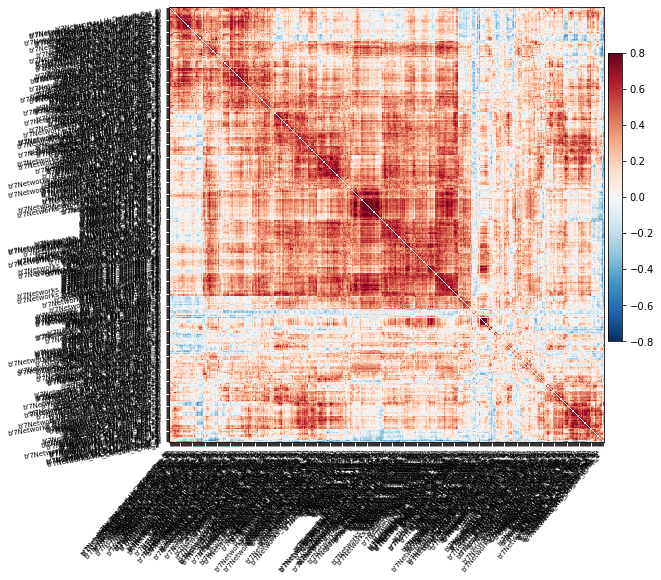

In [170]:
# Plot the connectivity/correlation matrix for the last subject that was computed in loop (remaining stored in variable)

print(f'Example functional connectivity matrix for subject {dir}')

# Mask the main diagonal for visualization:
np.fill_diagonal(corr_matrix, 0)

# matrices are ordered for block-like representation
plotting.plot_matrix(corr_matrix, 
                     figure = (10, 8),  
                     labels = schaefer400_labels,
                     vmax = 0.8, vmin = -0.8, 
                     #title = "",
                     reorder = True)

# '*RESUME HERE:*' thing from Amin's part
- need to check on Felix's Jülich scripts (https://jugit.fz-juelich.de/f.hoffstaedter/bids_pipelines/-/tree/master/func) what mm resolution the normalization to mni was done (if indeed 1 mm) -> or what does this parameter really refer to? "spatial resolution of atlas image"? I think this means rather the end goal, but don't really know why I would have to chose if the number of parcels are already given? I also don't know what the spatial resolution of atlas used for hcp data is (maybe ask bin) https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_atlas_schaefer_2018.html#nilearn.datasets.fetch_atlas_schaefer_2018 

# CONFOUNDS
what to do?

In [43]:
reduced_confounds

'/data/hu_serio/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'

# HOW TO CHECK THAT IT'S CORRECT?
- ask amin?
- also understand how the timeseries is yielded
- aslo understand how the fc matrix is yielded from the timeseries

# CAN DELETE

## Amin's solution

### Problematic solution (following my question)

In [8]:
img = nib.load('/data/p_02667/sex_diff_gradients/data/GSP/sub-0001/ses-01/wsub-0001_ses-01.nii.gz')
img_4d = img.get_fdata()
n_TRs = img_4d.shape[-1]
img_2d = np.reshape(img_4d, (-1, n_TRs))

In [9]:
img_4d.shape

(91, 109, 91, 120)

In [10]:
img_2d.shape

(902629, 120)

But, beware that it’s possible that the reshape function don’t exactly behave as we want it to behave. I mean it is going to give you the data in the correct shape, but I’m not sure if in the output each row corresponds to a voxel. So double check this. Maybe by seeing if img_4d[0, 0, 0, :] == img_2d[0, :] or something like this

In [11]:
img_4d[0, 0, 0, :] == img_2d[0, :]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

**B: Problem is that it reshapes whilst still including all the zeros -> would have to remove the zeros (or arrays containing at least one zero?) before running the reshape function**

explained here why zeros: https://ohba-analysis.github.io/osl-docs/matlab/osl_example_parcellation.html

### More reliable solution

And if you want to do this just for parcellation, I think nilearn parcellation function should work okay with 4d data

https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html#extract-signals-on-a-parcellation-defined-by-labels


Retrieve Schaefer atals and data for single subject

In [87]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
#dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=1)

########### resume here going through
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of brain development fmri data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
fmri_filenames = data.func[0]
reduced_confounds = data.confounds[0]  # This is a preselected set of confounds


Dataset created in /data/hu_serio/nilearn_data/fsl



Downloaded 23609344 of 25716861 bytes (91.8%,    0.3s remaining) ...done. (4 seconds, 0 min)
Extracting data from /data/hu_serio/nilearn_data/fsl/245b1ae3f43e3ea47e2ed9f438694f4a/HarvardOxford.tgz...

Atlas ROIs are located in nifti image (4D) at: <class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform

.. done.


In [88]:
data

{'func': ['/data/hu_serio/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
 'confounds': ['/data/hu_serio/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'],
 'phenotypic': array([('sub-pixar123', 27.06, 'Adult', 'adult', 'F', 'R')],
       dtype=[('participant_id', '<U12'), ('Age', '<f8'), ('AgeGroup', '<U6'), ('Child_Adult', '<U5'), ('Gender', '<U4'), ('Handedness', '<U4')]),
 'description': "The movie watching based brain development dataset (fMRI)\n\n\nNotes\n-----\nThis functional MRI dataset is used for teaching how to use\nmachine learning to predict age from naturalistic stimuli (movie)\nwatching with Nilearn.\n\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\n18-39). This dataset can be used to try to predict who are adults and\nwho are children.\n\nThe data is downsampled to 4mm resolution for convenience. The origin

#### **RESUME HERE:**
- need to check on Felix's Jülich scripts (https://jugit.fz-juelich.de/f.hoffstaedter/bids_pipelines/-/tree/master/func) what mm resolution the normalization to mni was done (if indeed 1 mm) -> or what does this parameter really refer to? "spatial resolution of atlas image"? I think this means rather the end goal, but don't really know why I would have to chose if the number of parcels are already given? I also don't know what the spatial resolution of atlas used for hcp data is (maybe ask bin) https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_atlas_schaefer_2018.html#nilearn.datasets.fetch_atlas_schaefer_2018 

In [89]:
atlas_filename

In [90]:
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(fmri_filenames, confounds=reduced_confounds)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/hu_serio/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7fd10448e8e0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape':

In [91]:
time_series

array([[ 1.75012633e+00,  1.30194325e-01,  1.44863357e+00, ...,
        -1.62235977e+00, -2.96943314e+00, -3.48192217e-01],
       [ 1.16876412e+00, -2.42748037e-01,  1.06252259e+00, ...,
        -1.46706283e+00, -5.03220005e-01, -4.48284989e-01],
       [-2.80299577e-03, -1.30247450e+00,  5.61293651e-01, ...,
        -1.19811500e+00,  4.15776129e-01, -2.98573256e-01],
       ...,
       [ 5.54901441e-01,  2.26854952e-01,  5.34985328e-01, ...,
        -2.59779160e-01,  1.82636219e+00, -2.16022237e+00],
       [ 5.46080114e-01, -1.06991807e+00,  2.24077160e-01, ...,
        -6.99255482e-01,  2.27062003e+00, -1.34721042e+00],
       [ 1.34501909e+00,  1.89411823e-01,  7.77552247e-01, ...,
        -2.14489736e-02,  1.22599054e+00, -2.05496972e+00]])

In [92]:
time_series.shape

(168, 48)

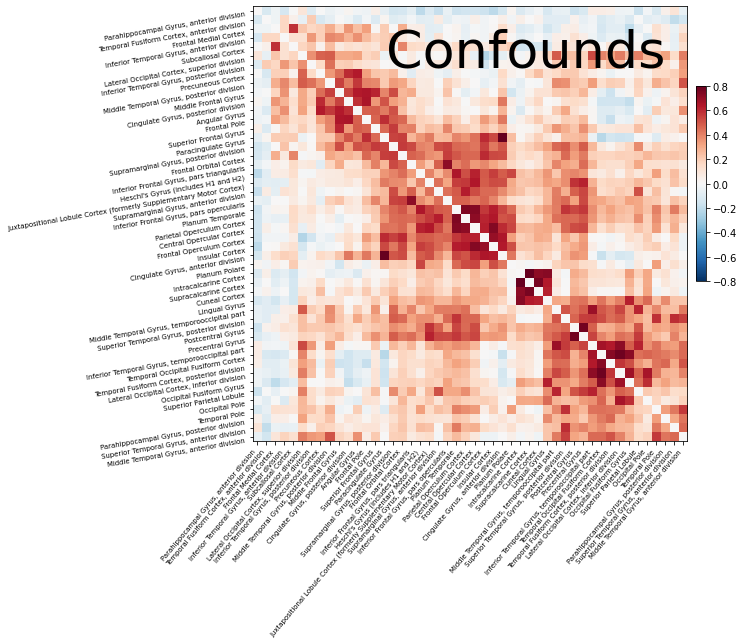

In [93]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, title="Confounds",
                     reorder=True)

## single subject code used to make code for loop

### Extract signals Schaefer parcellation defined by labels

https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html#extract-signals-on-a-parcellation-defined-by-labels

In [139]:
# make a masker based on the retrieved Schaefer atlas
masker = NiftiLabelsMasker(labels_img=schaefer400_atlas_filename, standardize=True, memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy array. Note how we give confounds to be regressed out during signal extraction
time_series = masker.fit_transform(path_example_sub)
                                   #, confounds=reduced_confounds)

[NiftiLabelsMasker.fit_transform] loading data from /data/hu_serio/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [141]:
time_series.shape  # time * parcels

(120, 400)

### Compute and display a correlation matrix

In [142]:
# compute connectivity matrix from timeseries (fit transforming timeseries data (time*parcels) with connectivity measure (correlation)
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

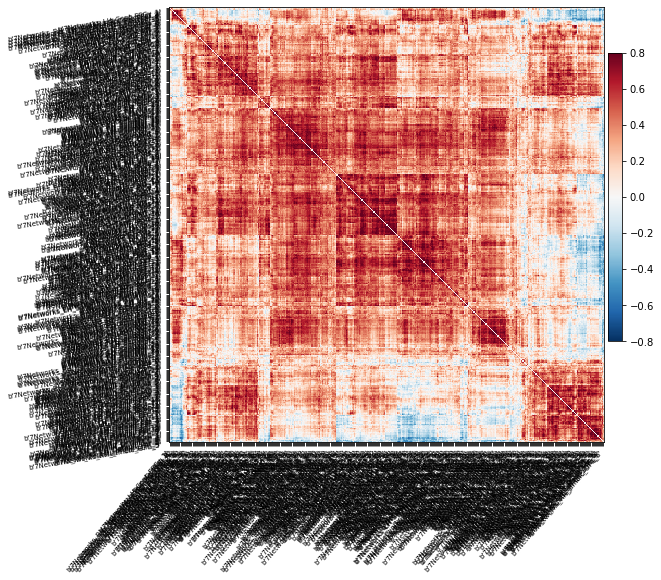

In [144]:
# Plot the correlation matrix

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, 
                     figure=(10, 8),  
                     labels=schaefer400_labels,
                     vmax=0.8, vmin=-0.8, 
                     #title="",
                     reorder=True)

In [75]:
correlation_matrix.shape

(400, 400)

## HCP

In [22]:
# load image
img = nib.load('/data/p_02378/data/hcp_rsfunc/HCP_S1200_rfMRI_DAY1/100206/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii')

# get data from image (.shape = time * voxels)
data = img.get_fdata()

# parcellate
data_parc = hcp.parcellate(data, hcp.mmp)
data_sub = data_parc[:,360:]  # this is the subcortical regions parcels: include if you want 419x419 matrices

img_cortex = data[:,hcp.struct.cortex] # cortex vertices
node = [None]*400 # data_sub.shape[0] is time points. not all data has 1200 ts

for i in range(400):
    a = img_cortex[:,np.where(schaefer_400==i+1)][:,0]
    ts = [None] * data_sub.shape[0]

    for n in range(data_sub.shape[0]):
        ts[n] = a[n].mean()
        node[i] = ts

# cortex parcels finished, now concatenate cortex and subcortex
data_cor = np.array(node)

# if you want matrices to include cortical and subcortical regions parcels, concatenate them here (so that in 419x419 matrices, the last 19 are subcortical parcels)
#data_cor_sub = np.concatenate((data_cor,data_sub.T))  

# correlation
corr_matrix = np.corrcoef(data_cor)   # use data_cor_sub if I want to include subcortical areas to yield 419x419 matrices
corr_matrix[corr_matrix>0.99999]=1  # if 0.99999 make it 1 - for some unknown reason some correlations of same parcels are not round 1 so forcing it into 1

# # save
# fname_corr_matrix = dataout + 'DAY2_LR/corr/'+ dir +'.csv'
# np.savetxt(fname_corr_matrix, corr_matrix, delimiter = ',')
# print('finished subject: '+dir+'......')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [20]:
img.shape

(1200, 91282)

In [18]:
data.shape

(1200, 91282)

In [14]:
corr_matrix

array([[ 1.        ,  0.21206672,  0.30397693, ...,  0.03608577,
         0.10077801,  0.13402924],
       [ 0.21206672,  1.        ,  0.06122822, ..., -0.02746152,
         0.05770127,  0.0964711 ],
       [ 0.30397693,  0.06122822,  1.        , ...,  0.07584439,
         0.02916188,  0.15275443],
       ...,
       [ 0.03608577, -0.02746152,  0.07584439, ...,  1.        ,
         0.19711161,  0.2018973 ],
       [ 0.10077801,  0.05770127,  0.02916188, ...,  0.19711161,
         1.        ,  0.29811333],
       [ 0.13402924,  0.0964711 ,  0.15275443, ...,  0.2018973 ,
         0.29811333,  1.        ]])

In [16]:
corr_matrix.shape

(400, 400)

# ORIGINAL CODE STILL TO EDIT

## Define directories

In [ ]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir_day2 = '/data/p_02378/data/hcp_rsfunc/hcp-functional-connectivity/'

datadir_day1 = '/data/p_02378/data/hcp_rsfunc/HCP_S1200_rfMRI_DAY1/'

dataout = '/data/p_02667/sex_diff_gradients/data/fc_matrices/schaefer_output/'

In [ ]:
path_list = os.listdir(datadir_day2)
path_list.sort()

## Loading Schaefer 400 atlas (7 network) and adapting it to HCP data

In [12]:
# Schaefer_400 - 7 networks
dlabel_400 = nib.load('/data/p_02667/sex_diff_gradients/data/schaefer400/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()

# fs_LR_32k is a standard brain surface (like MNI space) -> LR means the first 32k belong to left hemisphere, the second belong to right hemisphere
mat = scipy.io.loadmat('/data/p_02667/sex_diff_gradients/data/schaefer400/fs_LR_32k_medial_mask.mat')


# HCP cortex data does not contain medial_wall using python, we need to delete it in Schaefer template
mask = mat['medial_mask']
schaefer_400 = dlabel_400.T[np.where(mask==1)]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Bin´s instructions
- find the schaefer400 dlabel nii file (which is 64k (vertices?), cortex also 64k*1200 time series
- find cortex[schaefer==i] for i in range(400), then average
- then you get (400, 1200) ts
- then do np.corrcoef(ts) to get the correlation matrix
- But of note, some file contains medial wall (64k points) but some file excludes medial wall (59k points)

## Scan session day 2 - LR

In [5]:
# read the time series of scan session day 2, LR, ** rfMRI_REST2_LR **
# parcellate the time series to Glasser 360 (hcp.parcellate(data, hcp.mmp)) and then adapte it to Schaefer
# compute the functional connectivity matrix and save

for dir in path_list:
    if os.path.exists(datadir_day2+dir+'/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii'):
        print('executing subject: '+dir+'......')
        
        img = nib.load(datadir_day2+dir+'/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii')
        data = img.get_fdata()
        data_parc = hcp.parcellate(data, hcp.mmp)
        data_sub = data_parc[:,360:]  # this is the subcortical regions parcels: include if you want 419x419 matrices
        
        img_cortex = data[:,hcp.struct.cortex] # cortex vertices
        node = [None]*400 # data_sub.shape[0] is time points. not all data has 1200 ts
        
        for i in range(400):
            a = img_cortex[:,np.where(schaefer_400==i+1)][:,0]
            ts = [None] * data_sub.shape[0]
        
            for n in range(data_sub.shape[0]):
                ts[n] = a[n].mean()
                node[i] = ts
      
        # cortex parcels finished, now concatenate cortex and subcortex
        data_cor = np.array(node)
        
        # if you want matrices to include cortical and subcortical regions parcels, concatenate them here (so that in 419x419 matrices, the last 19 are subcortical parcels)
        #data_cor_sub = np.concatenate((data_cor,data_sub.T))  
        
        # correlation
        corr_matrix = np.corrcoef(data_cor)   # use data_cor_sub if I want to include subcortical areas to yield 419x419 matrices
        corr_matrix[corr_matrix>0.99999]=1  # if 0.99999 make it 1 - for some unknown reason some correlations of same parcels are not round 1 so forcing it into 1
        
        # save
        fname_corr_matrix = dataout + 'DAY2_LR/corr/'+ dir +'.csv'
        np.savetxt(fname_corr_matrix, corr_matrix, delimiter = ',')
        print('finished subject: '+dir+'......')
    
    else:
        fname_corr_matrix_failed = dataout + 'DAY2_LR/file_failed.txt'
        fail_file = open(fname_corr_matrix_failed, 'a')
        fail_file.write(dir+'\n')
        fail_file.close()
        print('subject '+dir+' file dose not exist.....')
        

subject .datalad file dose not exist.....
subject .git file dose not exist.....
subject .gitattributes file dose not exist.....
subject .gitmodules file dose not exist.....
subject .hcp file dose not exist.....
executing subject: 100206......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100206......
executing subject: 100307......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100307......
executing subject: 100408......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100408......
executing subject: 100610......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100610......
executing subject: 101006......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 101006......
executing subject: 101107......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 101107......
executing subject: 101309......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 101309......
subject 101410 file dose not exist.....
executing subject: 101915......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 101915......
executing subject: 102008......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102008......
executing subject: 102109......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102109......
executing subject: 102311......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102311......
executing subject: 102513......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102513......
executing subject: 102614......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102614......
executing subject: 102715......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102715......
executing subject: 102816......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 102816......
executing subject: 103010......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 103010......
executing subject: 103111......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 103111......
executing subject: 103212......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 103212......
executing subject: 103414......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 103414......
executing subject: 103515......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 103515......
executing subject: 103818......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 103818......
executing subject: 104012......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 104012......
executing subject: 104416......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 104416......
executing subject: 104820......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 104820......
executing subject: 105014......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 105014......
executing subject: 105115......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 105115......
executing subject: 105216......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 105216......
executing subject: 105620......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 105620......
executing subject: 105923......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 105923......
executing subject: 106016......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 106016......
executing subject: 106319......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 106319......
executing subject: 106521......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 106521......
executing subject: 106824......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 106824......
executing subject: 107018......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 107018......
subject 107220 file dose not exist.....
executing subject: 107321......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 107321......
executing subject: 107422......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 107422......
executing subject: 107725......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 107725......
executing subject: 108020......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 108020......
executing subject: 108121......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 108121......
executing subject: 108222......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 108222......
executing subject: 108323......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 108323......
executing subject: 108525......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 108525......
executing subject: 108828......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 108828......
executing subject: 109123......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 109123......
executing subject: 109325......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 109325......
executing subject: 109830......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 109830......
executing subject: 110007......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 110007......
executing subject: 110411......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 110411......
executing subject: 110613......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 110613......
executing subject: 111009......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 111009......
executing subject: 111211......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 111211......
executing subject: 111312......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 111312......
executing subject: 111413......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 111413......
executing subject: 111514......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 111514......
executing subject: 111716......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 111716......
executing subject: 112112......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 112112......
executing subject: 112314......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 112314......
executing subject: 112516......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 112516......
subject 112819 file dose not exist.....
executing subject: 112920......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 112920......
executing subject: 113215......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 113215......
executing subject: 113316......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 113316......
subject 113417 file dose not exist.....
executing subject: 113619......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 113619......
subject 113821 file dose not exist.....
executing subject: 113922......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 113922......
subject 114116 file dose not exist.....
executing subject: 114217......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 114217......
executing subject: 114318......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 114318......
executing subject: 114419......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 114419......
executing subject: 114621......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 114621......
executing subject: 114823......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 114823......
executing subject: 114924......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 114924......
executing subject: 115017......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 115017......
executing subject: 115219......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 115219......
executing subject: 115320......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 115320......
executing subject: 115724......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 115724......
executing subject: 115825......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 115825......
subject 116120 file dose not exist.....
executing subject: 116221......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 116221......
subject 116423 file dose not exist.....
executing subject: 116524......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 116524......
executing subject: 116726......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 116726......
executing subject: 117021......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 117021......
executing subject: 117122......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 117122......
executing subject: 117324......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 117324......
subject 117728 file dose not exist.....
executing subject: 117930......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 117930......
executing subject: 118023......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118023......
executing subject: 118124......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118124......
executing subject: 118225......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118225......
executing subject: 118528......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118528......
executing subject: 118730......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118730......
executing subject: 118831......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118831......
executing subject: 118932......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 118932......
executing subject: 119025......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 119025......
executing subject: 119126......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 119126......
executing subject: 119732......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 119732......
executing subject: 119833......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 119833......
subject 120010 file dose not exist.....
executing subject: 120111......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 120111......
executing subject: 120212......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 120212......
executing subject: 120414......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 120414......
executing subject: 120515......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 120515......
executing subject: 120717......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 120717......
subject 121315 file dose not exist.....
executing subject: 121416......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 121416......
executing subject: 121618......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 121618......
subject 121719 file dose not exist.....
subject 121820 file dose not exist.....
executing subject: 121921......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 121921......
executing subject: 122317......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 122317......
executing subject: 122418......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 122418......
executing subject: 122620......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 122620......
executing subject: 122822......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 122822......
executing subject: 123117......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 123117......
executing subject: 123420......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 123420......
executing subject: 123521......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 123521......
executing subject: 123723......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 123723......
executing subject: 123824......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 123824......
executing subject: 123925......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 123925......
executing subject: 124220......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 124220......
executing subject: 124422......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 124422......
executing subject: 124624......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 124624......
executing subject: 124826......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 124826......
executing subject: 125222......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 125222......
executing subject: 125424......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 125424......
executing subject: 125525......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 125525......
executing subject: 126325......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 126325......
executing subject: 126426......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 126426......
executing subject: 126628......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 126628......
subject 126931 file dose not exist.....
executing subject: 127226......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 127226......
executing subject: 127327......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 127327......
executing subject: 127630......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 127630......
executing subject: 127731......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 127731......
executing subject: 127832......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 127832......
executing subject: 127933......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 127933......
executing subject: 128026......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 128026......
executing subject: 128127......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 128127......
subject 128329 file dose not exist.....
executing subject: 128632......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 128632......
executing subject: 128935......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 128935......
executing subject: 129028......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 129028......
executing subject: 129129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 129129......
executing subject: 129331......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 129331......
subject 129432 file dose not exist.....
subject 129533 file dose not exist.....
executing subject: 129634......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 129634......
executing subject: 129937......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 129937......
executing subject: 130013......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130013......
executing subject: 130114......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130114......
executing subject: 130316......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130316......
executing subject: 130417......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130417......
executing subject: 130518......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130518......
executing subject: 130619......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130619......
executing subject: 130720......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130720......
executing subject: 130821......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130821......
executing subject: 130922......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 130922......
executing subject: 131217......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 131217......
executing subject: 131419......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 131419......
subject 131621 file dose not exist.....
executing subject: 131722......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 131722......
executing subject: 131823......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 131823......
executing subject: 131924......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 131924......
executing subject: 132017......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 132017......
executing subject: 132118......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 132118......
executing subject: 133019......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 133019......
executing subject: 133625......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 133625......
executing subject: 133827......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 133827......
executing subject: 133928......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 133928......
executing subject: 134021......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134021......
executing subject: 134223......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134223......
executing subject: 134324......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134324......
executing subject: 134425......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134425......
executing subject: 134627......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134627......
executing subject: 134728......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134728......
executing subject: 134829......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 134829......
executing subject: 135124......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 135124......
executing subject: 135225......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 135225......
executing subject: 135528......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 135528......
executing subject: 135629......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 135629......
executing subject: 135730......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 135730......
executing subject: 135932......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 135932......
executing subject: 136126......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 136126......
executing subject: 136227......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 136227......
executing subject: 136631......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 136631......
executing subject: 136732......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 136732......
executing subject: 136833......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 136833......
executing subject: 137027......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137027......
executing subject: 137128......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137128......
executing subject: 137229......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137229......
executing subject: 137431......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137431......
executing subject: 137532......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137532......
executing subject: 137633......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137633......
executing subject: 137936......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 137936......
executing subject: 138130......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 138130......
executing subject: 138231......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 138231......
executing subject: 138332......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 138332......
executing subject: 138534......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 138534......
executing subject: 138837......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 138837......
executing subject: 139233......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 139233......
executing subject: 139435......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 139435......
executing subject: 139637......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 139637......
executing subject: 139839......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 139839......
executing subject: 140117......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 140117......
executing subject: 140319......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 140319......
executing subject: 140420......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 140420......
executing subject: 140824......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 140824......
executing subject: 140925......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 140925......
executing subject: 141119......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 141119......
executing subject: 141422......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 141422......
executing subject: 141826......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 141826......
subject 142424 file dose not exist.....
executing subject: 142828......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 142828......
executing subject: 143224......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 143224......
executing subject: 143325......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 143325......
executing subject: 143426......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 143426......
subject 143527 file dose not exist.....
executing subject: 143830......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 143830......
executing subject: 144125......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 144125......
executing subject: 144226......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 144226......
executing subject: 144428......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 144428......
executing subject: 144731......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 144731......
executing subject: 144832......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 144832......
executing subject: 144933......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 144933......
executing subject: 145127......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 145127......
subject 145531 file dose not exist.....
executing subject: 145632......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 145632......
executing subject: 145834......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 145834......
executing subject: 146129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146129......
executing subject: 146331......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146331......
executing subject: 146432......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146432......
executing subject: 146533......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146533......
subject 146634 file dose not exist.....
executing subject: 146735......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146735......
executing subject: 146836......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146836......
executing subject: 146937......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 146937......
executing subject: 147030......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 147030......
executing subject: 147636......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 147636......
executing subject: 147737......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 147737......
executing subject: 148032......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 148032......
executing subject: 148133......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 148133......
executing subject: 148335......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 148335......
executing subject: 148436......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 148436......
executing subject: 148840......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 148840......
executing subject: 148941......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 148941......
executing subject: 149236......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 149236......
executing subject: 149337......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 149337......
executing subject: 149539......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 149539......
executing subject: 149741......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 149741......
executing subject: 149842......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 149842......
subject 150019 file dose not exist.....
executing subject: 150423......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 150423......
subject 150524 file dose not exist.....
executing subject: 150625......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 150625......
executing subject: 150726......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 150726......
subject 150928 file dose not exist.....
subject 151021 file dose not exist.....
executing subject: 151223......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151223......
executing subject: 151324......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151324......
executing subject: 151425......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151425......
executing subject: 151526......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151526......
executing subject: 151627......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151627......
executing subject: 151728......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151728......
executing subject: 151829......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151829......
executing subject: 151930......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 151930......
executing subject: 152225......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 152225......
executing subject: 152427......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 152427......
executing subject: 152831......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 152831......
executing subject: 153025......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153025......
executing subject: 153126......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153126......
executing subject: 153227......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153227......
executing subject: 153429......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153429......
executing subject: 153631......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153631......
executing subject: 153732......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153732......
executing subject: 153833......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153833......
executing subject: 153934......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 153934......
executing subject: 154229......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154229......
executing subject: 154330......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154330......
executing subject: 154431......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154431......
executing subject: 154532......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154532......
executing subject: 154734......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154734......
executing subject: 154835......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154835......
executing subject: 154936......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 154936......
subject 155231 file dose not exist.....
executing subject: 155635......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 155635......
executing subject: 155938......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 155938......
executing subject: 156031......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 156031......
executing subject: 156233......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 156233......
executing subject: 156334......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 156334......
executing subject: 156435......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 156435......
executing subject: 156536......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 156536......
executing subject: 156637......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 156637......
executing subject: 157336......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 157336......
executing subject: 157437......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 157437......
executing subject: 157942......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 157942......
executing subject: 158035......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 158035......
executing subject: 158136......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 158136......
executing subject: 158338......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 158338......
executing subject: 158540......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 158540......
executing subject: 158843......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 158843......
executing subject: 159138......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 159138......
executing subject: 159239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 159239......
executing subject: 159340......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 159340......
executing subject: 159441......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 159441......
executing subject: 159744......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 159744......
subject 159845 file dose not exist.....
executing subject: 159946......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 159946......
executing subject: 160123......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 160123......
executing subject: 160729......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 160729......
executing subject: 160830......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 160830......
executing subject: 160931......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 160931......
executing subject: 161327......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 161327......
executing subject: 161630......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 161630......
executing subject: 161731......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 161731......
executing subject: 161832......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 161832......
executing subject: 162026......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 162026......
executing subject: 162228......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 162228......
executing subject: 162329......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 162329......
executing subject: 162733......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 162733......
executing subject: 162935......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 162935......
executing subject: 163129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 163129......
executing subject: 163331......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 163331......
executing subject: 163432......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 163432......
executing subject: 163836......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 163836......
executing subject: 164030......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 164030......
executing subject: 164131......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 164131......
executing subject: 164636......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 164636......
executing subject: 164939......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 164939......
executing subject: 165032......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 165032......
subject 165234 file dose not exist.....
executing subject: 165436......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 165436......
executing subject: 165638......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 165638......
executing subject: 165840......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 165840......
executing subject: 165941......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 165941......
executing subject: 166438......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 166438......
executing subject: 166640......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 166640......
executing subject: 167036......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 167036......
executing subject: 167238......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 167238......
executing subject: 167440......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 167440......
executing subject: 167743......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 167743......
subject 168038 file dose not exist.....
executing subject: 168139......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 168139......
executing subject: 168240......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 168240......
executing subject: 168341......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 168341......
executing subject: 168745......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 168745......
executing subject: 168947......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 168947......
executing subject: 169040......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 169040......
subject 169141 file dose not exist.....
executing subject: 169343......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 169343......
executing subject: 169444......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 169444......
executing subject: 169545......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 169545......
executing subject: 169747......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 169747......
executing subject: 169949......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 169949......
executing subject: 170631......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 170631......
subject 170934 file dose not exist.....
subject 171128 file dose not exist.....
executing subject: 171330......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 171330......
executing subject: 171431......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 171431......
executing subject: 171532......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 171532......
executing subject: 171633......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 171633......
subject 171734 file dose not exist.....
executing subject: 172029......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 172029......
executing subject: 172130......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 172130......
executing subject: 172332......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 172332......
executing subject: 172433......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 172433......
executing subject: 172534......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 172534......
subject 172635 file dose not exist.....
executing subject: 172938......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 172938......
subject 173132 file dose not exist.....
subject 173233 file dose not exist.....
executing subject: 173334......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173334......
executing subject: 173435......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173435......
executing subject: 173536......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173536......
executing subject: 173637......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173637......
executing subject: 173738......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173738......
executing subject: 173839......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173839......
executing subject: 173940......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 173940......
executing subject: 174437......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 174437......
executing subject: 174841......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 174841......
executing subject: 175035......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175035......
executing subject: 175136......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175136......
executing subject: 175237......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175237......
executing subject: 175338......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175338......
executing subject: 175439......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175439......
executing subject: 175540......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175540......
executing subject: 175742......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 175742......
executing subject: 176037......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 176037......
executing subject: 176239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 176239......
executing subject: 176441......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 176441......
executing subject: 176542......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 176542......
executing subject: 176744......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 176744......
executing subject: 176845......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 176845......
executing subject: 177140......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 177140......
executing subject: 177241......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 177241......
subject 177342 file dose not exist.....
executing subject: 177645......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 177645......
executing subject: 177746......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 177746......
executing subject: 178142......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 178142......
executing subject: 178243......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 178243......
executing subject: 178647......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 178647......
executing subject: 178748......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 178748......
executing subject: 178849......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 178849......
executing subject: 178950......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 178950......
executing subject: 179245......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 179245......
executing subject: 179346......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 179346......
subject 179548 file dose not exist.....
subject 179952 file dose not exist.....
executing subject: 180129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180129......
executing subject: 180230......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180230......
executing subject: 180432......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180432......
executing subject: 180533......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180533......
executing subject: 180735......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180735......
executing subject: 180836......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180836......
executing subject: 180937......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 180937......
executing subject: 181131......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 181131......
executing subject: 181232......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 181232......
executing subject: 181636......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 181636......
executing subject: 182032......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 182032......
executing subject: 182436......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 182436......
executing subject: 182739......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 182739......
executing subject: 182840......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 182840......
executing subject: 183034......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 183034......
executing subject: 183337......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 183337......
subject 183741 file dose not exist.....
executing subject: 185038......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 185038......
executing subject: 185139......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 185139......
executing subject: 185341......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 185341......
executing subject: 185442......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 185442......
executing subject: 185846......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 185846......
executing subject: 185947......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 185947......
executing subject: 186040......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 186040......
executing subject: 186141......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 186141......
executing subject: 186444......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 186444......
executing subject: 186545......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 186545......
executing subject: 186848......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 186848......
subject 186949 file dose not exist.....
executing subject: 187143......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 187143......
executing subject: 187345......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 187345......
executing subject: 187547......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 187547......
executing subject: 187850......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 187850......
executing subject: 188145......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 188145......
executing subject: 188347......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 188347......
executing subject: 188448......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 188448......
executing subject: 188549......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 188549......
executing subject: 188751......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 188751......
executing subject: 189349......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 189349......
executing subject: 189450......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 189450......
executing subject: 189652......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 189652......
executing subject: 190031......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 190031......
subject 190132 file dose not exist.....
executing subject: 191033......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 191033......
executing subject: 191235......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 191235......
executing subject: 191336......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 191336......
executing subject: 191437......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 191437......
executing subject: 191841......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 191841......
executing subject: 191942......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 191942......
executing subject: 192035......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192035......
executing subject: 192136......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192136......
executing subject: 192237......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192237......
executing subject: 192439......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192439......
executing subject: 192540......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192540......
executing subject: 192641......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192641......
executing subject: 192843......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 192843......
executing subject: 193239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 193239......
subject 193441 file dose not exist.....
executing subject: 193845......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 193845......
executing subject: 194140......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 194140......
executing subject: 194443......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 194443......
executing subject: 194645......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 194645......
executing subject: 194746......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 194746......
executing subject: 194847......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 194847......
executing subject: 195041......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 195041......
executing subject: 195445......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 195445......
executing subject: 195647......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 195647......
executing subject: 195849......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 195849......
executing subject: 195950......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 195950......
executing subject: 196144......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 196144......
executing subject: 196346......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 196346......
executing subject: 196750......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 196750......
subject 196851 file dose not exist.....
executing subject: 196952......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 196952......
executing subject: 197348......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 197348......
subject 197449 file dose not exist.....
executing subject: 197550......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 197550......
subject 197651 file dose not exist.....
executing subject: 198047......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 198047......
executing subject: 198249......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 198249......
executing subject: 198350......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 198350......
executing subject: 198451......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 198451......
executing subject: 198653......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 198653......
executing subject: 198855......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 198855......
executing subject: 199150......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 199150......
executing subject: 199251......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 199251......
executing subject: 199352......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 199352......
executing subject: 199453......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 199453......
executing subject: 199655......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 199655......
executing subject: 199958......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 199958......
executing subject: 200008......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 200008......
subject 200109 file dose not exist.....
subject 200210 file dose not exist.....
executing subject: 200311......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 200311......
executing subject: 200513......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 200513......
executing subject: 200614......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 200614......
executing subject: 200917......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 200917......
executing subject: 201111......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 201111......
executing subject: 201414......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 201414......
executing subject: 201515......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 201515......
subject 201717 file dose not exist.....
executing subject: 201818......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 201818......
executing subject: 202113......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 202113......
executing subject: 202719......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 202719......
executing subject: 202820......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 202820......
executing subject: 203418......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 203418......
subject 203721 file dose not exist.....
executing subject: 203923......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 203923......
executing subject: 204016......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 204016......
executing subject: 204218......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 204218......
executing subject: 204319......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 204319......
executing subject: 204420......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 204420......
executing subject: 204521......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 204521......
executing subject: 204622......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 204622......
executing subject: 205119......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 205119......
executing subject: 205220......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 205220......
executing subject: 205725......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 205725......
executing subject: 205826......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 205826......
executing subject: 206222......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 206222......
executing subject: 206323......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 206323......
executing subject: 206525......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 206525......
executing subject: 206727......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 206727......
executing subject: 206828......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 206828......
executing subject: 206929......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 206929......
executing subject: 207123......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 207123......
executing subject: 207426......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 207426......
subject 207628 file dose not exist.....
executing subject: 208024......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 208024......
executing subject: 208125......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 208125......
executing subject: 208226......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 208226......
executing subject: 208327......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 208327......
subject 208428 file dose not exist.....
executing subject: 208630......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 208630......
executing subject: 209127......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 209127......
executing subject: 209228......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 209228......
executing subject: 209329......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 209329......
subject 209531 file dose not exist.....
executing subject: 209834......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 209834......
executing subject: 209935......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 209935......
executing subject: 210011......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 210011......
executing subject: 210112......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 210112......
executing subject: 210415......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 210415......
executing subject: 210617......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 210617......
executing subject: 211114......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211114......
executing subject: 211215......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211215......
executing subject: 211316......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211316......
executing subject: 211417......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211417......
executing subject: 211619......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211619......
executing subject: 211720......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211720......
executing subject: 211821......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211821......
executing subject: 211922......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 211922......
executing subject: 212015......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 212015......
executing subject: 212116......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 212116......
executing subject: 212217......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 212217......
executing subject: 212318......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 212318......
executing subject: 212419......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 212419......
executing subject: 212823......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 212823......
executing subject: 213017......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 213017......
executing subject: 213421......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 213421......
executing subject: 213522......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 213522......
executing subject: 214019......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 214019......
executing subject: 214221......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 214221......
executing subject: 214423......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 214423......
executing subject: 214524......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 214524......
executing subject: 214625......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 214625......
executing subject: 214726......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 214726......
executing subject: 217126......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 217126......
executing subject: 217429......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 217429......
executing subject: 219231......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 219231......
executing subject: 220721......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 220721......
subject 221218 file dose not exist.....
executing subject: 221319......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 221319......
executing subject: 223929......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 223929......
executing subject: 224022......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 224022......
executing subject: 227432......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 227432......
executing subject: 227533......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 227533......
executing subject: 228434......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 228434......
executing subject: 231928......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 231928......
executing subject: 233326......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 233326......
executing subject: 236130......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 236130......
executing subject: 237334......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 237334......
executing subject: 238033......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 238033......
executing subject: 239136......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 239136......
executing subject: 239944......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 239944......
executing subject: 245333......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 245333......
executing subject: 246133......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 246133......
subject 248238 file dose not exist.....
executing subject: 248339......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 248339......
executing subject: 249947......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 249947......
executing subject: 250427......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 250427......
executing subject: 250932......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 250932......
executing subject: 251833......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 251833......
executing subject: 255639......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 255639......
executing subject: 255740......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 255740......
executing subject: 256540......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 256540......
executing subject: 257542......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 257542......
executing subject: 257845......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 257845......
executing subject: 257946......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 257946......
executing subject: 263436......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 263436......
executing subject: 268749......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 268749......
executing subject: 268850......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 268850......
executing subject: 270332......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 270332......
executing subject: 274542......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 274542......
executing subject: 275645......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 275645......
executing subject: 280739......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 280739......
executing subject: 280941......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 280941......
executing subject: 281135......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 281135......
executing subject: 283543......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 283543......
executing subject: 284646......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 284646......
executing subject: 285345......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 285345......
executing subject: 285446......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 285446......
executing subject: 286347......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 286347......
executing subject: 286650......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 286650......
executing subject: 287248......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 287248......
executing subject: 289555......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 289555......
executing subject: 290136......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 290136......
executing subject: 293748......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 293748......
executing subject: 295146......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 295146......
executing subject: 297655......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 297655......
executing subject: 298051......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 298051......
executing subject: 298455......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 298455......
executing subject: 299154......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 299154......
executing subject: 299760......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 299760......
executing subject: 300618......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 300618......
executing subject: 300719......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 300719......
executing subject: 303119......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 303119......
executing subject: 303624......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 303624......
executing subject: 304020......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 304020......
executing subject: 304727......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 304727......
executing subject: 305830......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 305830......
executing subject: 307127......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 307127......
executing subject: 308129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 308129......
executing subject: 308331......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 308331......
executing subject: 309636......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 309636......
executing subject: 310621......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 310621......
executing subject: 311320......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 311320......
executing subject: 314225......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 314225......
executing subject: 316633......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 316633......
executing subject: 316835......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 316835......
executing subject: 317332......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 317332......
executing subject: 318637......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 318637......
executing subject: 320826......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 320826......
executing subject: 321323......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 321323......
executing subject: 322224......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 322224......
executing subject: 325129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 325129......
executing subject: 329440......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 329440......
executing subject: 329844......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 329844......
executing subject: 330324......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 330324......
executing subject: 333330......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 333330......
executing subject: 334635......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 334635......
executing subject: 336841......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 336841......
executing subject: 339847......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 339847......
executing subject: 341834......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 341834......
executing subject: 342129......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 342129......
executing subject: 346137......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 346137......
executing subject: 346945......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 346945......
executing subject: 348545......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 348545......
executing subject: 349244......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 349244......
executing subject: 350330......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 350330......
executing subject: 351938......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 351938......
executing subject: 352132......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 352132......
executing subject: 352738......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 352738......
executing subject: 353740......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 353740......
subject 355239 file dose not exist.....
subject 355542 file dose not exist.....
subject 355845 file dose not exist.....
executing subject: 356948......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 356948......
executing subject: 358144......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 358144......
executing subject: 360030......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 360030......
executing subject: 361234......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 361234......
executing subject: 361941......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 361941......
subject 362034 file dose not exist.....
executing subject: 365343......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 365343......
executing subject: 366042......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 366042......
executing subject: 366446......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 366446......
executing subject: 368551......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 368551......
executing subject: 368753......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 368753......
executing subject: 371843......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 371843......
executing subject: 376247......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 376247......
executing subject: 377451......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 377451......
executing subject: 378756......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 378756......
executing subject: 378857......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 378857......
executing subject: 379657......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 379657......
executing subject: 380036......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 380036......
executing subject: 381038......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 381038......
executing subject: 381543......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 381543......
executing subject: 382242......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 382242......
executing subject: 385046......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 385046......
executing subject: 385450......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 385450......
executing subject: 386250......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 386250......
executing subject: 387959......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 387959......
executing subject: 389357......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 389357......
executing subject: 390645......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 390645......
executing subject: 391748......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 391748......
executing subject: 392447......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 392447......
executing subject: 392750......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 392750......
executing subject: 393247......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 393247......
executing subject: 393550......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 393550......
executing subject: 394956......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 394956......
executing subject: 395251......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 395251......
executing subject: 395756......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 395756......
executing subject: 395958......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 395958......
executing subject: 397154......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 397154......
executing subject: 397760......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 397760......
executing subject: 397861......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 397861......
executing subject: 401422......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 401422......
executing subject: 406432......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 406432......
executing subject: 406836......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 406836......
executing subject: 412528......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 412528......
executing subject: 413934......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 413934......
executing subject: 414229......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 414229......
executing subject: 415837......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 415837......
executing subject: 419239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 419239......
executing subject: 421226......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 421226......
executing subject: 422632......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 422632......
executing subject: 424939......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 424939......
executing subject: 429040......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 429040......
executing subject: 432332......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 432332......
executing subject: 433839......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 433839......
executing subject: 436239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 436239......
executing subject: 436845......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 436845......
executing subject: 441939......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 441939......
executing subject: 445543......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 445543......
executing subject: 448347......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 448347......
executing subject: 449753......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 449753......
executing subject: 453441......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 453441......
executing subject: 453542......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 453542......
executing subject: 454140......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 454140......
executing subject: 456346......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 456346......
executing subject: 459453......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 459453......
executing subject: 461743......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 461743......
executing subject: 462139......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 462139......
executing subject: 463040......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 463040......
executing subject: 465852......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 465852......
executing subject: 467351......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 467351......
executing subject: 468050......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 468050......
executing subject: 469961......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 469961......
executing subject: 473952......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 473952......
executing subject: 475855......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 475855......
executing subject: 479762......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 479762......
executing subject: 480141......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 480141......
executing subject: 481042......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 481042......
executing subject: 481951......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 481951......
executing subject: 485757......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 485757......
executing subject: 486759......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 486759......
subject 492754 file dose not exist.....
executing subject: 495255......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 495255......
executing subject: 497865......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 497865......
executing subject: 499566......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 499566......
executing subject: 500222......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 500222......
executing subject: 506234......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 506234......
executing subject: 510225......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 510225......
executing subject: 510326......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 510326......
executing subject: 512835......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 512835......
executing subject: 513130......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 513130......
executing subject: 513736......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 513736......
executing subject: 516742......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 516742......
executing subject: 517239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 517239......
executing subject: 518746......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 518746......
executing subject: 519647......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 519647......
executing subject: 519950......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 519950......
executing subject: 520228......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 520228......
subject 521331 file dose not exist.....
executing subject: 522434......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 522434......
executing subject: 523032......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 523032......
executing subject: 524135......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 524135......
executing subject: 525541......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 525541......
executing subject: 529549......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 529549......
executing subject: 529953......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 529953......
executing subject: 530635......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 530635......
executing subject: 531536......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 531536......
executing subject: 531940......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 531940......
executing subject: 536647......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 536647......
executing subject: 540436......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 540436......
executing subject: 541640......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 541640......
executing subject: 541943......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 541943......
executing subject: 545345......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 545345......
executing subject: 547046......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 547046......
executing subject: 548250......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 548250......
executing subject: 549757......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 549757......
subject 550439 file dose not exist.....
executing subject: 552241......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 552241......
executing subject: 552544......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 552544......
executing subject: 553344......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 553344......
executing subject: 555348......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 555348......
executing subject: 555651......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 555651......
executing subject: 555954......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 555954......
executing subject: 557857......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 557857......
executing subject: 558657......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 558657......
executing subject: 558960......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 558960......
executing subject: 559053......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 559053......
executing subject: 559457......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 559457......
executing subject: 561242......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 561242......
executing subject: 561444......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 561444......
executing subject: 561949......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 561949......
executing subject: 562345......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 562345......
executing subject: 562446......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 562446......
executing subject: 565452......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 565452......
executing subject: 566454......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 566454......
executing subject: 567052......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 567052......
executing subject: 567759......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 567759......
executing subject: 567961......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 567961......
executing subject: 568963......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 568963......
executing subject: 569965......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 569965......
executing subject: 570243......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 570243......
executing subject: 571144......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 571144......
subject 571548 file dose not exist.....
executing subject: 572045......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 572045......
executing subject: 573249......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 573249......
executing subject: 573451......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 573451......
executing subject: 576255......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 576255......
executing subject: 578057......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 578057......
subject 578158 file dose not exist.....
executing subject: 579665......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 579665......
executing subject: 579867......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 579867......
executing subject: 580044......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 580044......
executing subject: 580347......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 580347......
executing subject: 580650......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 580650......
executing subject: 580751......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 580751......
executing subject: 581349......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 581349......
executing subject: 581450......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 581450......
executing subject: 583858......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 583858......
subject 584355 file dose not exist.....
executing subject: 585256......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 585256......
executing subject: 585862......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 585862......
executing subject: 586460......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 586460......
executing subject: 587664......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 587664......
executing subject: 588565......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 588565......
executing subject: 589567......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 589567......
executing subject: 590047......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 590047......
executing subject: 592455......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 592455......
executing subject: 594156......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 594156......
executing subject: 597869......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 597869......
executing subject: 598568......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 598568......
executing subject: 599065......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 599065......
executing subject: 599469......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 599469......
executing subject: 599671......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 599671......
executing subject: 601127......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 601127......
executing subject: 604537......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 604537......
executing subject: 609143......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 609143......
subject 611231 file dose not exist.....
executing subject: 611938......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 611938......
subject 613235 file dose not exist.....
executing subject: 613538......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 613538......
executing subject: 614439......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 614439......
executing subject: 615441......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 615441......
executing subject: 615744......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 615744......
executing subject: 616645......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 616645......
executing subject: 617748......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 617748......
executing subject: 618952......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 618952......
executing subject: 620434......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 620434......
executing subject: 622236......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 622236......
subject 623137 file dose not exist.....
executing subject: 623844......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 623844......
executing subject: 626648......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 626648......
executing subject: 627549......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 627549......
executing subject: 627852......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 627852......
executing subject: 628248......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 628248......
executing subject: 633847......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 633847......
executing subject: 634748......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 634748......
executing subject: 635245......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 635245......
executing subject: 638049......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 638049......
subject 644044 file dose not exist.....
executing subject: 644246......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 644246......
executing subject: 645450......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 645450......
executing subject: 645551......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 645551......
executing subject: 647858......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 647858......
subject 650746 file dose not exist.....
executing subject: 654350......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 654350......
executing subject: 654552......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 654552......
executing subject: 654754......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 654754......
executing subject: 656253......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 656253......
executing subject: 656657......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 656657......
executing subject: 657659......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 657659......
executing subject: 660951......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 660951......
executing subject: 662551......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 662551......
executing subject: 663755......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 663755......
executing subject: 664757......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 664757......
executing subject: 665254......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 665254......
executing subject: 667056......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 667056......
executing subject: 668361......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 668361......
executing subject: 671855......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 671855......
executing subject: 672756......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 672756......
executing subject: 673455......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 673455......
executing subject: 675661......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 675661......
executing subject: 677766......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 677766......
executing subject: 677968......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 677968......
executing subject: 679568......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 679568......
executing subject: 679770......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 679770......
executing subject: 680250......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 680250......
executing subject: 680452......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 680452......
executing subject: 680957......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 680957......
executing subject: 683256......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 683256......
executing subject: 685058......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 685058......
executing subject: 686969......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 686969......
executing subject: 687163......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 687163......
subject 688569 file dose not exist.....
executing subject: 689470......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 689470......
executing subject: 690152......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 690152......
executing subject: 692964......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 692964......
subject 693461 file dose not exist.....
executing subject: 693764......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 693764......
executing subject: 694362......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 694362......
executing subject: 695768......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 695768......
executing subject: 698168......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 698168......
executing subject: 700634......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 700634......
subject 701535 file dose not exist.....
executing subject: 702133......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 702133......
executing subject: 704238......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 704238......
executing subject: 705341......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 705341......
executing subject: 706040......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 706040......
executing subject: 707749......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 707749......
executing subject: 709551......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 709551......
executing subject: 713239......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 713239......
executing subject: 715041......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 715041......
executing subject: 715647......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 715647......
executing subject: 715950......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 715950......
executing subject: 720337......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 720337......
executing subject: 723141......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 723141......
executing subject: 724446......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 724446......
executing subject: 725751......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 725751......
executing subject: 727553......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 727553......
executing subject: 727654......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 727654......
executing subject: 728454......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 728454......
executing subject: 729254......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 729254......
executing subject: 729557......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 729557......
executing subject: 731140......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 731140......
executing subject: 732243......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 732243......
subject 733548 file dose not exist.....
executing subject: 734045......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 734045......
subject 734247 file dose not exist.....
executing subject: 735148......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 735148......
executing subject: 737960......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 737960......
executing subject: 742549......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 742549......
executing subject: 744553......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 744553......
subject 745555 file dose not exist.....
executing subject: 748258......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 748258......
executing subject: 748662......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 748662......
executing subject: 749058......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 749058......
executing subject: 749361......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 749361......
executing subject: 751348......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 751348......
executing subject: 751550......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 751550......
executing subject: 753150......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 753150......
executing subject: 753251......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 753251......
executing subject: 756055......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 756055......
executing subject: 757764......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 757764......
executing subject: 759869......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 759869......
executing subject: 760551......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 760551......
executing subject: 761957......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 761957......
executing subject: 763557......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 763557......
executing subject: 765056......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 765056......
executing subject: 765864......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 765864......
subject 766563 file dose not exist.....
executing subject: 767464......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 767464......
executing subject: 769064......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 769064......
executing subject: 770352......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 770352......
executing subject: 771354......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 771354......
executing subject: 773257......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 773257......
executing subject: 774663......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 774663......
executing subject: 779370......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 779370......
subject 782157 file dose not exist.....
executing subject: 782561......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 782561......
executing subject: 783462......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 783462......
executing subject: 784565......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 784565......
executing subject: 786569......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 786569......
executing subject: 788674......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 788674......
executing subject: 788876......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 788876......
executing subject: 789373......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 789373......
executing subject: 792564......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 792564......
executing subject: 792766......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 792766......
executing subject: 792867......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 792867......
executing subject: 793465......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 793465......
executing subject: 800941......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 800941......
executing subject: 802844......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 802844......
executing subject: 803240......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 803240......
executing subject: 804646......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 804646......
executing subject: 809252......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 809252......
subject 810439 file dose not exist.....
executing subject: 810843......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 810843......
executing subject: 812746......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 812746......
executing subject: 814548......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 814548......
executing subject: 814649......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 814649......
executing subject: 815247......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 815247......
executing subject: 816653......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 816653......
executing subject: 818455......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 818455......
executing subject: 818859......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 818859......
executing subject: 820745......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 820745......
subject 822244 file dose not exist.....
executing subject: 825048......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 825048......
executing subject: 825553......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 825553......
executing subject: 825654......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 825654......
executing subject: 826353......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 826353......
executing subject: 826454......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 826454......
executing subject: 827052......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 827052......
executing subject: 828862......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 828862......
executing subject: 832651......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 832651......
executing subject: 833148......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 833148......
executing subject: 833249......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 833249......
executing subject: 835657......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 835657......
executing subject: 837560......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 837560......
executing subject: 837964......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 837964......
executing subject: 841349......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 841349......
executing subject: 843151......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 843151......
executing subject: 844961......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 844961......
executing subject: 845458......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 845458......
executing subject: 849264......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 849264......
executing subject: 849971......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 849971......
executing subject: 852455......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 852455......
subject 856463 file dose not exist.....
executing subject: 856766......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 856766......
executing subject: 856968......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 856968......
executing subject: 857263......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 857263......
executing subject: 859671......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 859671......
executing subject: 861456......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 861456......
executing subject: 865363......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 865363......
executing subject: 867468......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 867468......
executing subject: 869472......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 869472......
executing subject: 870861......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 870861......
executing subject: 871762......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 871762......
executing subject: 871964......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 871964......
executing subject: 872158......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 872158......
executing subject: 872562......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 872562......
executing subject: 872764......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 872764......
executing subject: 873968......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 873968......
executing subject: 877168......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 877168......
executing subject: 877269......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 877269......
executing subject: 878776......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 878776......
executing subject: 878877......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 878877......
executing subject: 880157......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 880157......
executing subject: 882161......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 882161......
executing subject: 884064......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 884064......
executing subject: 885975......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 885975......
executing subject: 886674......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 886674......
executing subject: 887373......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 887373......
executing subject: 888678......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 888678......
executing subject: 889579......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 889579......
executing subject: 891667......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 891667......
executing subject: 894067......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 894067......
executing subject: 894673......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 894673......
executing subject: 894774......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 894774......
executing subject: 896778......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 896778......
executing subject: 896879......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 896879......
executing subject: 898176......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 898176......
executing subject: 899885......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 899885......
executing subject: 901038......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 901038......
executing subject: 901139......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 901139......
executing subject: 901442......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 901442......
executing subject: 902242......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 902242......
executing subject: 904044......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 904044......
executing subject: 905147......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 905147......
executing subject: 907656......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 907656......
executing subject: 908860......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 908860......
executing subject: 910241......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 910241......
executing subject: 910443......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 910443......
executing subject: 911849......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 911849......
executing subject: 912447......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 912447......
executing subject: 917255......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 917255......
executing subject: 917558......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 917558......
executing subject: 919966......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 919966......
executing subject: 922854......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 922854......
executing subject: 923755......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 923755......
executing subject: 926862......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 926862......
executing subject: 927359......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 927359......
subject 929464 file dose not exist.....
executing subject: 930449......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 930449......
executing subject: 932554......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 932554......
executing subject: 933253......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 933253......
executing subject: 937160......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 937160......
executing subject: 942658......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 942658......
executing subject: 943862......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 943862......
executing subject: 947668......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 947668......
executing subject: 951457......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 951457......
executing subject: 952863......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 952863......
subject 953764 file dose not exist.....
executing subject: 955465......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 955465......
executing subject: 957974......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 957974......
executing subject: 958976......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 958976......
executing subject: 959574......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 959574......
executing subject: 962058......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 962058......
executing subject: 965367......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 965367......
executing subject: 965771......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 965771......
executing subject: 966975......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 966975......
executing subject: 969476......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 969476......
executing subject: 970764......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 970764......
executing subject: 971160......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 971160......
subject 972566 file dose not exist.....
subject 973770 file dose not exist.....
executing subject: 978578......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 978578......
executing subject: 979984......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 979984......
executing subject: 983773......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 983773......
executing subject: 984472......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 984472......
executing subject: 987074......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 987074......
executing subject: 987983......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 987983......
executing subject: 989987......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 989987......
executing subject: 990366......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 990366......
executing subject: 991267......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 991267......
executing subject: 992673......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 992673......
executing subject: 992774......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 992774......
executing subject: 993675......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 993675......
executing subject: 994273......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 994273......
subject 995174 file dose not exist.....
executing subject: 996782......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 996782......
subject DATA_USE_AGREEMENT.md file dose not exist.....
subject README.md file dose not exist.....


## Scan session day 2 - RL

In [6]:
# read the time series of scan session day 2, RL, ** rfMRI_REST2_RL **
# parcellate the time series to Glasser 360 (hcp.parcellate(data, hcp.mmp)) and then adapte it to Schaefer
# compute the functional connectivity matrix and save
        
for dir in path_list:
    if os.path.exists(datadir_day2+dir+'/MNINonLinear/Results/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii'):
        print('executing subject: '+dir+'......')
        
        img = nib.load(datadir_day2+dir+'/MNINonLinear/Results/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
        data = img.get_fdata()
        data_parc = hcp.parcellate(data, hcp.mmp)
        data_sub = data_parc[:,360:]  # this is the subcortical regions parcels: include if you want 419x419 matrices
        
        img_cortex = data[:,hcp.struct.cortex] # cortex vertices
        node = [None]*400 # data_sub.shape[0] is time points. not all data has 1200 ts
        
        for i in range(400):
            a = img_cortex[:,np.where(schaefer_400==i+1)][:,0]
            ts = [None] * data_sub.shape[0]
        
            for n in range(data_sub.shape[0]):
                ts[n] = a[n].mean()
                node[i] = ts
      
        # cortex parcels finished, now concatenate cortex and subcortex
        data_cor = np.array(node)

        # if you want matrices to include cortical and subcortical regions parcels, concatenate them here (so that in 419x419 matrices, the last 19 are subcortical parcels)
        #data_cor_sub = np.concatenate((data_cor,data_sub.T))  
        
        # correlation
        corr_matrix = np.corrcoef(data_cor)  # use data_cor_sub if I want to include subcortical areas to yield 419x419 matrices
        corr_matrix[corr_matrix>0.99999]=1  # if 0.99999 make it 1 - for some unknown reason some correlations of same parcels are not round 1 so forcing it into 1
        
        # save
        fname_corr_matrix = dataout + 'DAY2_RL/corr/'+ dir +'.csv'
        np.savetxt(fname_corr_matrix, corr_matrix, delimiter = ',')
        print('finished subject: '+dir+'......')
    
    else:
        fname_corr_matrix_failed = dataout + 'DAY2_RL/file_failed.txt'
        fail_file = open(fname_corr_matrix_failed, 'a')
        fail_file.write(dir+'\n')
        fail_file.close()
        print('subject '+dir+' file dose not exist.....')


executing subject: 100206......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100206......


## Scan session day 1 - LR

In [7]:
# read the time series of scan session day 1, LR, ** rfMRI_REST1_LR **,
# parcellate the time series to Glasser 360 (hcp.parcellate(data, hcp.mmp)) and then adapte it to Schaefer
# compute the functional connectivity matrix and save

for dir in path_list:
    if os.path.exists(datadir_day1+dir+'/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii'):
        print('executing subject: '+dir+'......')
        
        img = nib.load(datadir_day1+dir+'/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii')
        data = img.get_fdata()
        data_parc = hcp.parcellate(data, hcp.mmp)
        data_sub = data_parc[:,360:]  # this is the subcortical regions parcels: include if you want 419x419 matrices
        
        img_cortex = data[:,hcp.struct.cortex] # cortex vertices
        node = [None]*400 # data_sub.shape[0] is time points. not all data has 1200 ts
        
        for i in range(400):
            a = img_cortex[:,np.where(schaefer_400==i+1)][:,0]
            ts = [None] * data_sub.shape[0]
        
            for n in range(data_sub.shape[0]):
                ts[n] = a[n].mean()
                node[i] = ts
      
        # cortex parcels finished, now concatenate cortex and subcortex
        data_cor = np.array(node)
        
        # if you want matrices to include cortical and subcortical regions parcels, concatenate them here (so that in 419x419 matrices, the last 19 are subcortical parcels)
        #data_cor_sub = np.concatenate((data_cor,data_sub.T))  
        
        # correlation
        corr_matrix = np.corrcoef(data_cor)  # use data_cor_sub if I want to include subcortical areas to yield 419x419 matrices
        corr_matrix[corr_matrix>0.99999]=1  # if 0.99999 make it 1 - for some unknown reason some correlations of same parcels are not round 1 so forcing it into 1
        
        # save
        fname_corr_matrix = dataout + 'DAY1_LR/corr/'+ dir +'.csv'
        np.savetxt(fname_corr_matrix, corr_matrix, delimiter = ',')
        print('finished subject: '+dir+'......')
    
    else:
        fname_corr_matrix_failed = dataout + 'DAY1_LR/file_failed.txt'
        fail_file = open(fname_corr_matrix_failed, 'a')
        fail_file.write(dir+'\n')
        fail_file.close()
        print('subject '+dir+' file dose not exist.....')


executing subject: 100206......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100206......


## Scan session day 1 - RL

In [8]:
# read the time series of scan session day 1, RL, ** rfMRI_REST1_RL **,
# parcellate the time series to Glasser 360 (hcp.parcellate(data, hcp.mmp)) and then adapte it to Schaefer
# compute the functional connectivity matrix and save

for dir in path_list:
    if os.path.exists(datadir_day1+dir+'/MNINonLinear/Results/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii'):
        print('executing subject: '+dir+'......')
        
        img = nib.load(datadir_day1+dir+'/MNINonLinear/Results/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
        data = img.get_fdata()
        data_parc = hcp.parcellate(data, hcp.mmp)
        data_sub = data_parc[:,360:]  # this is the subcortical regions parcels: include if you want 419x419 matrices
        
        img_cortex = data[:,hcp.struct.cortex] # cortex vertices
        node = [None]*400 # data_sub.shape[0] is time points. not all data has 1200 ts
        
        for i in range(400):
            a = img_cortex[:,np.where(schaefer_400==i+1)][:,0]
            ts = [None] * data_sub.shape[0]
        
            for n in range(data_sub.shape[0]):
                ts[n] = a[n].mean()
                node[i] = ts
      
        # cortex parcels finished, now concatenate cortex and subcortex
        data_cor = np.array(node)
        
        # if you want matrices to include cortical and subcortical regions parcels, concatenate them here (so that in 419x419 matrices, the last 19 are subcortical parcels)
        #data_cor_sub = np.concatenate((data_cor,data_sub.T))  
        
        # correlation
        corr_matrix = np.corrcoef(data_cor)  # use data_cor_sub if I want to include subcortical areas to yield 419x419 matrices
        corr_matrix[corr_matrix>0.99999]=1  # if 0.99999 make it 1 - for some unknown reason some correlations of same parcels are not round 1 so forcing it into 1
        
        # save
        fname_corr_matrix = dataout + 'DAY1_RL/corr/'+ dir +'.csv'
        np.savetxt(fname_corr_matrix, corr_matrix, delimiter = ',')
        print('finished subject: '+dir+'......')
    
    else:
        fname_corr_matrix_failed = dataout + 'DAY1_RL/file_failed.txt'
        fail_file = open(fname_corr_matrix_failed, 'a')
        fail_file.write(dir+'\n')
        fail_file.close()
        print('subject '+dir+' file dose not exist.....')


executing subject: 100206......


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


finished subject: 100206......


## Average functional connectivity and z-transform them across the 4 sessions

In [6]:
# (across rfMRI_REST1_LR, rfMRI_REST1_RL, rfMRI_REST2_LR, rfMRI_REST2_RL)

for dir in path_list:
    if (os.path.exists(dataout + 'DAY1_LR/corr/' + dir + '.csv') and
        os.path.exists(dataout + 'DAY1_RL/corr/' + dir + '.csv') and
        os.path.exists(dataout + 'DAY2_LR/corr/' + dir + '.csv') and
        os.path.exists(dataout + 'DAY2_RL/corr/' + dir + '.csv')):
        
        print('executing subject: '+dir+'......')
        
        LR1 = np.array(pd.read_csv(dataout + 'DAY1_LR/corr/' + dir + '.csv', header=None))
        RL1 = np.array(pd.read_csv(dataout + 'DAY1_RL/corr/' + dir + '.csv', header=None))
        LR2 = np.array(pd.read_csv(dataout + 'DAY2_LR/corr/' + dir + '.csv', header=None))
        RL2 = np.array(pd.read_csv(dataout + 'DAY2_RL/corr/' + dir + '.csv', header=None))
        
        # average across four sessions
        mean = (LR1+RL1+LR2+RL2)/4
        
        # Fisher r to z transform
        fc = np.arctanh(mean) 
        fc[fc == inf] = 0
        np.savetxt(dataout + 'mean/' + dir + '.csv', fc, delimiter = ',')
  
    else:
        unmatch = open(dataout + 'unmatch_to_calculate_mean.txt', 'a')
        unmatch.write(dir+'\n')
        unmatch.close()
        print('subject: '+dir+'  file does not exist for all sessions.....')

subject: .datalad  file does not exist for all sessions.....
subject: .git  file does not exist for all sessions.....
subject: .gitattributes  file does not exist for all sessions.....
subject: .gitmodules  file does not exist for all sessions.....
subject: .hcp  file does not exist for all sessions.....
executing subject: 100206......


/tmp/ipykernel_9990/2709286811.py:20: RuntimeWarning: divide by zero encountered in arctanh
  fc = np.arctanh(mean)


executing subject: 100307......
executing subject: 100408......
executing subject: 100610......
executing subject: 101006......
executing subject: 101107......
executing subject: 101309......
subject: 101410  file does not exist for all sessions.....
executing subject: 101915......
executing subject: 102008......
executing subject: 102109......
executing subject: 102311......
executing subject: 102513......
executing subject: 102614......
executing subject: 102715......
executing subject: 102816......
executing subject: 103010......
executing subject: 103111......
executing subject: 103212......
executing subject: 103414......
executing subject: 103515......
executing subject: 103818......
executing subject: 104012......
executing subject: 104416......
executing subject: 104820......
executing subject: 105014......
executing subject: 105115......
executing subject: 105216......
executing subject: 105620......
executing subject: 105923......
executing subject: 106016......
executing sub